In [2]:
import sys
sys.path.append("./modules")

from modules.data_utils import load_data, extract_xy_from_loader, sample_batch, PCAEncoder, data_scaler, dataset_dataloaders
from modules.plot_utils import visualize_umap, show_images_batch, data_variance_plot, feature_heatmap, plot_metric_with_std, plot_confusion_matrix, plot_auroc, plot_prec, plot_reconstructed_heatmaps_with_predictions, plot_noise_comparison, reliability_diagram_multi
from modules.model_utils import cv_qcnn, QuantumLinear, gradcam_model, ClassicalModel, dv_qcnn, DVQuantumLinear, get_cv_qcnn_qnode, get_dv_qcnn_qnode, compute_ece, brier_score
from modules.training_validating import run_kfold_training, evaluate_v2, noise_robustness_validation

import torch
from torch.utils.data import DataLoader, Subset
from torch.utils.data import TensorDataset
from pennylane import draw_mpl
import torch.optim as optim
import torch.nn as nn

import pickle
import json
import joblib

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## DATA PREPARATION

In [3]:
# train_raw_loader, train_raw_dataset, val_raw_loader, val_raw_dataset, test_raw_loader, test_raw_dataset = load_data(batch_size=32, train_fraction=1)
data_flag = "pneumoniamnist"
train_raw_loader, train_raw_dataset, val_raw_loader, val_raw_dataset, test_raw_loader, test_raw_dataset = load_data(data_flag, batch_size=32, train_fraction=1)

In [4]:
# encoder = PCAEncoder(n_components=4)
# encoder.fit(train_raw_loader)

#load once trained
encoder = PCAEncoder(n_components=4)
# encoder.pca = joblib.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/pca_encoder_pneumonia.pkl")
encoder.pca = joblib.load("/home/dalopezm/gaussian-qnns/model_checkpoints/pca_encoder_pneumonia.pkl")
encoder.fitted = True

x_train_encoded, y_train_tensor = encoder.transform(train_raw_loader)
x_val_encoded, y_val_tensor = encoder.transform(val_raw_loader)
x_test_encoded, y_test_tensor = encoder.transform(test_raw_loader)

In [5]:
# joblib.dump(encoder.pca, "/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/pca_encoder_pneumonia.pkl")
joblib.dump(encoder.pca, "/home/dalopezm/gaussian-qnns/model_checkpoints/pca_encoder_pneumonia.pkl")

['/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/pca_encoder_pneumonia.pkl']

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


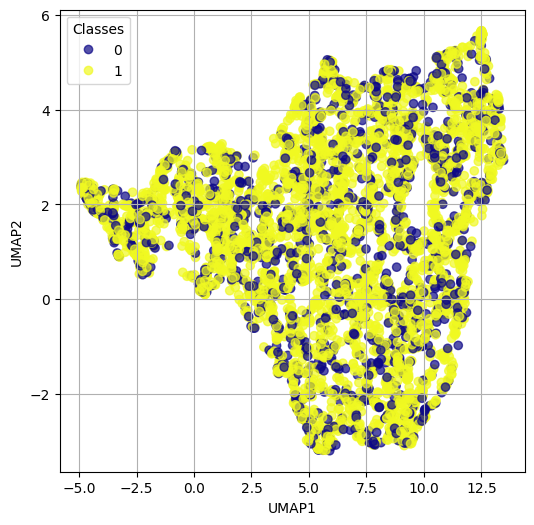

In [6]:
y_train = torch.cat([y for _, y in train_raw_loader], dim=0)

visualize_umap(x_train_encoded.numpy(), y_train.numpy())

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


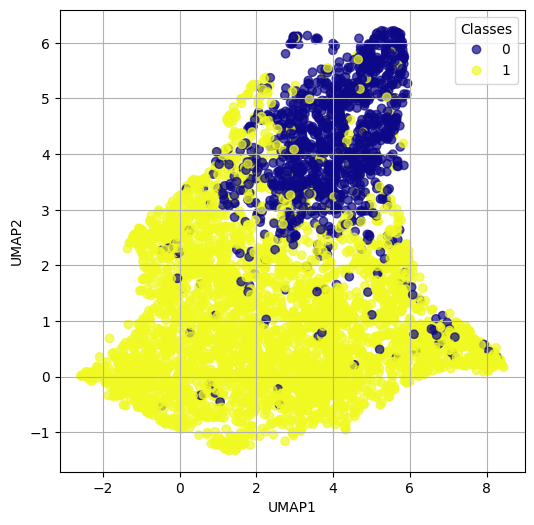

In [7]:
x_train_raw, y_train_raw = extract_xy_from_loader(train_raw_loader)

visualize_umap(x_train_raw.numpy(), y_train_raw.numpy())

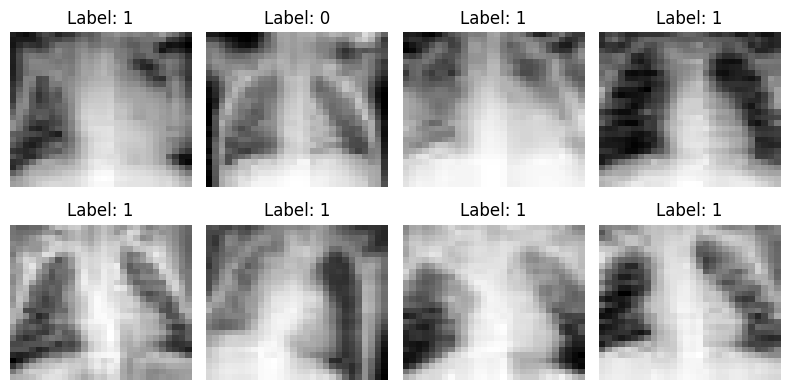

In [8]:
x_batch, y_batch = sample_batch(train_raw_loader, n_samples=8)
show_images_batch(x_batch.view(-1, 1, 28, 28), y_batch)

/tmp/ipykernel_94770/3624222051.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)


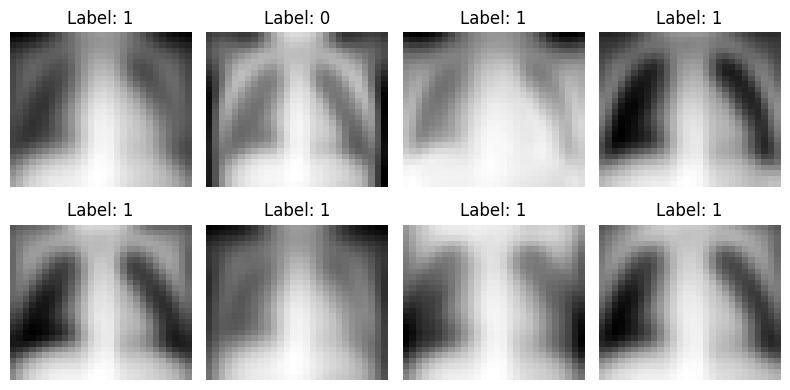

In [9]:
#pca encoded images
temp_dataset = TensorDataset(x_batch, y_batch)
temp_loader = DataLoader(temp_dataset, batch_size=8, shuffle=False)

x_encoded, y_encoded = encoder.transform(temp_loader)
x_reconstructed = encoder.pca.inverse_transform(x_encoded)

x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)

show_images_batch(x_reconstructed, y_batch)

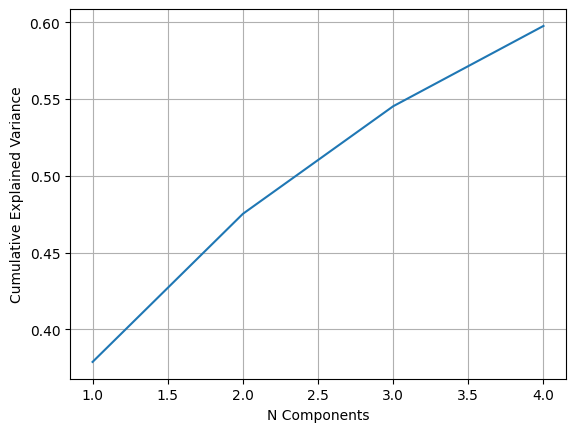

In [10]:
data_variance_plot(encoder)

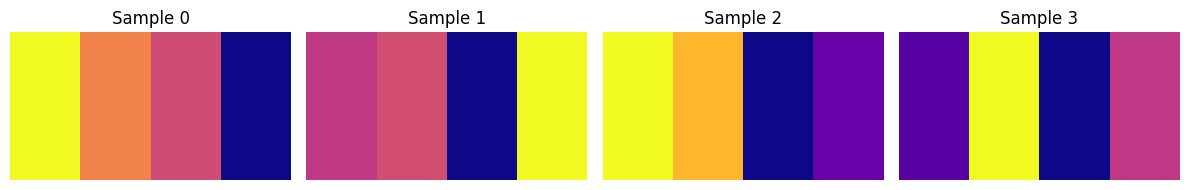

In [11]:
feature_heatmap(x_train_encoded)

## CONTINUOUS VARIABLE MODEL

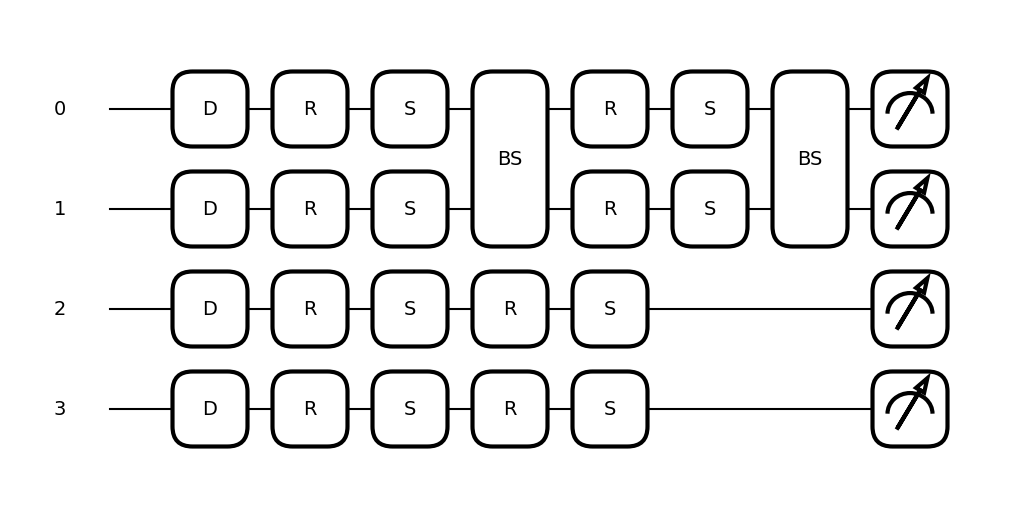

In [12]:
n_qumodes = 4
dummy_inputs = torch.zeros(n_qumodes)
dummy_weights = torch.zeros((2, n_qumodes, 4))

fig, ax = draw_mpl(cv_qcnn)(dummy_inputs, dummy_weights, n_qumodes)

In [13]:
save_database_name = "pneumonia"

#run once to train
# x_train_tensor, x_val_tensor, x_test_tensor = data_scaler(x_train_encoded, x_val_encoded, x_test_encoded, save_database_name=save_database_name)

In [16]:
#load once trained
# scaler = joblib.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/pca_scaler_{save_database_name}.pkl")
scaler = joblib.load(f"/home/dalopezm/gaussian-qnns/model_checkpoints/pca_scaler_{save_database_name}.pkl")

x_train_scaled = scaler.transform(x_train_encoded)
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)

x_val_scaled = scaler.transform(x_val_encoded)
x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)

x_test_scaled = scaler.transform(x_test_encoded)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)

In [17]:
#make dataloaders with reduced dimensions
train_dataset, train_loader = dataset_dataloaders(x_train_tensor, y_train_tensor.squeeze())
val_dataset, val_loader = dataset_dataloaders(x_val_tensor, y_val_tensor)
test_dataset, test_loader = dataset_dataloaders(x_test_tensor, y_test_tensor)

In [18]:
x_train_pca, y_train_pca = extract_xy_from_loader(train_loader)

In [19]:
x_train_pca_sample, y_train_pca_sample = train_dataset[0]

In [20]:
print(y_train_pca_sample.shape, y_train_pca_sample)
print(y_train_pca_sample.dtype)

torch.Size([]) tensor(1)
torch.int64


In [21]:
print(y_train_pca.shape, y_train_pca)
print(y_train_pca.dtype)
n_classes = len(y_train_pca.unique())
print(n_classes)

torch.Size([4708]) tensor([1, 0, 1,  ..., 1, 1, 1])
torch.int64
2


In [22]:
# print(y_train.shape)
# print(y_train.dtype)
# print(np.unique(y_train))

In [45]:
epochs = 50
# epochs = 5
device = "cpu"
# cv_model = QuantumLinear(n_qumodes=4, n_classes=n_classes).to(device)
cv_model = QuantumLinear(n_qumodes=4, n_classes=2).to(device)

optimizer = torch.optim.Adam(cv_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [46]:
from torchinfo import summary
summary(cv_model)

Layer (type:depth-idx)                   Param #
QuantumLinear                            --
├─TorchLayer: 1-1                        32
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       10
Total params: 42
Trainable params: 42
Non-trainable params: 0

In [47]:
model_name = "cv_pneumonia"

In [64]:
# run_kfold_training(QuantumLinear, train_dataset, optimizer, criterion, n_classes, model_name, device=device, classical=False, k=3, num_epochs=epochs, seed=42)


 Fold 1/3


Training: 100%|██████| 50/50 [00:05<00:00,  9.15it/s, loss=747.8991, acc=0.3771]


Train loss: 1658.1242 | Train acc: 0.3910 | Train rec: 0.3910 | Train prec: 0.5150 | Train f1: 0.4284
Val loss: 747.8991 | Val acc: 0.3771 | Val rec: 0.3771 | Val prec: 0.5017 | Val f1: 0.3771


Training: 100%|███████| 50/50 [00:05<00:00,  8.93it/s, loss=14.8930, acc=0.6248]


Train loss: 294.6791 | Train acc: 0.4073 | Train rec: 0.4073 | Train prec: 0.5329 | Train f1: 0.4435
Val loss: 14.8930 | Val acc: 0.6248 | Val rec: 0.6248 | Val prec: 0.7319 | Val f1: 0.6248


Training: 100%|████████| 50/50 [00:05<00:00,  9.17it/s, loss=2.3023, acc=0.6325]


Train loss: 5.9775 | Train acc: 0.5867 | Train rec: 0.5867 | Train prec: 0.6999 | Train f1: 0.6125
Val loss: 2.3023 | Val acc: 0.6325 | Val rec: 0.6325 | Val prec: 0.7300 | Val f1: 0.6325


Training: 100%|████████| 50/50 [00:05<00:00,  8.68it/s, loss=0.3955, acc=0.8306]


Train loss: 1.1406 | Train acc: 0.6944 | Train rec: 0.6944 | Train prec: 0.7731 | Train f1: 0.7128
Val loss: 0.3955 | Val acc: 0.8306 | Val rec: 0.8306 | Val prec: 0.8687 | Val f1: 0.8306


Training: 100%|████████| 50/50 [00:05<00:00,  9.00it/s, loss=0.8577, acc=0.6070]


Train loss: 0.4095 | Train acc: 0.8397 | Train rec: 0.8397 | Train prec: 0.8691 | Train f1: 0.8467
Val loss: 0.8577 | Val acc: 0.6070 | Val rec: 0.6070 | Val prec: 0.7019 | Val f1: 0.6070


Training: 100%|████████| 50/50 [00:05<00:00,  8.58it/s, loss=0.4021, acc=0.8318]


Train loss: 0.4936 | Train acc: 0.7909 | Train rec: 0.7909 | Train prec: 0.8339 | Train f1: 0.8014
Val loss: 0.4021 | Val acc: 0.8318 | Val rec: 0.8318 | Val prec: 0.8508 | Val f1: 0.8318


Training: 100%|████████| 50/50 [00:05<00:00,  9.19it/s, loss=0.3332, acc=0.8783]


Train loss: 0.4570 | Train acc: 0.8196 | Train rec: 0.8196 | Train prec: 0.8445 | Train f1: 0.8266
Val loss: 0.3332 | Val acc: 0.8783 | Val rec: 0.8783 | Val prec: 0.8837 | Val f1: 0.8783


Training: 100%|████████| 50/50 [00:05<00:00,  8.68it/s, loss=0.3542, acc=0.8662]


Train loss: 0.3659 | Train acc: 0.8569 | Train rec: 0.8569 | Train prec: 0.8683 | Train f1: 0.8605
Val loss: 0.3542 | Val acc: 0.8662 | Val rec: 0.8662 | Val prec: 0.8697 | Val f1: 0.8662


Training: 100%|████████| 50/50 [00:05<00:00,  9.05it/s, loss=0.5939, acc=0.7688]


Train loss: 0.4007 | Train acc: 0.8343 | Train rec: 0.8343 | Train prec: 0.8463 | Train f1: 0.8384
Val loss: 0.5939 | Val acc: 0.7688 | Val rec: 0.7688 | Val prec: 0.8105 | Val f1: 0.7688


Training: 100%|████████| 50/50 [00:05<00:00,  9.01it/s, loss=0.3511, acc=0.8408]


Train loss: 0.4565 | Train acc: 0.8101 | Train rec: 0.8101 | Train prec: 0.8231 | Train f1: 0.8148
Val loss: 0.3511 | Val acc: 0.8408 | Val rec: 0.8408 | Val prec: 0.8529 | Val f1: 0.8408


Training: 100%|████████| 50/50 [00:05<00:00,  9.13it/s, loss=0.3613, acc=0.8497]


Train loss: 0.3184 | Train acc: 0.8779 | Train rec: 0.8779 | Train prec: 0.8769 | Train f1: 0.8774
Val loss: 0.3613 | Val acc: 0.8497 | Val rec: 0.8497 | Val prec: 0.8490 | Val f1: 0.8497


Training: 100%|████████| 50/50 [00:05<00:00,  8.95it/s, loss=0.2990, acc=0.8834]


Train loss: 0.3613 | Train acc: 0.8480 | Train rec: 0.8480 | Train prec: 0.8518 | Train f1: 0.8496
Val loss: 0.2990 | Val acc: 0.8834 | Val rec: 0.8834 | Val prec: 0.8816 | Val f1: 0.8834


Training: 100%|████████| 50/50 [00:05<00:00,  9.66it/s, loss=0.3270, acc=0.8599]


Train loss: 0.3353 | Train acc: 0.8540 | Train rec: 0.8540 | Train prec: 0.8535 | Train f1: 0.8537
Val loss: 0.3270 | Val acc: 0.8599 | Val rec: 0.8599 | Val prec: 0.8566 | Val f1: 0.8599


Training: 100%|████████| 50/50 [00:05<00:00,  9.49it/s, loss=0.3159, acc=0.8592]


Train loss: 0.3489 | Train acc: 0.8525 | Train rec: 0.8525 | Train prec: 0.8526 | Train f1: 0.8525
Val loss: 0.3159 | Val acc: 0.8592 | Val rec: 0.8592 | Val prec: 0.8616 | Val f1: 0.8592


Training: 100%|████████| 50/50 [00:05<00:00,  9.12it/s, loss=0.5786, acc=0.7828]


Train loss: 0.4190 | Train acc: 0.8263 | Train rec: 0.8263 | Train prec: 0.8288 | Train f1: 0.8274
Val loss: 0.5786 | Val acc: 0.7828 | Val rec: 0.7828 | Val prec: 0.8137 | Val f1: 0.7828


Training: 100%|████████| 50/50 [00:05<00:00,  9.55it/s, loss=0.3806, acc=0.8350]


Train loss: 0.5813 | Train acc: 0.7747 | Train rec: 0.7747 | Train prec: 0.7878 | Train f1: 0.7799
Val loss: 0.3806 | Val acc: 0.8350 | Val rec: 0.8350 | Val prec: 0.8295 | Val f1: 0.8350


Training: 100%|████████| 50/50 [00:05<00:00,  9.51it/s, loss=0.3273, acc=0.8478]


Train loss: 0.3710 | Train acc: 0.8356 | Train rec: 0.8356 | Train prec: 0.8336 | Train f1: 0.8345
Val loss: 0.3273 | Val acc: 0.8478 | Val rec: 0.8478 | Val prec: 0.8497 | Val f1: 0.8478


Training: 100%|████████| 50/50 [00:05<00:00,  9.72it/s, loss=0.6066, acc=0.7803]


Train loss: 0.4472 | Train acc: 0.8301 | Train rec: 0.8301 | Train prec: 0.8294 | Train f1: 0.8298
Val loss: 0.6066 | Val acc: 0.7803 | Val rec: 0.7803 | Val prec: 0.8076 | Val f1: 0.7803


Training: 100%|████████| 50/50 [00:05<00:00,  9.72it/s, loss=1.0746, acc=0.7382]


Train loss: 0.4042 | Train acc: 0.8327 | Train rec: 0.8327 | Train prec: 0.8305 | Train f1: 0.8315
Val loss: 1.0746 | Val acc: 0.7382 | Val rec: 0.7382 | Val prec: 0.7824 | Val f1: 0.7382


Training: 100%|████████| 50/50 [00:05<00:00,  9.55it/s, loss=0.2839, acc=0.8815]


Train loss: 0.5248 | Train acc: 0.7925 | Train rec: 0.7925 | Train prec: 0.7974 | Train f1: 0.7947
Val loss: 0.2839 | Val acc: 0.8815 | Val rec: 0.8815 | Val prec: 0.8785 | Val f1: 0.8815


Training: 100%|████████| 50/50 [00:05<00:00,  9.38it/s, loss=0.8642, acc=0.7510]


Train loss: 0.3403 | Train acc: 0.8493 | Train rec: 0.8493 | Train prec: 0.8458 | Train f1: 0.8471
Val loss: 0.8642 | Val acc: 0.7510 | Val rec: 0.7510 | Val prec: 0.7887 | Val f1: 0.7510


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.4228, acc=0.8172]


Train loss: 0.3538 | Train acc: 0.8384 | Train rec: 0.8384 | Train prec: 0.8348 | Train f1: 0.8362
Val loss: 0.4228 | Val acc: 0.8172 | Val rec: 0.8172 | Val prec: 0.8273 | Val f1: 0.8172


Training: 100%|████████| 50/50 [00:05<00:00,  9.23it/s, loss=0.8678, acc=0.7529]


Train loss: 0.5516 | Train acc: 0.8139 | Train rec: 0.8139 | Train prec: 0.8156 | Train f1: 0.8147
Val loss: 0.8678 | Val acc: 0.7529 | Val rec: 0.7529 | Val prec: 0.7885 | Val f1: 0.7529


Training: 100%|████████| 50/50 [00:05<00:00,  9.55it/s, loss=0.3005, acc=0.8701]


Train loss: 0.4342 | Train acc: 0.8327 | Train rec: 0.8327 | Train prec: 0.8292 | Train f1: 0.8306
Val loss: 0.3005 | Val acc: 0.8701 | Val rec: 0.8701 | Val prec: 0.8662 | Val f1: 0.8701


Training: 100%|████████| 50/50 [00:05<00:00,  9.15it/s, loss=0.3391, acc=0.8529]


Train loss: 0.3578 | Train acc: 0.8518 | Train rec: 0.8518 | Train prec: 0.8481 | Train f1: 0.8493
Val loss: 0.3391 | Val acc: 0.8529 | Val rec: 0.8529 | Val prec: 0.8475 | Val f1: 0.8529


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=1.9626, acc=0.5382]


Train loss: 0.2943 | Train acc: 0.8754 | Train rec: 0.8754 | Train prec: 0.8719 | Train f1: 0.8721
Val loss: 1.9626 | Val acc: 0.5382 | Val rec: 0.5382 | Val prec: 0.6082 | Val f1: 0.5382


Training: 100%|████████| 50/50 [00:05<00:00,  9.68it/s, loss=0.2629, acc=0.8885]


Train loss: 0.4155 | Train acc: 0.8343 | Train rec: 0.8343 | Train prec: 0.8318 | Train f1: 0.8329
Val loss: 0.2629 | Val acc: 0.8885 | Val rec: 0.8885 | Val prec: 0.8859 | Val f1: 0.8885


Training: 100%|████████| 50/50 [00:05<00:00,  9.55it/s, loss=0.2609, acc=0.8873]


Train loss: 0.3351 | Train acc: 0.8525 | Train rec: 0.8525 | Train prec: 0.8488 | Train f1: 0.8500
Val loss: 0.2609 | Val acc: 0.8873 | Val rec: 0.8873 | Val prec: 0.8847 | Val f1: 0.8873


Training: 100%|████████| 50/50 [00:05<00:00,  9.54it/s, loss=1.5608, acc=0.7255]


Train loss: 0.7053 | Train acc: 0.8107 | Train rec: 0.8107 | Train prec: 0.8153 | Train f1: 0.8127
Val loss: 1.5608 | Val acc: 0.7255 | Val rec: 0.7255 | Val prec: 0.7764 | Val f1: 0.7255


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.2930, acc=0.8707]


Train loss: 0.5363 | Train acc: 0.8059 | Train rec: 0.8059 | Train prec: 0.8095 | Train f1: 0.8075
Val loss: 0.2930 | Val acc: 0.8707 | Val rec: 0.8707 | Val prec: 0.8668 | Val f1: 0.8707


Training: 100%|████████| 50/50 [00:05<00:00,  9.63it/s, loss=0.3108, acc=0.8631]


Train loss: 0.3464 | Train acc: 0.8525 | Train rec: 0.8525 | Train prec: 0.8491 | Train f1: 0.8503
Val loss: 0.3108 | Val acc: 0.8631 | Val rec: 0.8631 | Val prec: 0.8621 | Val f1: 0.8631


Training: 100%|████████| 50/50 [00:05<00:00,  9.10it/s, loss=0.9989, acc=0.7561]


Train loss: 0.2953 | Train acc: 0.8709 | Train rec: 0.8709 | Train prec: 0.8673 | Train f1: 0.8679
Val loss: 0.9989 | Val acc: 0.7561 | Val rec: 0.7561 | Val prec: 0.7929 | Val f1: 0.7561


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.2688, acc=0.8898]


Train loss: 0.5638 | Train acc: 0.8158 | Train rec: 0.8158 | Train prec: 0.8167 | Train f1: 0.8162
Val loss: 0.2688 | Val acc: 0.8898 | Val rec: 0.8898 | Val prec: 0.8873 | Val f1: 0.8898


Training: 100%|████████| 50/50 [00:05<00:00,  9.59it/s, loss=1.0248, acc=0.6382]


Train loss: 0.3419 | Train acc: 0.8576 | Train rec: 0.8576 | Train prec: 0.8542 | Train f1: 0.8554
Val loss: 1.0248 | Val acc: 0.6382 | Val rec: 0.6382 | Val prec: 0.6775 | Val f1: 0.6382


Training: 100%|████████| 50/50 [00:05<00:00,  9.55it/s, loss=0.2755, acc=0.8758]


Train loss: 0.4406 | Train acc: 0.8330 | Train rec: 0.8330 | Train prec: 0.8316 | Train f1: 0.8323
Val loss: 0.2755 | Val acc: 0.8758 | Val rec: 0.8758 | Val prec: 0.8723 | Val f1: 0.8758


Training: 100%|████████| 50/50 [00:05<00:00,  9.43it/s, loss=0.2831, acc=0.8726]


Train loss: 0.3986 | Train acc: 0.8435 | Train rec: 0.8435 | Train prec: 0.8430 | Train f1: 0.8432
Val loss: 0.2831 | Val acc: 0.8726 | Val rec: 0.8726 | Val prec: 0.8689 | Val f1: 0.8726


Training: 100%|████████| 50/50 [00:05<00:00,  9.60it/s, loss=0.2557, acc=0.8860]


Train loss: 0.3701 | Train acc: 0.8531 | Train rec: 0.8531 | Train prec: 0.8519 | Train f1: 0.8525
Val loss: 0.2557 | Val acc: 0.8860 | Val rec: 0.8860 | Val prec: 0.8831 | Val f1: 0.8860


Training: 100%|████████| 50/50 [00:05<00:00,  9.63it/s, loss=0.3737, acc=0.8439]


Train loss: 0.4241 | Train acc: 0.8356 | Train rec: 0.8356 | Train prec: 0.8364 | Train f1: 0.8360
Val loss: 0.3737 | Val acc: 0.8439 | Val rec: 0.8439 | Val prec: 0.8397 | Val f1: 0.8439


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.2703, acc=0.8764]


Train loss: 0.2926 | Train acc: 0.8760 | Train rec: 0.8760 | Train prec: 0.8732 | Train f1: 0.8740
Val loss: 0.2703 | Val acc: 0.8764 | Val rec: 0.8764 | Val prec: 0.8731 | Val f1: 0.8764


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.6867, acc=0.7949]


Train loss: 0.3387 | Train acc: 0.8595 | Train rec: 0.8595 | Train prec: 0.8572 | Train f1: 0.8581
Val loss: 0.6867 | Val acc: 0.7949 | Val rec: 0.7949 | Val prec: 0.8173 | Val f1: 0.7949


Training: 100%|████████| 50/50 [00:05<00:00,  9.55it/s, loss=2.2545, acc=0.7159]


Train loss: 0.4219 | Train acc: 0.8356 | Train rec: 0.8356 | Train prec: 0.8356 | Train f1: 0.8356
Val loss: 2.2545 | Val acc: 0.7159 | Val rec: 0.7159 | Val prec: 0.7745 | Val f1: 0.7159


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.2803, acc=0.8828]


Train loss: 0.5306 | Train acc: 0.8270 | Train rec: 0.8270 | Train prec: 0.8297 | Train f1: 0.8282
Val loss: 0.2803 | Val acc: 0.8828 | Val rec: 0.8828 | Val prec: 0.8805 | Val f1: 0.8828


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.2576, acc=0.8911]


Train loss: 0.3261 | Train acc: 0.8658 | Train rec: 0.8658 | Train prec: 0.8637 | Train f1: 0.8646
Val loss: 0.2576 | Val acc: 0.8911 | Val rec: 0.8911 | Val prec: 0.8886 | Val f1: 0.8911


Training: 100%|████████| 50/50 [00:05<00:00,  9.65it/s, loss=0.3847, acc=0.8414]


Train loss: 0.3143 | Train acc: 0.8678 | Train rec: 0.8678 | Train prec: 0.8662 | Train f1: 0.8668
Val loss: 0.3847 | Val acc: 0.8414 | Val rec: 0.8414 | Val prec: 0.8380 | Val f1: 0.8414


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.2840, acc=0.8701]


Train loss: 0.3968 | Train acc: 0.8474 | Train rec: 0.8474 | Train prec: 0.8468 | Train f1: 0.8471
Val loss: 0.2840 | Val acc: 0.8701 | Val rec: 0.8701 | Val prec: 0.8666 | Val f1: 0.8701


Training: 100%|████████| 50/50 [00:05<00:00,  9.59it/s, loss=0.2563, acc=0.8841]


Train loss: 0.3299 | Train acc: 0.8623 | Train rec: 0.8623 | Train prec: 0.8607 | Train f1: 0.8614
Val loss: 0.2563 | Val acc: 0.8841 | Val rec: 0.8841 | Val prec: 0.8813 | Val f1: 0.8841


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.2858, acc=0.8739]


Train loss: 0.2966 | Train acc: 0.8767 | Train rec: 0.8767 | Train prec: 0.8742 | Train f1: 0.8750
Val loss: 0.2858 | Val acc: 0.8739 | Val rec: 0.8739 | Val prec: 0.8707 | Val f1: 0.8739


Training: 100%|████████| 50/50 [00:05<00:00,  9.70it/s, loss=0.2586, acc=0.8790]


Train loss: 0.3124 | Train acc: 0.8658 | Train rec: 0.8658 | Train prec: 0.8640 | Train f1: 0.8647
Val loss: 0.2586 | Val acc: 0.8790 | Val rec: 0.8790 | Val prec: 0.8764 | Val f1: 0.8790


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.4481, acc=0.8318]


Train loss: 0.3080 | Train acc: 0.8687 | Train rec: 0.8687 | Train prec: 0.8677 | Train f1: 0.8682
Val loss: 0.4481 | Val acc: 0.8318 | Val rec: 0.8318 | Val prec: 0.8432 | Val f1: 0.8318


Training: 100%|████████| 50/50 [00:05<00:00,  9.18it/s, loss=0.7054, acc=0.7962]


Train loss: 0.3055 | Train acc: 0.8741 | Train rec: 0.8741 | Train prec: 0.8720 | Train f1: 0.8728
Val loss: 0.7054 | Val acc: 0.7962 | Val rec: 0.7962 | Val prec: 0.8175 | Val f1: 0.7962

 Fold 2/3


Training: 100%|████████| 50/50 [00:05<00:00,  9.54it/s, loss=2.5927, acc=0.4716]


Train loss: 7.4625 | Train acc: 0.4078 | Train rec: 0.4078 | Train prec: 0.5183 | Train f1: 0.4448
Val loss: 2.5927 | Val acc: 0.4716 | Val rec: 0.4716 | Val prec: 0.5831 | Val f1: 0.4716


Training: 100%|████████| 50/50 [00:05<00:00,  9.43it/s, loss=0.8093, acc=0.6163]


Train loss: 1.5265 | Train acc: 0.5282 | Train rec: 0.5282 | Train prec: 0.6391 | Train f1: 0.5576
Val loss: 0.8093 | Val acc: 0.6163 | Val rec: 0.6163 | Val prec: 0.6983 | Val f1: 0.6163


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.5111, acc=0.7635]


Train loss: 0.6310 | Train acc: 0.6913 | Train rec: 0.6913 | Train prec: 0.7490 | Train f1: 0.7080
Val loss: 0.5111 | Val acc: 0.7635 | Val rec: 0.7635 | Val prec: 0.7946 | Val f1: 0.7635


Training: 100%|████████| 50/50 [00:05<00:00,  9.54it/s, loss=0.4503, acc=0.8069]


Train loss: 0.4836 | Train acc: 0.7878 | Train rec: 0.7878 | Train prec: 0.8135 | Train f1: 0.7959
Val loss: 0.4503 | Val acc: 0.8069 | Val rec: 0.8069 | Val prec: 0.8229 | Val f1: 0.8069


Training: 100%|████████| 50/50 [00:05<00:00,  9.55it/s, loss=0.4027, acc=0.8317]


Train loss: 0.4325 | Train acc: 0.8216 | Train rec: 0.8216 | Train prec: 0.8384 | Train f1: 0.8270
Val loss: 0.4027 | Val acc: 0.8317 | Val rec: 0.8317 | Val prec: 0.8439 | Val f1: 0.8317


Training: 100%|████████| 50/50 [00:05<00:00,  9.65it/s, loss=0.3528, acc=0.8579]


Train loss: 0.3846 | Train acc: 0.8503 | Train rec: 0.8503 | Train prec: 0.8616 | Train f1: 0.8540
Val loss: 0.3528 | Val acc: 0.8579 | Val rec: 0.8579 | Val prec: 0.8673 | Val f1: 0.8579


Training: 100%|████████| 50/50 [00:05<00:00,  9.66it/s, loss=0.3111, acc=0.8776]


Train loss: 0.3404 | Train acc: 0.8716 | Train rec: 0.8716 | Train prec: 0.8818 | Train f1: 0.8748
Val loss: 0.3111 | Val acc: 0.8776 | Val rec: 0.8776 | Val prec: 0.8857 | Val f1: 0.8776


Training: 100%|████████| 50/50 [00:05<00:00,  9.09it/s, loss=0.2857, acc=0.8929]


Train loss: 0.3106 | Train acc: 0.8796 | Train rec: 0.8796 | Train prec: 0.8883 | Train f1: 0.8823
Val loss: 0.2857 | Val acc: 0.8929 | Val rec: 0.8929 | Val prec: 0.8977 | Val f1: 0.8929


Training: 100%|████████| 50/50 [00:05<00:00,  9.69it/s, loss=0.2713, acc=0.8961]


Train loss: 0.2944 | Train acc: 0.8844 | Train rec: 0.8844 | Train prec: 0.8914 | Train f1: 0.8867
Val loss: 0.2713 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8999 | Val f1: 0.8961


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.2627, acc=0.8980]


Train loss: 0.2851 | Train acc: 0.8866 | Train rec: 0.8866 | Train prec: 0.8910 | Train f1: 0.8882
Val loss: 0.2627 | Val acc: 0.8980 | Val rec: 0.8980 | Val prec: 0.9006 | Val f1: 0.8980


Training: 100%|████████| 50/50 [00:05<00:00,  9.61it/s, loss=0.2583, acc=0.8999]


Train loss: 0.2787 | Train acc: 0.8869 | Train rec: 0.8869 | Train prec: 0.8908 | Train f1: 0.8884
Val loss: 0.2583 | Val acc: 0.8999 | Val rec: 0.8999 | Val prec: 0.9009 | Val f1: 0.8999


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.2525, acc=0.8980]


Train loss: 0.2739 | Train acc: 0.8882 | Train rec: 0.8882 | Train prec: 0.8902 | Train f1: 0.8890
Val loss: 0.2525 | Val acc: 0.8980 | Val rec: 0.8980 | Val prec: 0.8995 | Val f1: 0.8980


Training: 100%|████████| 50/50 [00:05<00:00,  9.68it/s, loss=0.2503, acc=0.8967]


Train loss: 0.2704 | Train acc: 0.8879 | Train rec: 0.8879 | Train prec: 0.8898 | Train f1: 0.8887
Val loss: 0.2503 | Val acc: 0.8967 | Val rec: 0.8967 | Val prec: 0.8964 | Val f1: 0.8967


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.2462, acc=0.8955]


Train loss: 0.2673 | Train acc: 0.8869 | Train rec: 0.8869 | Train prec: 0.8875 | Train f1: 0.8872
Val loss: 0.2462 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8953 | Val f1: 0.8955


Training: 100%|████████| 50/50 [00:05<00:00,  9.41it/s, loss=0.2462, acc=0.8961]


Train loss: 0.2646 | Train acc: 0.8879 | Train rec: 0.8879 | Train prec: 0.8887 | Train f1: 0.8883
Val loss: 0.2462 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8944 | Val f1: 0.8961


Training: 100%|████████| 50/50 [00:05<00:00,  9.17it/s, loss=0.2426, acc=0.8980]


Train loss: 0.2628 | Train acc: 0.8901 | Train rec: 0.8901 | Train prec: 0.8901 | Train f1: 0.8901
Val loss: 0.2426 | Val acc: 0.8980 | Val rec: 0.8980 | Val prec: 0.8966 | Val f1: 0.8980


Training: 100%|████████| 50/50 [00:05<00:00,  9.59it/s, loss=0.2399, acc=0.9006]


Train loss: 0.2613 | Train acc: 0.8898 | Train rec: 0.8898 | Train prec: 0.8890 | Train f1: 0.8893
Val loss: 0.2399 | Val acc: 0.9006 | Val rec: 0.9006 | Val prec: 0.8993 | Val f1: 0.9006


Training: 100%|████████| 50/50 [00:05<00:00,  8.96it/s, loss=0.2409, acc=0.8967]


Train loss: 0.2597 | Train acc: 0.8885 | Train rec: 0.8885 | Train prec: 0.8883 | Train f1: 0.8884
Val loss: 0.2409 | Val acc: 0.8967 | Val rec: 0.8967 | Val prec: 0.8946 | Val f1: 0.8967


Training: 100%|████████| 50/50 [00:05<00:00,  9.46it/s, loss=0.2370, acc=0.8987]


Train loss: 0.2580 | Train acc: 0.8895 | Train rec: 0.8895 | Train prec: 0.8880 | Train f1: 0.8886
Val loss: 0.2370 | Val acc: 0.8987 | Val rec: 0.8987 | Val prec: 0.8974 | Val f1: 0.8987


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.2376, acc=0.8967]


Train loss: 0.2586 | Train acc: 0.8882 | Train rec: 0.8882 | Train prec: 0.8875 | Train f1: 0.8878
Val loss: 0.2376 | Val acc: 0.8967 | Val rec: 0.8967 | Val prec: 0.8948 | Val f1: 0.8967


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.2381, acc=0.8955]


Train loss: 0.2572 | Train acc: 0.8869 | Train rec: 0.8869 | Train prec: 0.8855 | Train f1: 0.8860
Val loss: 0.2381 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8932 | Val f1: 0.8955


Training: 100%|████████| 50/50 [00:05<00:00,  8.97it/s, loss=0.2367, acc=0.8955]


Train loss: 0.2564 | Train acc: 0.8888 | Train rec: 0.8888 | Train prec: 0.8872 | Train f1: 0.8878
Val loss: 0.2367 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8934 | Val f1: 0.8955


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.2352, acc=0.8955]


Train loss: 0.2558 | Train acc: 0.8888 | Train rec: 0.8888 | Train prec: 0.8873 | Train f1: 0.8879
Val loss: 0.2352 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8933 | Val f1: 0.8955


Training: 100%|████████| 50/50 [00:05<00:00,  9.60it/s, loss=0.2352, acc=0.8961]


Train loss: 0.2556 | Train acc: 0.8879 | Train rec: 0.8879 | Train prec: 0.8865 | Train f1: 0.8870
Val loss: 0.2352 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8939 | Val f1: 0.8961


Training: 100%|████████| 50/50 [00:05<00:00,  9.55it/s, loss=0.2331, acc=0.8974]


Train loss: 0.2551 | Train acc: 0.8885 | Train rec: 0.8885 | Train prec: 0.8870 | Train f1: 0.8876
Val loss: 0.2331 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8955 | Val f1: 0.8974


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.2341, acc=0.8955]


Train loss: 0.2554 | Train acc: 0.8891 | Train rec: 0.8891 | Train prec: 0.8878 | Train f1: 0.8883
Val loss: 0.2341 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8932 | Val f1: 0.8955


Training: 100%|████████| 50/50 [00:05<00:00,  9.09it/s, loss=0.2347, acc=0.8923]


Train loss: 0.2556 | Train acc: 0.8888 | Train rec: 0.8888 | Train prec: 0.8870 | Train f1: 0.8876
Val loss: 0.2347 | Val acc: 0.8923 | Val rec: 0.8923 | Val prec: 0.8898 | Val f1: 0.8923


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.2324, acc=0.8967]


Train loss: 0.2544 | Train acc: 0.8875 | Train rec: 0.8875 | Train prec: 0.8856 | Train f1: 0.8862
Val loss: 0.2324 | Val acc: 0.8967 | Val rec: 0.8967 | Val prec: 0.8948 | Val f1: 0.8967


Training: 100%|████████| 50/50 [00:05<00:00,  9.60it/s, loss=0.2318, acc=0.8942]


Train loss: 0.2546 | Train acc: 0.8891 | Train rec: 0.8891 | Train prec: 0.8874 | Train f1: 0.8880
Val loss: 0.2318 | Val acc: 0.8942 | Val rec: 0.8942 | Val prec: 0.8920 | Val f1: 0.8942


Training: 100%|████████| 50/50 [00:05<00:00,  9.48it/s, loss=0.2357, acc=0.8910]


Train loss: 0.2556 | Train acc: 0.8891 | Train rec: 0.8891 | Train prec: 0.8876 | Train f1: 0.8882
Val loss: 0.2357 | Val acc: 0.8910 | Val rec: 0.8910 | Val prec: 0.8885 | Val f1: 0.8910


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.2363, acc=0.8897]


Train loss: 0.2549 | Train acc: 0.8875 | Train rec: 0.8875 | Train prec: 0.8857 | Train f1: 0.8863
Val loss: 0.2363 | Val acc: 0.8897 | Val rec: 0.8897 | Val prec: 0.8871 | Val f1: 0.8897


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.2318, acc=0.8961]


Train loss: 0.2547 | Train acc: 0.8879 | Train rec: 0.8879 | Train prec: 0.8858 | Train f1: 0.8864
Val loss: 0.2318 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8940 | Val f1: 0.8961


Training: 100%|████████| 50/50 [00:05<00:00,  9.12it/s, loss=0.2331, acc=0.8955]


Train loss: 0.2545 | Train acc: 0.8901 | Train rec: 0.8901 | Train prec: 0.8881 | Train f1: 0.8887
Val loss: 0.2331 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8932 | Val f1: 0.8955


Training: 100%|████████| 50/50 [00:05<00:00,  9.11it/s, loss=0.2333, acc=0.8955]


Train loss: 0.2545 | Train acc: 0.8879 | Train rec: 0.8879 | Train prec: 0.8857 | Train f1: 0.8863
Val loss: 0.2333 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8932 | Val f1: 0.8955


Training: 100%|████████| 50/50 [00:05<00:00,  9.39it/s, loss=0.2321, acc=0.8942]


Train loss: 0.2550 | Train acc: 0.8863 | Train rec: 0.8863 | Train prec: 0.8841 | Train f1: 0.8848
Val loss: 0.2321 | Val acc: 0.8942 | Val rec: 0.8942 | Val prec: 0.8919 | Val f1: 0.8942


Training: 100%|████████| 50/50 [00:05<00:00,  9.08it/s, loss=0.2312, acc=0.8923]


Train loss: 0.2543 | Train acc: 0.8875 | Train rec: 0.8875 | Train prec: 0.8853 | Train f1: 0.8860
Val loss: 0.2312 | Val acc: 0.8923 | Val rec: 0.8923 | Val prec: 0.8899 | Val f1: 0.8923


Training: 100%|████████| 50/50 [00:05<00:00,  9.55it/s, loss=0.2328, acc=0.8955]


Train loss: 0.2544 | Train acc: 0.8901 | Train rec: 0.8901 | Train prec: 0.8879 | Train f1: 0.8885
Val loss: 0.2328 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8932 | Val f1: 0.8955


Training: 100%|████████| 50/50 [00:05<00:00,  9.54it/s, loss=0.2367, acc=0.8878]


Train loss: 0.2546 | Train acc: 0.8888 | Train rec: 0.8888 | Train prec: 0.8872 | Train f1: 0.8878
Val loss: 0.2367 | Val acc: 0.8878 | Val rec: 0.8878 | Val prec: 0.8851 | Val f1: 0.8878


Training: 100%|████████| 50/50 [00:05<00:00,  9.08it/s, loss=0.2325, acc=0.8942]


Train loss: 0.2562 | Train acc: 0.8895 | Train rec: 0.8895 | Train prec: 0.8872 | Train f1: 0.8878
Val loss: 0.2325 | Val acc: 0.8942 | Val rec: 0.8942 | Val prec: 0.8919 | Val f1: 0.8942


Training: 100%|████████| 50/50 [00:05<00:00,  9.64it/s, loss=0.2342, acc=0.8923]


Train loss: 0.2542 | Train acc: 0.8882 | Train rec: 0.8882 | Train prec: 0.8861 | Train f1: 0.8868
Val loss: 0.2342 | Val acc: 0.8923 | Val rec: 0.8923 | Val prec: 0.8898 | Val f1: 0.8923


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.2331, acc=0.8917]


Train loss: 0.2549 | Train acc: 0.8875 | Train rec: 0.8875 | Train prec: 0.8855 | Train f1: 0.8861
Val loss: 0.2331 | Val acc: 0.8917 | Val rec: 0.8917 | Val prec: 0.8891 | Val f1: 0.8917


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.2354, acc=0.8897]


Train loss: 0.2545 | Train acc: 0.8879 | Train rec: 0.8879 | Train prec: 0.8861 | Train f1: 0.8867
Val loss: 0.2354 | Val acc: 0.8897 | Val rec: 0.8897 | Val prec: 0.8871 | Val f1: 0.8897


Training: 100%|████████| 50/50 [00:05<00:00,  9.64it/s, loss=0.2359, acc=0.8910]


Train loss: 0.2550 | Train acc: 0.8885 | Train rec: 0.8885 | Train prec: 0.8864 | Train f1: 0.8870
Val loss: 0.2359 | Val acc: 0.8910 | Val rec: 0.8910 | Val prec: 0.8885 | Val f1: 0.8910


Training: 100%|████████| 50/50 [00:05<00:00,  9.09it/s, loss=0.2327, acc=0.8923]


Train loss: 0.2566 | Train acc: 0.8904 | Train rec: 0.8904 | Train prec: 0.8882 | Train f1: 0.8888
Val loss: 0.2327 | Val acc: 0.8923 | Val rec: 0.8923 | Val prec: 0.8898 | Val f1: 0.8923


Training: 100%|████████| 50/50 [00:05<00:00,  9.20it/s, loss=0.2325, acc=0.8948]


Train loss: 0.2558 | Train acc: 0.8898 | Train rec: 0.8898 | Train prec: 0.8874 | Train f1: 0.8879
Val loss: 0.2325 | Val acc: 0.8948 | Val rec: 0.8948 | Val prec: 0.8926 | Val f1: 0.8948


Training: 100%|████████| 50/50 [00:05<00:00,  9.64it/s, loss=0.2316, acc=0.8955]


Train loss: 0.2553 | Train acc: 0.8895 | Train rec: 0.8895 | Train prec: 0.8873 | Train f1: 0.8879
Val loss: 0.2316 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8932 | Val f1: 0.8955


Training: 100%|████████| 50/50 [00:05<00:00,  9.63it/s, loss=0.2322, acc=0.8948]


Train loss: 0.2561 | Train acc: 0.8882 | Train rec: 0.8882 | Train prec: 0.8863 | Train f1: 0.8869
Val loss: 0.2322 | Val acc: 0.8948 | Val rec: 0.8948 | Val prec: 0.8925 | Val f1: 0.8948


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.2329, acc=0.8942]


Train loss: 0.2553 | Train acc: 0.8898 | Train rec: 0.8898 | Train prec: 0.8875 | Train f1: 0.8880
Val loss: 0.2329 | Val acc: 0.8942 | Val rec: 0.8942 | Val prec: 0.8920 | Val f1: 0.8942


Training: 100%|████████| 50/50 [00:05<00:00,  9.61it/s, loss=0.2442, acc=0.8834]


Train loss: 0.2575 | Train acc: 0.8872 | Train rec: 0.8872 | Train prec: 0.8849 | Train f1: 0.8855
Val loss: 0.2442 | Val acc: 0.8834 | Val rec: 0.8834 | Val prec: 0.8816 | Val f1: 0.8834


Training: 100%|████████| 50/50 [00:05<00:00,  9.66it/s, loss=0.2312, acc=0.8967]


Train loss: 0.2560 | Train acc: 0.8901 | Train rec: 0.8901 | Train prec: 0.8877 | Train f1: 0.8881
Val loss: 0.2312 | Val acc: 0.8967 | Val rec: 0.8967 | Val prec: 0.8946 | Val f1: 0.8967

 Fold 3/3


Training: 100%|██████| 50/50 [00:05<00:00,  9.52it/s, loss=235.4773, acc=0.5035]


Train loss: 418.2384 | Train acc: 0.4415 | Train rec: 0.4415 | Train prec: 0.5690 | Train f1: 0.4757
Val loss: 235.4773 | Val acc: 0.5035 | Val rec: 0.5035 | Val prec: 0.6358 | Val f1: 0.5035


Training: 100%|███████| 50/50 [00:05<00:00,  9.60it/s, loss=96.0295, acc=0.5895]


Train loss: 163.4684 | Train acc: 0.5295 | Train rec: 0.5295 | Train prec: 0.6708 | Train f1: 0.5573
Val loss: 96.0295 | Val acc: 0.5895 | Val rec: 0.5895 | Val prec: 0.7307 | Val f1: 0.5895


Training: 100%|███████| 50/50 [00:05<00:00,  9.39it/s, loss=44.4075, acc=0.6660]


Train loss: 71.9067 | Train acc: 0.6171 | Train rec: 0.6171 | Train prec: 0.7636 | Train f1: 0.6397
Val loss: 44.4075 | Val acc: 0.6660 | Val rec: 0.6660 | Val prec: 0.8041 | Val f1: 0.6660


Training: 100%|███████| 50/50 [00:05<00:00,  9.65it/s, loss=22.8378, acc=0.7221]


Train loss: 34.2824 | Train acc: 0.6786 | Train rec: 0.6786 | Train prec: 0.8077 | Train f1: 0.6983
Val loss: 22.8378 | Val acc: 0.7221 | Val rec: 0.7221 | Val prec: 0.8341 | Val f1: 0.7221


Training: 100%|███████| 50/50 [00:05<00:00,  9.54it/s, loss=12.7085, acc=0.7757]


Train loss: 17.3656 | Train acc: 0.7369 | Train rec: 0.7369 | Train prec: 0.8377 | Train f1: 0.7533
Val loss: 12.7085 | Val acc: 0.7757 | Val rec: 0.7757 | Val prec: 0.8591 | Val f1: 0.7757


Training: 100%|████████| 50/50 [00:05<00:00,  9.55it/s, loss=7.6673, acc=0.8043]


Train loss: 9.7910 | Train acc: 0.7770 | Train rec: 0.7770 | Train prec: 0.8562 | Train f1: 0.7906
Val loss: 7.6673 | Val acc: 0.8043 | Val rec: 0.8043 | Val prec: 0.8696 | Val f1: 0.8043


Training: 100%|████████| 50/50 [00:05<00:00,  9.54it/s, loss=4.9727, acc=0.8254]


Train loss: 5.8528 | Train acc: 0.8095 | Train rec: 0.8095 | Train prec: 0.8706 | Train f1: 0.8205
Val loss: 4.9727 | Val acc: 0.8254 | Val rec: 0.8254 | Val prec: 0.8781 | Val f1: 0.8254


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=3.5282, acc=0.8247]


Train loss: 3.7789 | Train acc: 0.8219 | Train rec: 0.8219 | Train prec: 0.8777 | Train f1: 0.8319
Val loss: 3.5282 | Val acc: 0.8247 | Val rec: 0.8247 | Val prec: 0.8739 | Val f1: 0.8247


Training: 100%|████████| 50/50 [00:05<00:00,  9.73it/s, loss=2.7279, acc=0.8266]


Train loss: 2.6813 | Train acc: 0.8369 | Train rec: 0.8369 | Train prec: 0.8838 | Train f1: 0.8456
Val loss: 2.7279 | Val acc: 0.8266 | Val rec: 0.8266 | Val prec: 0.8754 | Val f1: 0.8266


Training: 100%|████████| 50/50 [00:05<00:00,  9.69it/s, loss=2.2313, acc=0.8228]


Train loss: 2.0837 | Train acc: 0.8372 | Train rec: 0.8372 | Train prec: 0.8839 | Train f1: 0.8459
Val loss: 2.2313 | Val acc: 0.8228 | Val rec: 0.8228 | Val prec: 0.8744 | Val f1: 0.8228


Training: 100%|████████| 50/50 [00:05<00:00,  9.54it/s, loss=1.8084, acc=0.8222]


Train loss: 1.6851 | Train acc: 0.8378 | Train rec: 0.8378 | Train prec: 0.8832 | Train f1: 0.8464
Val loss: 1.8084 | Val acc: 0.8222 | Val rec: 0.8222 | Val prec: 0.8748 | Val f1: 0.8222


Training: 100%|████████| 50/50 [00:05<00:00,  9.42it/s, loss=1.4730, acc=0.8337]


Train loss: 1.3676 | Train acc: 0.8423 | Train rec: 0.8423 | Train prec: 0.8843 | Train f1: 0.8504
Val loss: 1.4730 | Val acc: 0.8337 | Val rec: 0.8337 | Val prec: 0.8791 | Val f1: 0.8337


Training: 100%|████████| 50/50 [00:05<00:00,  9.42it/s, loss=1.1993, acc=0.8356]


Train loss: 1.1092 | Train acc: 0.8506 | Train rec: 0.8506 | Train prec: 0.8876 | Train f1: 0.8579
Val loss: 1.1993 | Val acc: 0.8356 | Val rec: 0.8356 | Val prec: 0.8781 | Val f1: 0.8356


Training: 100%|████████| 50/50 [00:05<00:00,  9.64it/s, loss=0.9925, acc=0.8343]


Train loss: 0.8956 | Train acc: 0.8573 | Train rec: 0.8573 | Train prec: 0.8898 | Train f1: 0.8639
Val loss: 0.9925 | Val acc: 0.8343 | Val rec: 0.8343 | Val prec: 0.8757 | Val f1: 0.8343


Training: 100%|████████| 50/50 [00:05<00:00,  9.61it/s, loss=0.7788, acc=0.8540]


Train loss: 0.7259 | Train acc: 0.8598 | Train rec: 0.8598 | Train prec: 0.8879 | Train f1: 0.8659
Val loss: 0.7788 | Val acc: 0.8540 | Val rec: 0.8540 | Val prec: 0.8832 | Val f1: 0.8540


Training: 100%|████████| 50/50 [00:05<00:00,  9.64it/s, loss=0.6259, acc=0.8579]


Train loss: 0.5794 | Train acc: 0.8665 | Train rec: 0.8665 | Train prec: 0.8893 | Train f1: 0.8718
Val loss: 0.6259 | Val acc: 0.8579 | Val rec: 0.8579 | Val prec: 0.8827 | Val f1: 0.8579


Training: 100%|████████| 50/50 [00:05<00:00,  9.55it/s, loss=0.5049, acc=0.8630]


Train loss: 0.4667 | Train acc: 0.8710 | Train rec: 0.8710 | Train prec: 0.8884 | Train f1: 0.8754
Val loss: 0.5049 | Val acc: 0.8630 | Val rec: 0.8630 | Val prec: 0.8823 | Val f1: 0.8630


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.4079, acc=0.8776]


Train loss: 0.3828 | Train acc: 0.8789 | Train rec: 0.8789 | Train prec: 0.8904 | Train f1: 0.8822
Val loss: 0.4079 | Val acc: 0.8776 | Val rec: 0.8776 | Val prec: 0.8897 | Val f1: 0.8776


Training: 100%|████████| 50/50 [00:05<00:00,  9.40it/s, loss=0.3493, acc=0.8815]


Train loss: 0.3259 | Train acc: 0.8844 | Train rec: 0.8844 | Train prec: 0.8902 | Train f1: 0.8864
Val loss: 0.3493 | Val acc: 0.8815 | Val rec: 0.8815 | Val prec: 0.8866 | Val f1: 0.8815


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.3088, acc=0.8897]


Train loss: 0.2906 | Train acc: 0.8879 | Train rec: 0.8879 | Train prec: 0.8899 | Train f1: 0.8887
Val loss: 0.3088 | Val acc: 0.8897 | Val rec: 0.8897 | Val prec: 0.8919 | Val f1: 0.8897


Training: 100%|████████| 50/50 [00:05<00:00,  9.08it/s, loss=0.2872, acc=0.8929]


Train loss: 0.2693 | Train acc: 0.8882 | Train rec: 0.8882 | Train prec: 0.8878 | Train f1: 0.8880
Val loss: 0.2872 | Val acc: 0.8929 | Val rec: 0.8929 | Val prec: 0.8939 | Val f1: 0.8929


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.2752, acc=0.8948]


Train loss: 0.2595 | Train acc: 0.8920 | Train rec: 0.8920 | Train prec: 0.8903 | Train f1: 0.8909
Val loss: 0.2752 | Val acc: 0.8948 | Val rec: 0.8948 | Val prec: 0.8946 | Val f1: 0.8948


Training: 100%|████████| 50/50 [00:05<00:00,  9.47it/s, loss=0.2757, acc=0.8955]


Train loss: 0.2558 | Train acc: 0.8888 | Train rec: 0.8888 | Train prec: 0.8867 | Train f1: 0.8874
Val loss: 0.2757 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8940 | Val f1: 0.8955


Training: 100%|████████| 50/50 [00:05<00:00,  9.16it/s, loss=0.2658, acc=0.8961]


Train loss: 0.2533 | Train acc: 0.8891 | Train rec: 0.8891 | Train prec: 0.8866 | Train f1: 0.8869
Val loss: 0.2658 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8947 | Val f1: 0.8961


Training: 100%|████████| 50/50 [00:05<00:00,  9.65it/s, loss=0.2639, acc=0.8936]


Train loss: 0.2517 | Train acc: 0.8885 | Train rec: 0.8885 | Train prec: 0.8860 | Train f1: 0.8864
Val loss: 0.2639 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8921 | Val f1: 0.8936


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.2628, acc=0.8948]


Train loss: 0.2512 | Train acc: 0.8901 | Train rec: 0.8901 | Train prec: 0.8875 | Train f1: 0.8875
Val loss: 0.2628 | Val acc: 0.8948 | Val rec: 0.8948 | Val prec: 0.8932 | Val f1: 0.8948


Training: 100%|████████| 50/50 [00:05<00:00,  9.67it/s, loss=0.2622, acc=0.8948]


Train loss: 0.2503 | Train acc: 0.8882 | Train rec: 0.8882 | Train prec: 0.8856 | Train f1: 0.8859
Val loss: 0.2622 | Val acc: 0.8948 | Val rec: 0.8948 | Val prec: 0.8932 | Val f1: 0.8948


Training: 100%|████████| 50/50 [00:05<00:00,  9.59it/s, loss=0.2606, acc=0.8955]


Train loss: 0.2494 | Train acc: 0.8882 | Train rec: 0.8882 | Train prec: 0.8855 | Train f1: 0.8855
Val loss: 0.2606 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8935 | Val f1: 0.8955


Training: 100%|████████| 50/50 [00:05<00:00,  9.60it/s, loss=0.2613, acc=0.8974]


Train loss: 0.2496 | Train acc: 0.8885 | Train rec: 0.8885 | Train prec: 0.8858 | Train f1: 0.8857
Val loss: 0.2613 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8954 | Val f1: 0.8974


Training: 100%|████████| 50/50 [00:05<00:00,  9.71it/s, loss=0.2606, acc=0.8974]


Train loss: 0.2493 | Train acc: 0.8895 | Train rec: 0.8895 | Train prec: 0.8869 | Train f1: 0.8871
Val loss: 0.2606 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8954 | Val f1: 0.8974


Training: 100%|████████| 50/50 [00:05<00:00,  9.09it/s, loss=0.2653, acc=0.8974]


Train loss: 0.2491 | Train acc: 0.8869 | Train rec: 0.8869 | Train prec: 0.8843 | Train f1: 0.8847
Val loss: 0.2653 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8955 | Val f1: 0.8974


Training: 100%|████████| 50/50 [00:05<00:00,  9.54it/s, loss=0.2592, acc=0.8948]


Train loss: 0.2485 | Train acc: 0.8910 | Train rec: 0.8910 | Train prec: 0.8885 | Train f1: 0.8884
Val loss: 0.2592 | Val acc: 0.8948 | Val rec: 0.8948 | Val prec: 0.8930 | Val f1: 0.8948


Training: 100%|████████| 50/50 [00:05<00:00,  9.53it/s, loss=0.2590, acc=0.8955]


Train loss: 0.2471 | Train acc: 0.8895 | Train rec: 0.8895 | Train prec: 0.8869 | Train f1: 0.8872
Val loss: 0.2590 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8937 | Val f1: 0.8955


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.2638, acc=0.8974]


Train loss: 0.2466 | Train acc: 0.8895 | Train rec: 0.8895 | Train prec: 0.8869 | Train f1: 0.8872
Val loss: 0.2638 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8954 | Val f1: 0.8974


Training: 100%|████████| 50/50 [00:05<00:00,  9.54it/s, loss=0.2575, acc=0.8942]


Train loss: 0.2474 | Train acc: 0.8888 | Train rec: 0.8888 | Train prec: 0.8863 | Train f1: 0.8867
Val loss: 0.2575 | Val acc: 0.8942 | Val rec: 0.8942 | Val prec: 0.8927 | Val f1: 0.8942


Training: 100%|████████| 50/50 [00:05<00:00,  9.55it/s, loss=0.2571, acc=0.8948]


Train loss: 0.2467 | Train acc: 0.8885 | Train rec: 0.8885 | Train prec: 0.8859 | Train f1: 0.8863
Val loss: 0.2571 | Val acc: 0.8948 | Val rec: 0.8948 | Val prec: 0.8932 | Val f1: 0.8948


Training: 100%|████████| 50/50 [00:05<00:00,  9.55it/s, loss=0.2594, acc=0.8967]


Train loss: 0.2458 | Train acc: 0.8885 | Train rec: 0.8885 | Train prec: 0.8858 | Train f1: 0.8861
Val loss: 0.2594 | Val acc: 0.8967 | Val rec: 0.8967 | Val prec: 0.8951 | Val f1: 0.8967


Training: 100%|████████| 50/50 [00:05<00:00,  9.10it/s, loss=0.2630, acc=0.8967]


Train loss: 0.2455 | Train acc: 0.8901 | Train rec: 0.8901 | Train prec: 0.8876 | Train f1: 0.8880
Val loss: 0.2630 | Val acc: 0.8967 | Val rec: 0.8967 | Val prec: 0.8951 | Val f1: 0.8967


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.2795, acc=0.8891]


Train loss: 0.2472 | Train acc: 0.8879 | Train rec: 0.8879 | Train prec: 0.8855 | Train f1: 0.8860
Val loss: 0.2795 | Val acc: 0.8891 | Val rec: 0.8891 | Val prec: 0.8872 | Val f1: 0.8891


Training: 100%|████████| 50/50 [00:05<00:00,  8.93it/s, loss=0.2591, acc=0.8987]


Train loss: 0.2489 | Train acc: 0.8895 | Train rec: 0.8895 | Train prec: 0.8870 | Train f1: 0.8874
Val loss: 0.2591 | Val acc: 0.8987 | Val rec: 0.8987 | Val prec: 0.8976 | Val f1: 0.8987


Training: 100%|████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.2560, acc=0.8955]


Train loss: 0.2473 | Train acc: 0.8914 | Train rec: 0.8914 | Train prec: 0.8891 | Train f1: 0.8896
Val loss: 0.2560 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8940 | Val f1: 0.8955


Training: 100%|████████| 50/50 [00:05<00:00,  9.18it/s, loss=0.2564, acc=0.8961]


Train loss: 0.2450 | Train acc: 0.8888 | Train rec: 0.8888 | Train prec: 0.8863 | Train f1: 0.8867
Val loss: 0.2564 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8946 | Val f1: 0.8961


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.2550, acc=0.8974]


Train loss: 0.2478 | Train acc: 0.8875 | Train rec: 0.8875 | Train prec: 0.8851 | Train f1: 0.8857
Val loss: 0.2550 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8959 | Val f1: 0.8974


Training: 100%|████████| 50/50 [00:05<00:00,  9.24it/s, loss=0.2629, acc=0.8961]


Train loss: 0.2462 | Train acc: 0.8891 | Train rec: 0.8891 | Train prec: 0.8868 | Train f1: 0.8873
Val loss: 0.2629 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8954 | Val f1: 0.8961


Training: 100%|████████| 50/50 [00:05<00:00,  9.12it/s, loss=0.2595, acc=0.8961]


Train loss: 0.2473 | Train acc: 0.8904 | Train rec: 0.8904 | Train prec: 0.8882 | Train f1: 0.8887
Val loss: 0.2595 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8945 | Val f1: 0.8961


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.2563, acc=0.8974]


Train loss: 0.2484 | Train acc: 0.8850 | Train rec: 0.8850 | Train prec: 0.8828 | Train f1: 0.8834
Val loss: 0.2563 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8963 | Val f1: 0.8974


Training: 100%|████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.2602, acc=0.8980]


Train loss: 0.2460 | Train acc: 0.8866 | Train rec: 0.8866 | Train prec: 0.8842 | Train f1: 0.8848
Val loss: 0.2602 | Val acc: 0.8980 | Val rec: 0.8980 | Val prec: 0.8962 | Val f1: 0.8980


Training: 100%|████████| 50/50 [00:05<00:00,  9.49it/s, loss=0.2560, acc=0.8961]


Train loss: 0.2459 | Train acc: 0.8885 | Train rec: 0.8885 | Train prec: 0.8861 | Train f1: 0.8866
Val loss: 0.2560 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8951 | Val f1: 0.8961


Training: 100%|████████| 50/50 [00:05<00:00,  9.57it/s, loss=0.2576, acc=0.8967]


Train loss: 0.2456 | Train acc: 0.8895 | Train rec: 0.8895 | Train prec: 0.8871 | Train f1: 0.8875
Val loss: 0.2576 | Val acc: 0.8967 | Val rec: 0.8967 | Val prec: 0.8953 | Val f1: 0.8967


Training: 100%|████████| 50/50 [00:05<00:00,  9.60it/s, loss=0.2569, acc=0.8980]

Train loss: 0.2453 | Train acc: 0.8872 | Train rec: 0.8872 | Train prec: 0.8849 | Train f1: 0.8855
Val loss: 0.2569 | Val acc: 0.8980 | Val rec: 0.8980 | Val prec: 0.8973 | Val f1: 0.8980


In [48]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}


for fold in range(n_folds):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_metrics.pkl", "rb") as f:
    
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

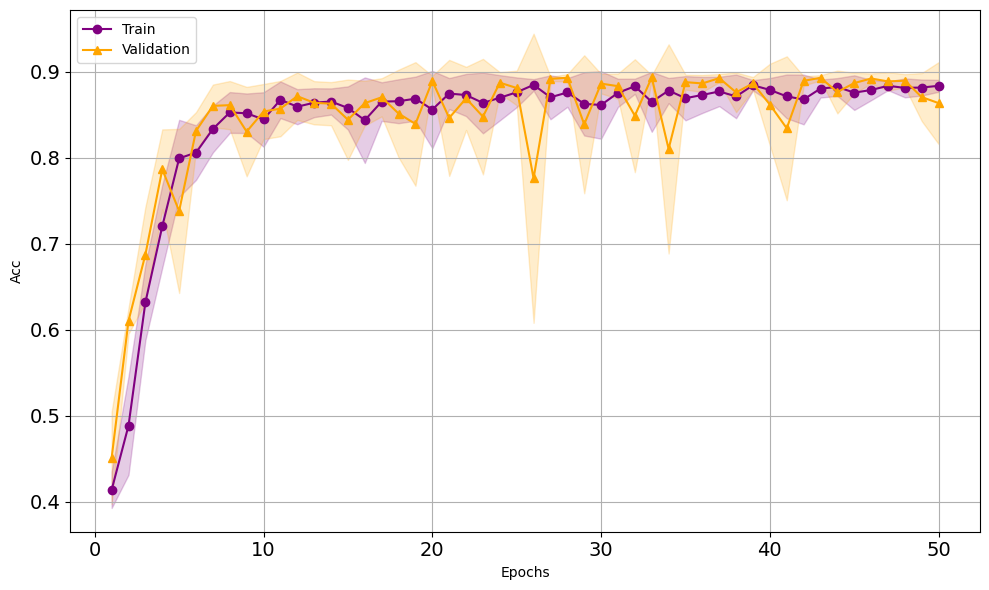

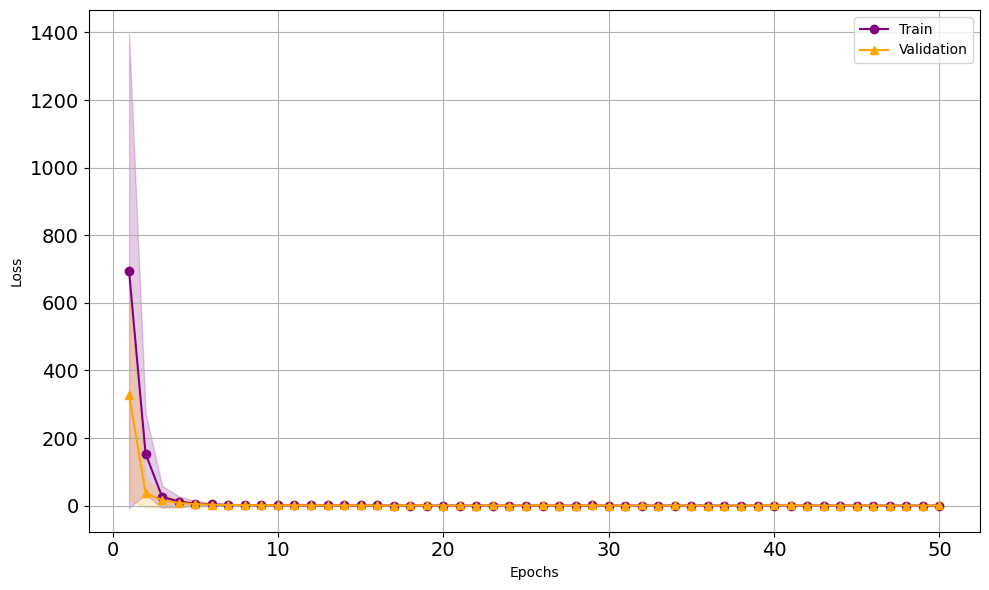

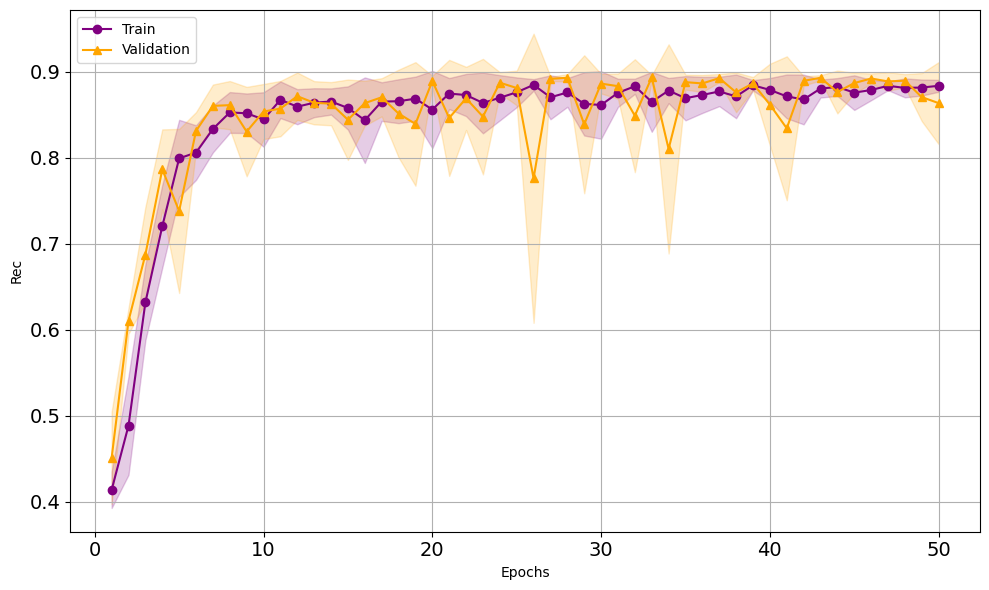

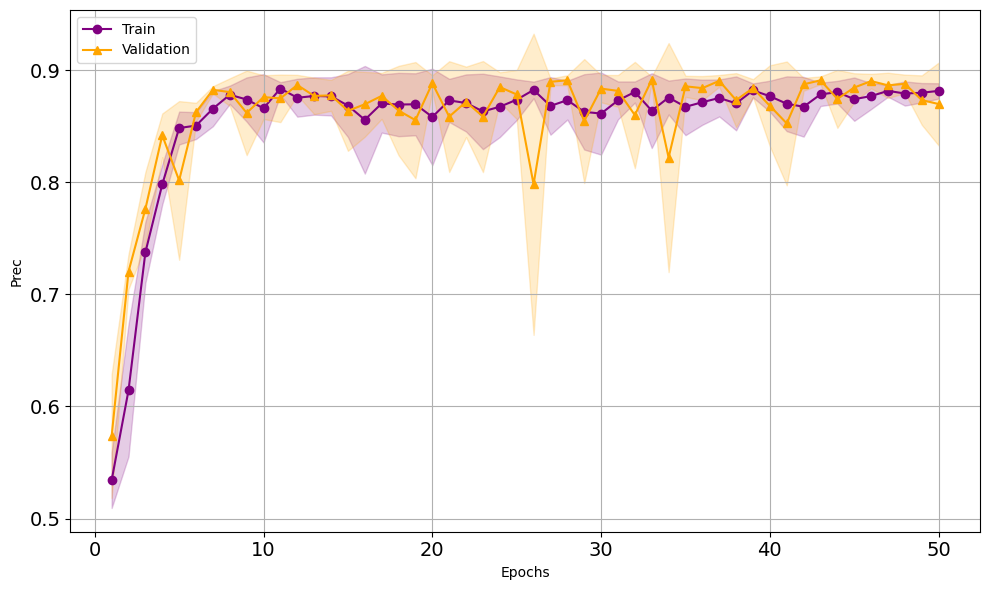

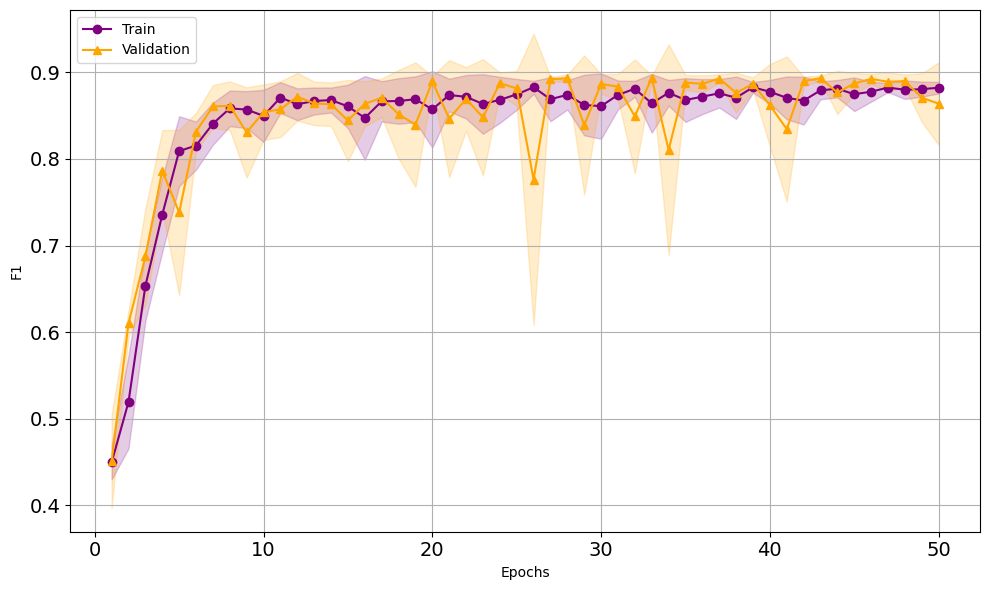

In [21]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range,  classical=False, save_name=f"{model_name}_mean_{metric}_curve")
    metrics_summary[metric] = summary

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_means_stds_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [49]:
best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")

Best fold: 3 with val_f1 = 0.8980


In [50]:
device = "cpu"
test_cv_model = QuantumLinear(n_qumodes=4, n_classes=2).to(device)

# test_cv_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_cv_model.load_state_dict(torch.load(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_cv_model.to(device)

test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, cv_test_probs, cv_test_labels = evaluate_v2(test_cv_model, test_loader, optimizer, criterion, device)

test_metrics["acc"].append(test_acc)
test_metrics["loss"].append(test_loss)
test_metrics["rec"].append(test_rec)
test_metrics["prec"].append(test_prec)
test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_test_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_test_metrics.json", "w") as f:
    json.dump(test_metrics, f, indent=4)

Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.27it/s, loss=0.3959, acc=0

Test loss: 0.3959 | Test acc: 0.8429 | Test rec: 0.8429 | Test prec: 0.8437 | Test f1: 0.8429


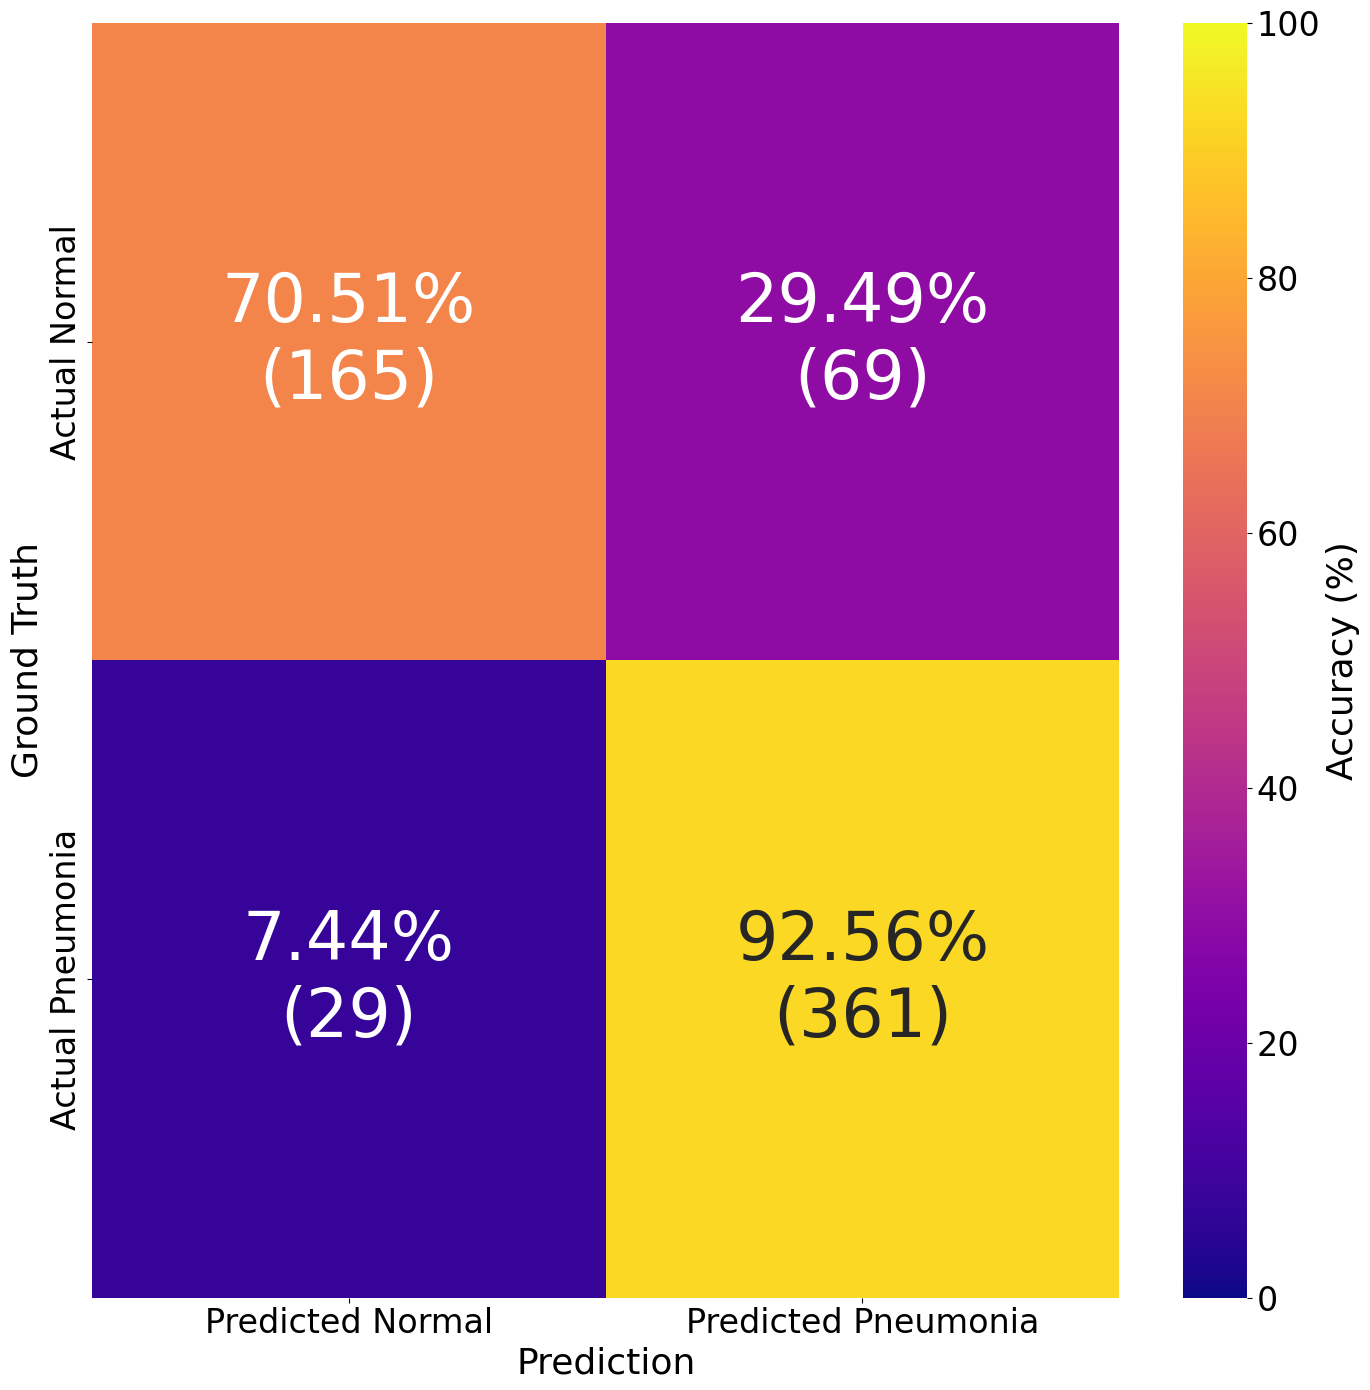

In [23]:
label_names = ["Normal", "Pneumonia"]

plot_confusion_matrix(cv_test_labels, test_preds, label_names, model_name, binary=True)

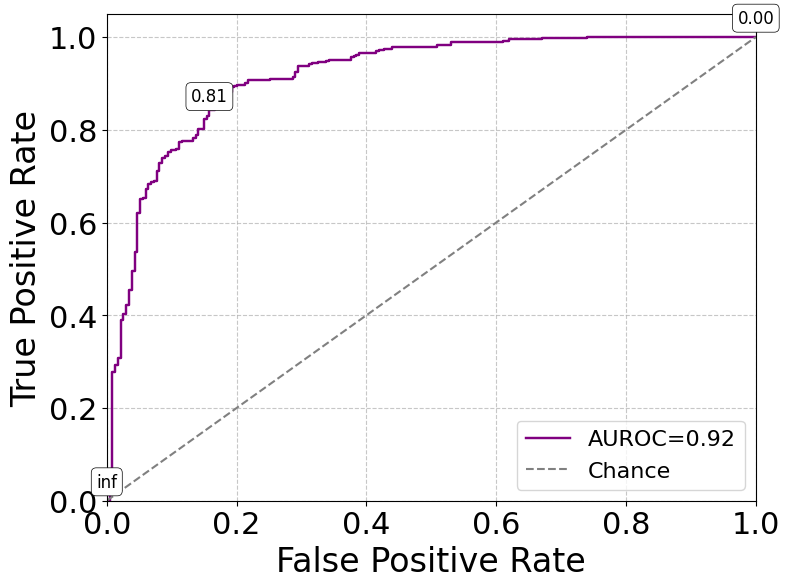

In [24]:
plot_auroc(cv_test_labels, cv_test_probs, model_name, binary=True)

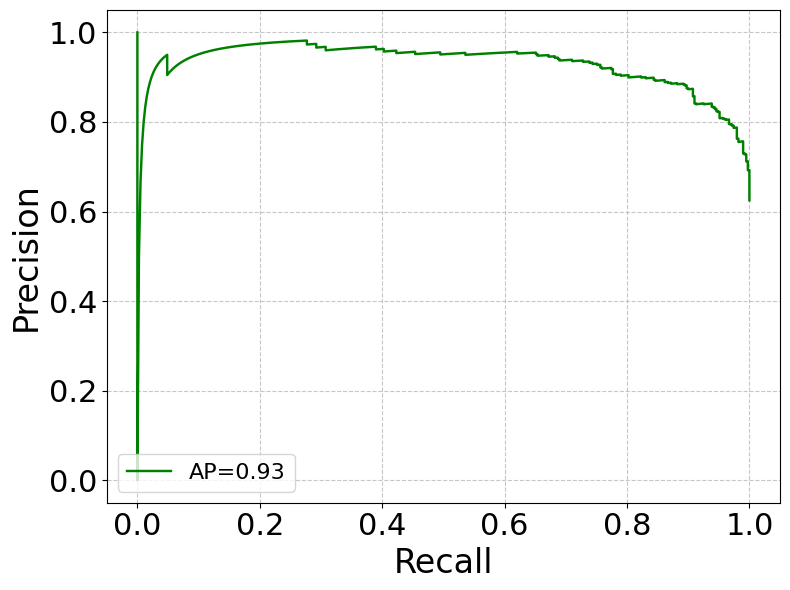

In [25]:
plot_prec(cv_test_labels, cv_test_probs, model_name, binary=True)

In [27]:
cam, outputs, predictions = gradcam_model(test_cv_model, x_test_tensor[0:16], quantum=True)
print(cam.shape)

torch.Size([16, 4])


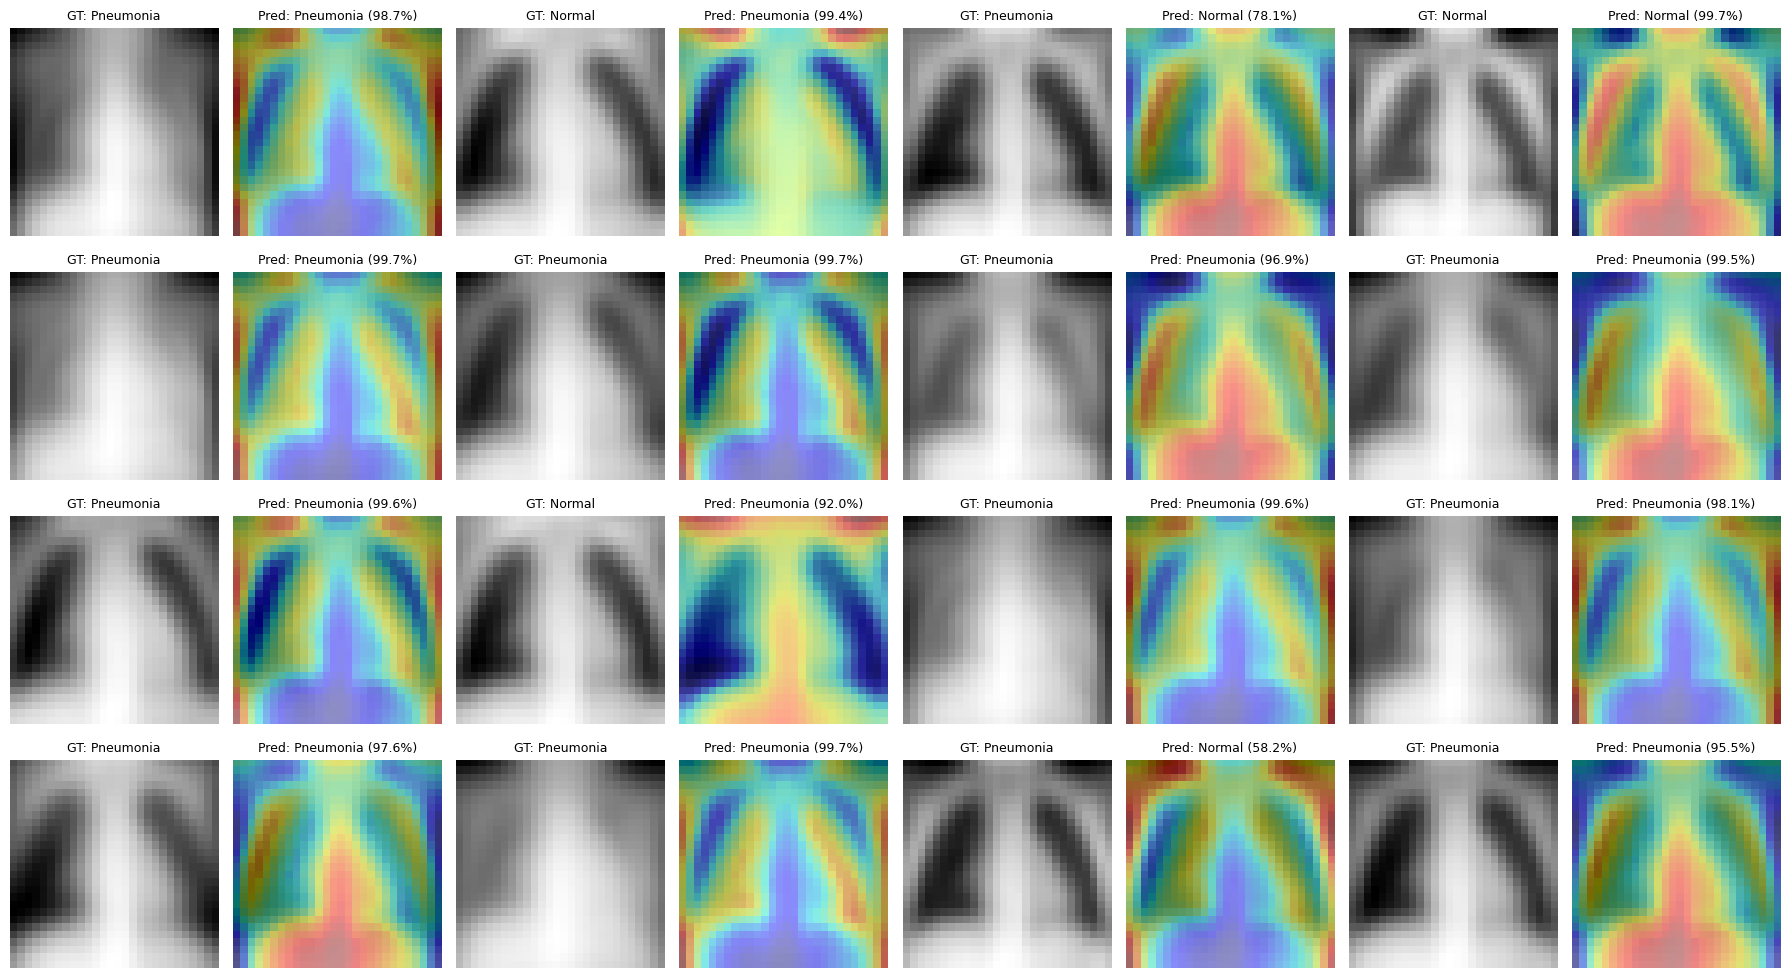

In [73]:
plot_reconstructed_heatmaps_with_predictions(
    samples = x_test_tensor[0:16].to(device),
    cam = cam,
    preds = predictions,
    probs = outputs,
    labels = y_test_tensor[0:16].to(device),
    encoder = encoder,
    class_names = label_names,
)

## DISCRETE MODEL

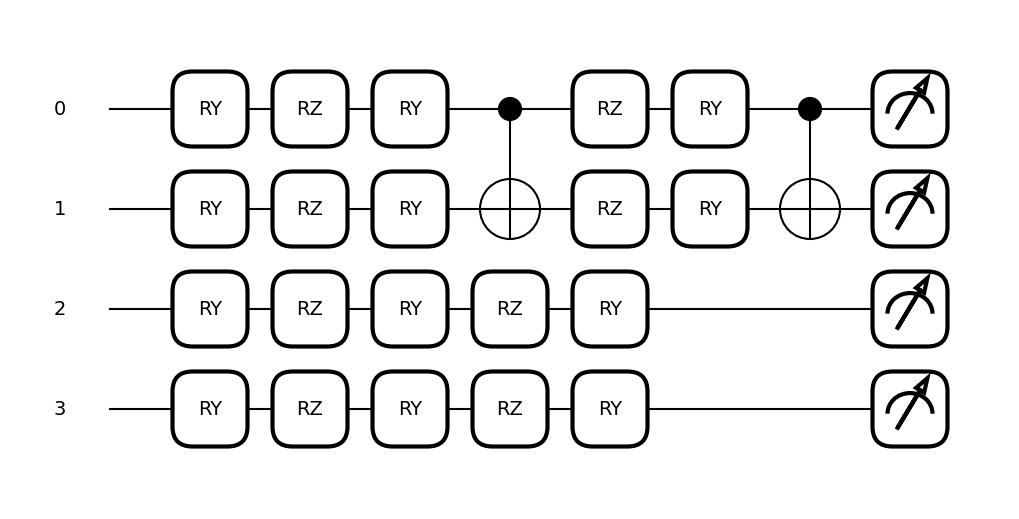

In [51]:
n_qubits = 4
dummy_inputs = torch.zeros(n_qubits)
dummy_weights = torch.zeros((2, n_qubits, 4))

fig, ax = draw_mpl(dv_qcnn)(dummy_inputs, dummy_weights, n_qubits)

In [52]:
epochs = 50
device = "cpu"
# dv_model = DVQuantumLinear(n_qubits=4, n_classes=n_classes).to(device)
dv_model = DVQuantumLinear(n_qubits=4, n_classes=2).to(device)

optimizer = torch.optim.Adam(dv_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

from torchinfo import summary
summary(dv_model)

Layer (type:depth-idx)                   Param #
DVQuantumLinear                          --
├─TorchLayer: 1-1                        32
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       10
Total params: 42
Trainable params: 42
Non-trainable params: 0

In [53]:
model_name = "dv_pneumonia"

In [34]:
run_kfold_training(DVQuantumLinear, train_dataset, optimizer, criterion, n_classes, model_name, device=device, classical=False, k=3, num_epochs=epochs, seed=42)


 Fold 1/3
 
Epoch 1/50 (fold 1)


Training | Fold 1 | Epoch 1:  12%| | 12/99 [00:06<00:44,  1.97it/s, loss=0.6261,


KeyboardInterrupt: 

In [54]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}
# model_name = "dv-linear"
model_name = "dv_pneumonia"


for fold in range(n_folds):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_metrics.pkl", "rb") as f:
    
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

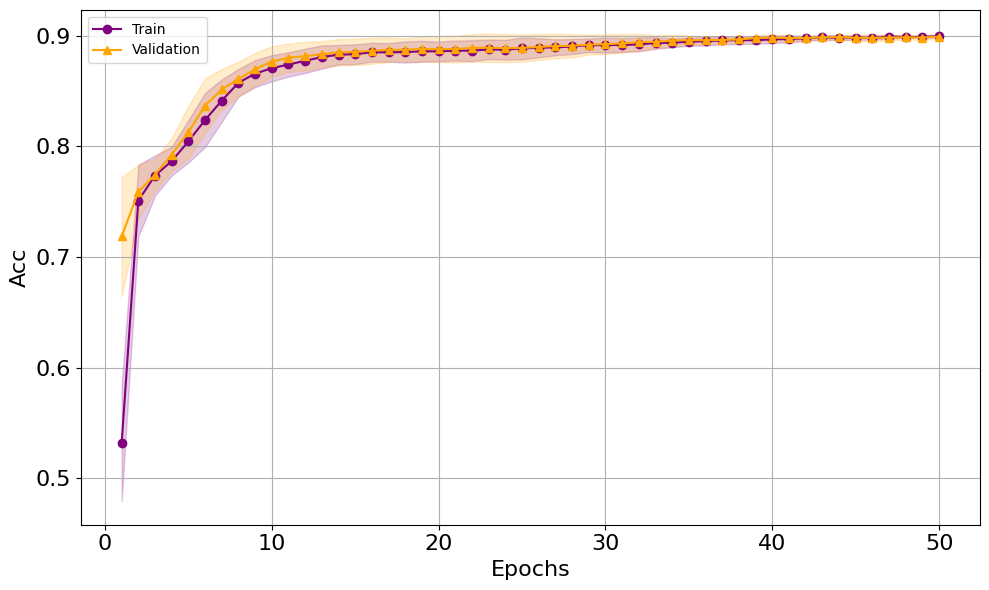

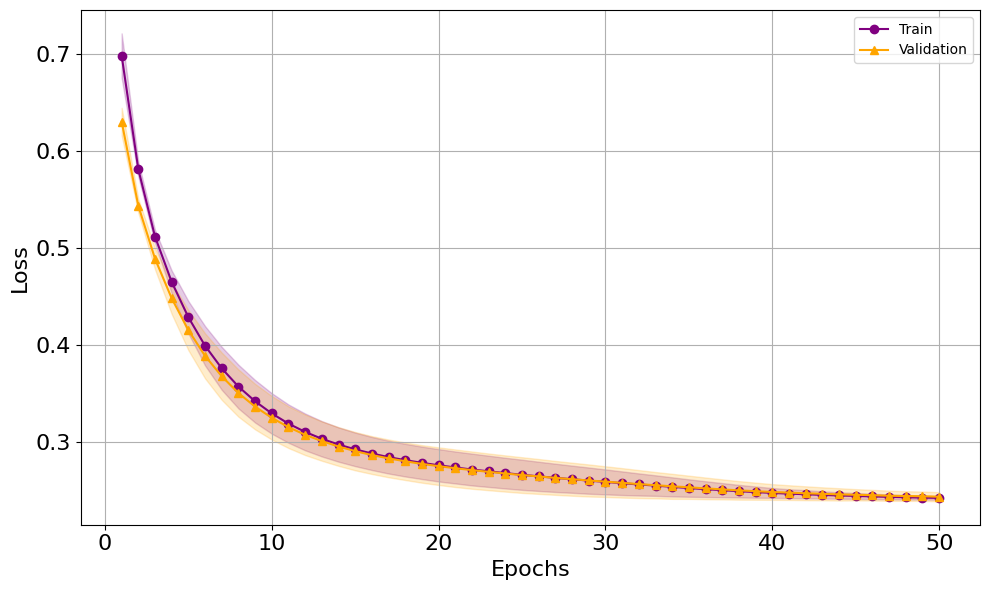

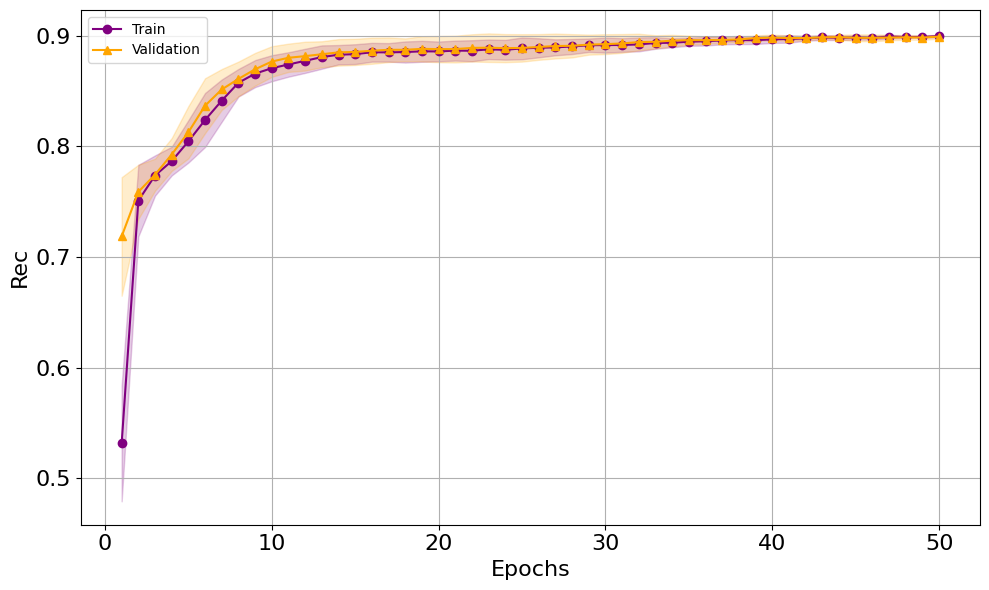

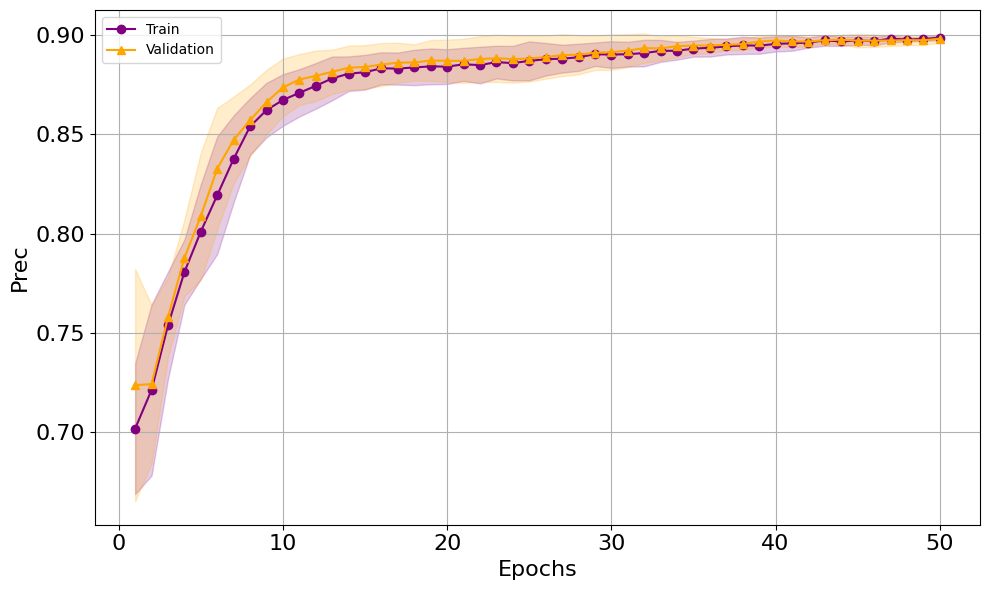

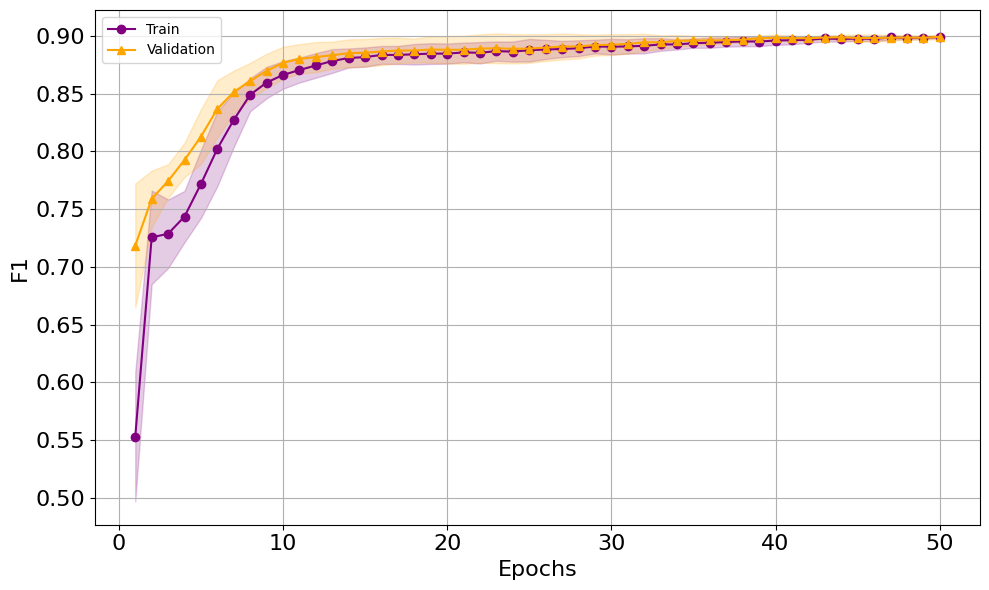

In [36]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}
import json

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range,  classical=False, save_name=f"{model_name}_mean_{metric}_curve")
    metrics_summary[metric] = summary

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_means_stds_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [55]:


best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")



Best fold: 1 with val_f1 = 0.9019


In [56]:
device = "cpu"
# test_cv_model = QuantumWrapper(n_qumodes=4, n_classes=2, hidden_dim=16).to(device)
# test_cv_model = QuantumLinear(n_qumodes=4, n_classes=2).to(device)
test_dv_model = DVQuantumLinear(4, n_classes).to(device)

# test_cv_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_model_best.pth"))
# test_cv_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{best_fold}_best.pth"))
# test_dv_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_dv_model.load_state_dict(torch.load(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_dv_model.to(device)

test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, dv_test_probs, dv_test_labels = evaluate_v2(test_dv_model, test_loader, optimizer, criterion, device)

test_metrics["acc"].append(test_acc)
test_metrics["loss"].append(test_loss)
test_metrics["rec"].append(test_rec)
test_metrics["prec"].append(test_prec)
test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_test_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_test_metrics.json", "w") as f:
    json.dump(test_metrics, f, indent=4)

Training | Epoch None: 100%|█| 20/20 [00:07<00:00,  2.84it/s, loss=0.3737, acc=0


Test loss: 0.3737 | Test acc: 0.8526 | Test rec: 0.8526 | Test prec: 0.8534 | Test f1: 0.8526


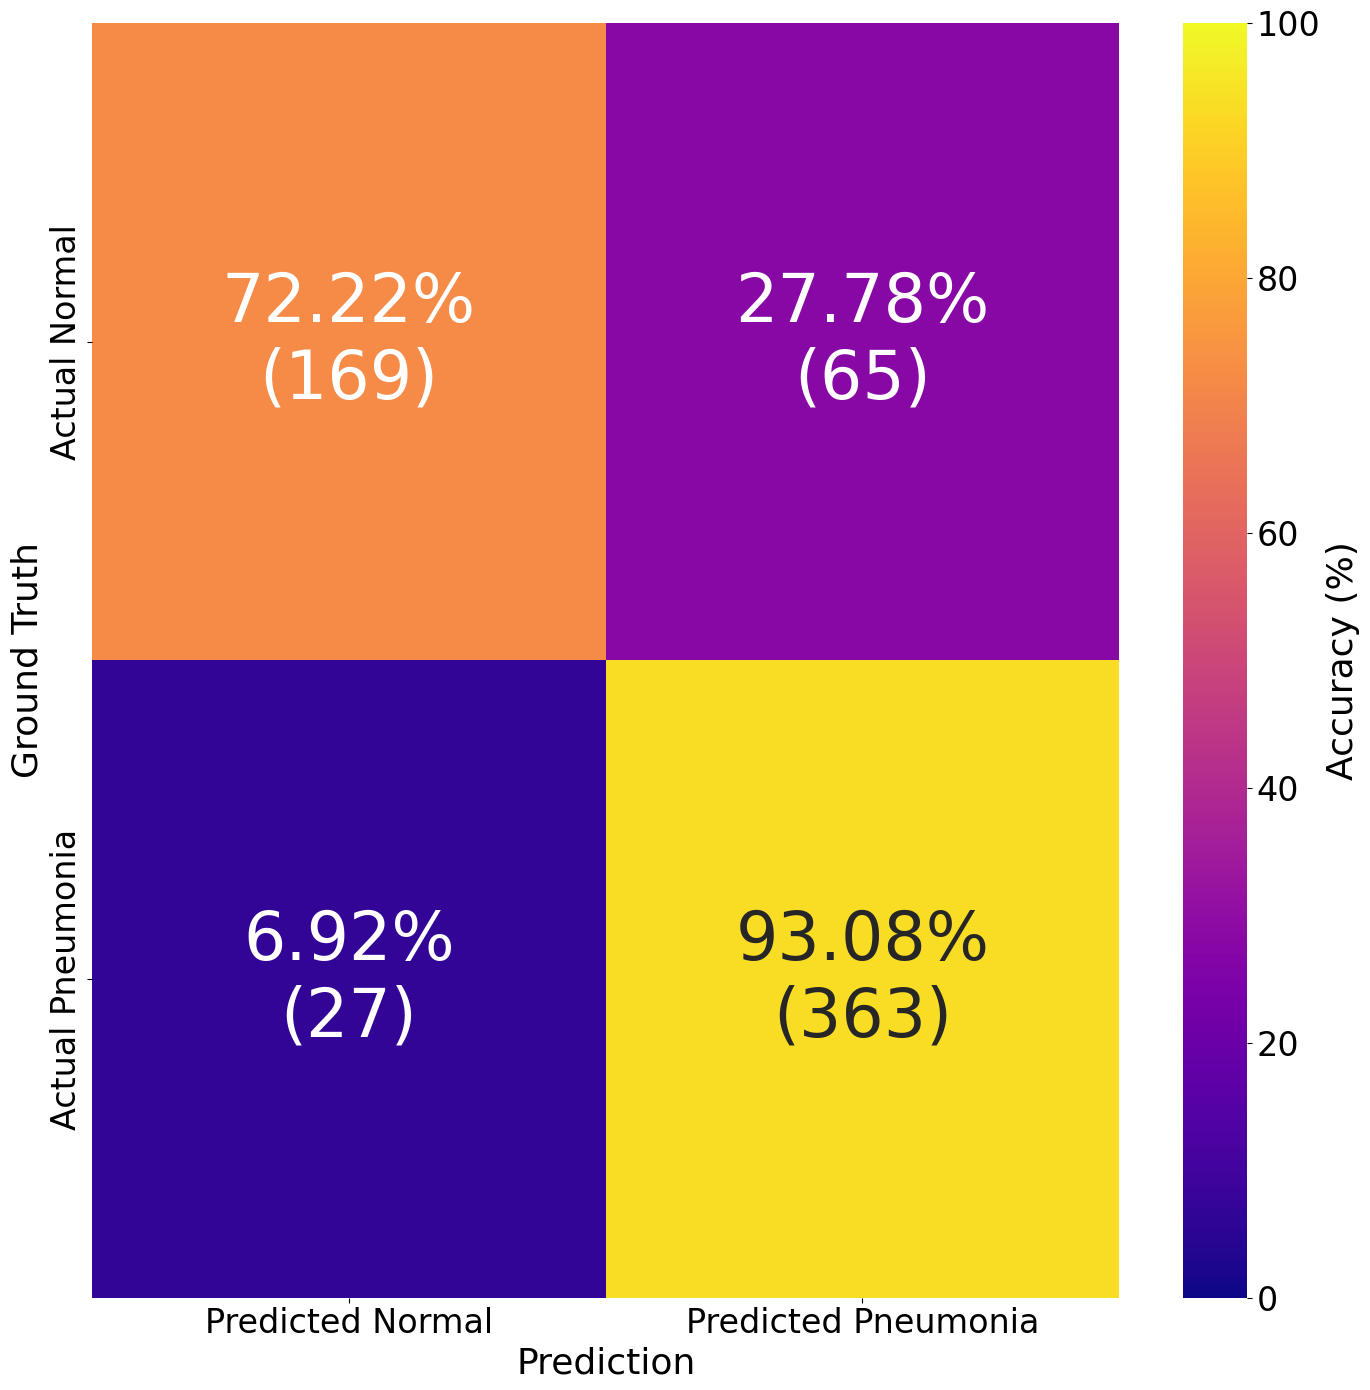

In [32]:
label_names = ["Normal", "Pneumonia"]

plot_confusion_matrix(dv_test_labels, test_preds, label_names, model_name, binary=True)

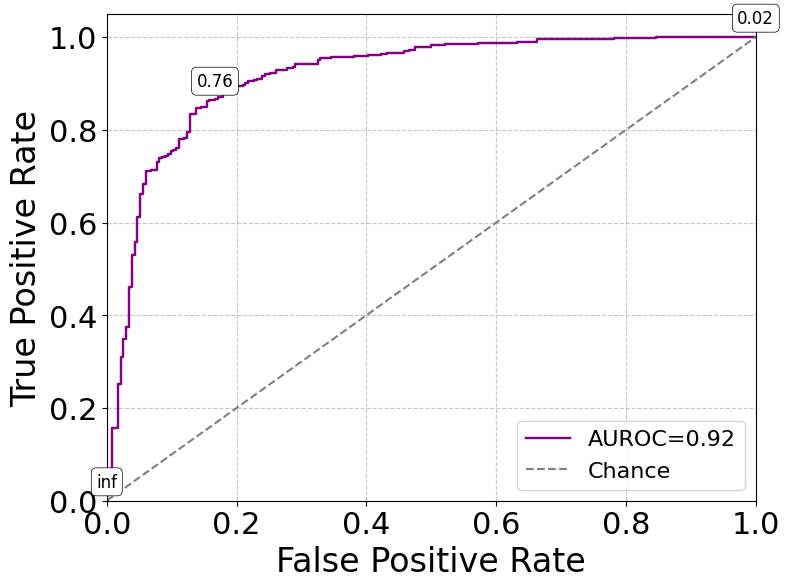

In [33]:
plot_auroc(dv_test_labels, dv_test_probs, model_name, binary=True)

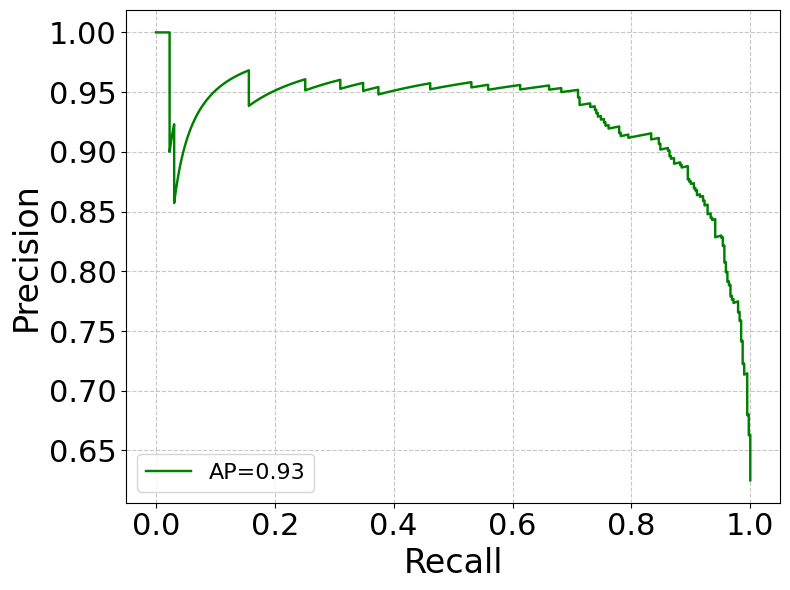

In [34]:
plot_prec(dv_test_labels, dv_test_probs, model_name, binary=True)

In [38]:
cam, outputs, predictions = gradcam_model(test_dv_model, x_test_tensor[0:16], quantum=True)
print(cam.shape)

torch.Size([16, 4])


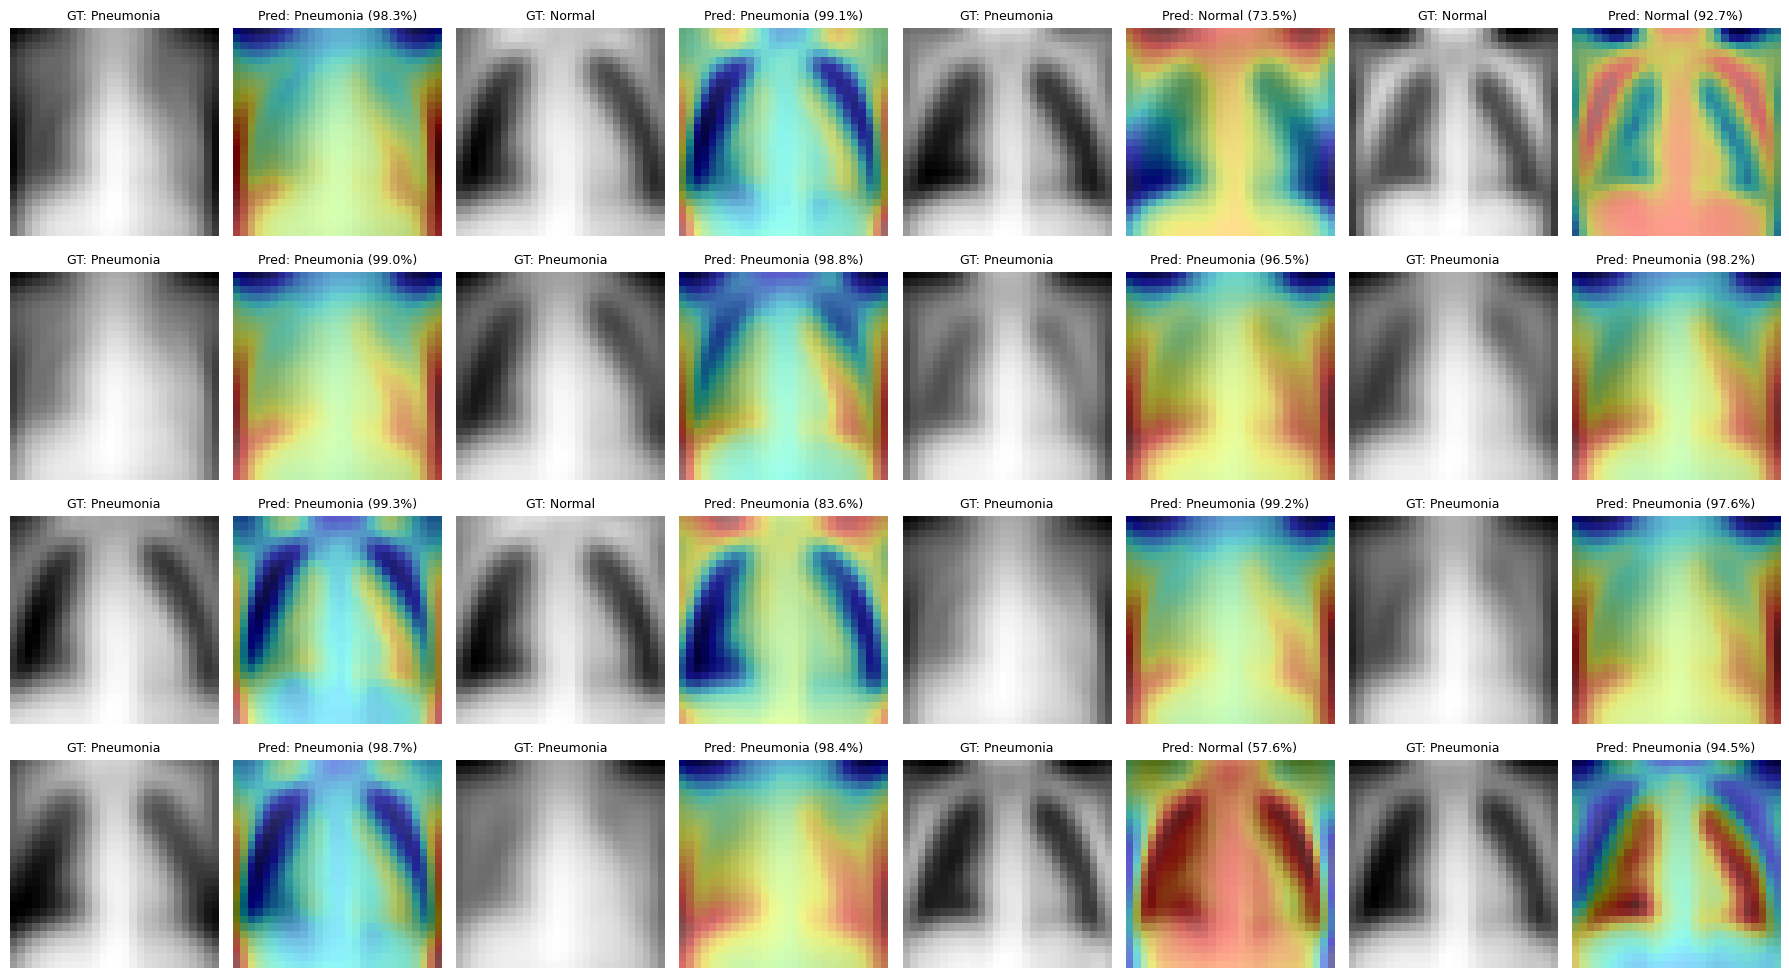

In [42]:
plot_reconstructed_heatmaps_with_predictions(
    samples = x_test_tensor[0:16].to(device),
    cam = cam,
    preds = predictions,
    probs = outputs,
    labels = y_test_tensor[0:16].to(device),
    encoder = encoder,
    class_names = label_names,
)

## CLASSICAL MODEL

In [57]:
epochs = 50
device = "cpu"
model_name = "classical_pneumonia"
classical_model = ClassicalModel()

optimizer = torch.optim.Adam(classical_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

from torchinfo import summary
summary(classical_model)

Layer (type:depth-idx)                   Param #
ClassicalModel                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       20
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       10
Total params: 30
Trainable params: 30
Non-trainable params: 0

In [44]:
run_kfold_training(ClassicalModel, train_dataset, optimizer, criterion, n_classes, model_name, device=device, classical=True, k=3, num_epochs=epochs, seed=42)


 Fold 1/3


Training: 100%|███████| 50/50 [00:00<00:00, 336.50it/s, loss=0.6367, acc=0.7140]


Train loss: 0.7360 | Train acc: 0.3872 | Train rec: 0.3872 | Train prec: 0.7599 | Train f1: 0.3489
Val loss: 0.6367 | Val acc: 0.7140 | Val rec: 0.7140 | Val prec: 0.8124 | Val f1: 0.7140


Training: 100%|███████| 50/50 [00:00<00:00, 332.32it/s, loss=0.4909, acc=0.8783]


Train loss: 0.5649 | Train acc: 0.8282 | Train rec: 0.8282 | Train prec: 0.8337 | Train f1: 0.8305
Val loss: 0.4909 | Val acc: 0.8783 | Val rec: 0.8783 | Val prec: 0.8753 | Val f1: 0.8783


Training: 100%|███████| 50/50 [00:00<00:00, 309.19it/s, loss=0.3899, acc=0.8847]


Train loss: 0.4396 | Train acc: 0.8722 | Train rec: 0.8722 | Train prec: 0.8705 | Train f1: 0.8646
Val loss: 0.3899 | Val acc: 0.8847 | Val rec: 0.8847 | Val prec: 0.8836 | Val f1: 0.8847


Training: 100%|███████| 50/50 [00:00<00:00, 340.57it/s, loss=0.3259, acc=0.8904]


Train loss: 0.3549 | Train acc: 0.8811 | Train rec: 0.8811 | Train prec: 0.8787 | Train f1: 0.8758
Val loss: 0.3259 | Val acc: 0.8904 | Val rec: 0.8904 | Val prec: 0.8885 | Val f1: 0.8904


Training: 100%|███████| 50/50 [00:00<00:00, 114.99it/s, loss=0.2887, acc=0.8911]


Train loss: 0.3031 | Train acc: 0.8904 | Train rec: 0.8904 | Train prec: 0.8878 | Train f1: 0.8875
Val loss: 0.2887 | Val acc: 0.8911 | Val rec: 0.8911 | Val prec: 0.8886 | Val f1: 0.8911


Training: 100%|███████| 50/50 [00:00<00:00, 336.93it/s, loss=0.2688, acc=0.8936]


Train loss: 0.2735 | Train acc: 0.8936 | Train rec: 0.8936 | Train prec: 0.8914 | Train f1: 0.8918
Val loss: 0.2688 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8913 | Val f1: 0.8936


Training: 100%|███████| 50/50 [00:00<00:00, 345.48it/s, loss=0.2580, acc=0.8924]


Train loss: 0.2572 | Train acc: 0.8948 | Train rec: 0.8948 | Train prec: 0.8929 | Train f1: 0.8934
Val loss: 0.2580 | Val acc: 0.8924 | Val rec: 0.8924 | Val prec: 0.8901 | Val f1: 0.8924


Training: 100%|███████| 50/50 [00:00<00:00, 348.84it/s, loss=0.2523, acc=0.8924]


Train loss: 0.2481 | Train acc: 0.8977 | Train rec: 0.8977 | Train prec: 0.8958 | Train f1: 0.8963
Val loss: 0.2523 | Val acc: 0.8924 | Val rec: 0.8924 | Val prec: 0.8901 | Val f1: 0.8924


Training: 100%|███████| 50/50 [00:00<00:00, 336.04it/s, loss=0.2489, acc=0.8885]


Train loss: 0.2422 | Train acc: 0.8987 | Train rec: 0.8987 | Train prec: 0.8970 | Train f1: 0.8974
Val loss: 0.2489 | Val acc: 0.8885 | Val rec: 0.8885 | Val prec: 0.8866 | Val f1: 0.8885


Training: 100%|███████| 50/50 [00:00<00:00, 331.40it/s, loss=0.2467, acc=0.8892]


Train loss: 0.2380 | Train acc: 0.8977 | Train rec: 0.8977 | Train prec: 0.8961 | Train f1: 0.8966
Val loss: 0.2467 | Val acc: 0.8892 | Val rec: 0.8892 | Val prec: 0.8875 | Val f1: 0.8892


Training: 100%|███████| 50/50 [00:00<00:00, 313.74it/s, loss=0.2452, acc=0.8904]


Train loss: 0.2352 | Train acc: 0.8993 | Train rec: 0.8993 | Train prec: 0.8978 | Train f1: 0.8983
Val loss: 0.2452 | Val acc: 0.8904 | Val rec: 0.8904 | Val prec: 0.8887 | Val f1: 0.8904


Training: 100%|███████| 50/50 [00:00<00:00, 322.22it/s, loss=0.2443, acc=0.8917]


Train loss: 0.2329 | Train acc: 0.8999 | Train rec: 0.8999 | Train prec: 0.8983 | Train f1: 0.8988
Val loss: 0.2443 | Val acc: 0.8917 | Val rec: 0.8917 | Val prec: 0.8900 | Val f1: 0.8917


Training: 100%|███████| 50/50 [00:00<00:00, 324.00it/s, loss=0.2436, acc=0.8936]


Train loss: 0.2311 | Train acc: 0.8990 | Train rec: 0.8990 | Train prec: 0.8975 | Train f1: 0.8980
Val loss: 0.2436 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8921 | Val f1: 0.8936


Training: 100%|███████| 50/50 [00:00<00:00, 254.17it/s, loss=0.2433, acc=0.8936]


Train loss: 0.2295 | Train acc: 0.9006 | Train rec: 0.9006 | Train prec: 0.8995 | Train f1: 0.9000
Val loss: 0.2433 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8923 | Val f1: 0.8936


Training: 100%|███████| 50/50 [00:00<00:00, 336.60it/s, loss=0.2430, acc=0.8943]


Train loss: 0.2286 | Train acc: 0.8999 | Train rec: 0.8999 | Train prec: 0.8983 | Train f1: 0.8988
Val loss: 0.2430 | Val acc: 0.8943 | Val rec: 0.8943 | Val prec: 0.8927 | Val f1: 0.8943


Training: 100%|███████| 50/50 [00:00<00:00, 328.83it/s, loss=0.2423, acc=0.8949]


Train loss: 0.2272 | Train acc: 0.9003 | Train rec: 0.9003 | Train prec: 0.8987 | Train f1: 0.8992
Val loss: 0.2423 | Val acc: 0.8949 | Val rec: 0.8949 | Val prec: 0.8936 | Val f1: 0.8949


Training: 100%|███████| 50/50 [00:00<00:00, 306.12it/s, loss=0.2415, acc=0.8955]


Train loss: 0.2261 | Train acc: 0.9022 | Train rec: 0.9022 | Train prec: 0.9007 | Train f1: 0.9011
Val loss: 0.2415 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8941 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 315.30it/s, loss=0.2408, acc=0.8943]


Train loss: 0.2250 | Train acc: 0.9028 | Train rec: 0.9028 | Train prec: 0.9014 | Train f1: 0.9019
Val loss: 0.2408 | Val acc: 0.8943 | Val rec: 0.8943 | Val prec: 0.8930 | Val f1: 0.8943


Training: 100%|███████| 50/50 [00:00<00:00, 324.09it/s, loss=0.2404, acc=0.8930]


Train loss: 0.2238 | Train acc: 0.9028 | Train rec: 0.9028 | Train prec: 0.9014 | Train f1: 0.9018
Val loss: 0.2404 | Val acc: 0.8930 | Val rec: 0.8930 | Val prec: 0.8918 | Val f1: 0.8930


Training: 100%|███████| 50/50 [00:00<00:00, 334.32it/s, loss=0.2400, acc=0.8955]


Train loss: 0.2230 | Train acc: 0.9038 | Train rec: 0.9038 | Train prec: 0.9027 | Train f1: 0.9031
Val loss: 0.2400 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8943 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 348.79it/s, loss=0.2396, acc=0.8962]


Train loss: 0.2220 | Train acc: 0.9022 | Train rec: 0.9022 | Train prec: 0.9006 | Train f1: 0.9011
Val loss: 0.2396 | Val acc: 0.8962 | Val rec: 0.8962 | Val prec: 0.8949 | Val f1: 0.8962


Training: 100%|███████| 50/50 [00:00<00:00, 305.38it/s, loss=0.2396, acc=0.8968]


Train loss: 0.2215 | Train acc: 0.9034 | Train rec: 0.9034 | Train prec: 0.9019 | Train f1: 0.9024
Val loss: 0.2396 | Val acc: 0.8968 | Val rec: 0.8968 | Val prec: 0.8956 | Val f1: 0.8968


Training: 100%|███████| 50/50 [00:00<00:00, 275.59it/s, loss=0.2392, acc=0.8949]


Train loss: 0.2205 | Train acc: 0.9031 | Train rec: 0.9031 | Train prec: 0.9020 | Train f1: 0.9024
Val loss: 0.2392 | Val acc: 0.8949 | Val rec: 0.8949 | Val prec: 0.8936 | Val f1: 0.8949


Training: 100%|███████| 50/50 [00:00<00:00, 292.55it/s, loss=0.2387, acc=0.8962]


Train loss: 0.2195 | Train acc: 0.9057 | Train rec: 0.9057 | Train prec: 0.9044 | Train f1: 0.9048
Val loss: 0.2387 | Val acc: 0.8962 | Val rec: 0.8962 | Val prec: 0.8950 | Val f1: 0.8962


Training: 100%|███████| 50/50 [00:00<00:00, 299.18it/s, loss=0.2381, acc=0.8943]


Train loss: 0.2188 | Train acc: 0.9066 | Train rec: 0.9066 | Train prec: 0.9053 | Train f1: 0.9057
Val loss: 0.2381 | Val acc: 0.8943 | Val rec: 0.8943 | Val prec: 0.8929 | Val f1: 0.8943


Training: 100%|███████| 50/50 [00:00<00:00, 320.85it/s, loss=0.2382, acc=0.8930]


Train loss: 0.2182 | Train acc: 0.9076 | Train rec: 0.9076 | Train prec: 0.9064 | Train f1: 0.9068
Val loss: 0.2382 | Val acc: 0.8930 | Val rec: 0.8930 | Val prec: 0.8917 | Val f1: 0.8930


Training: 100%|███████| 50/50 [00:00<00:00, 289.52it/s, loss=0.2382, acc=0.8943]


Train loss: 0.2175 | Train acc: 0.9076 | Train rec: 0.9076 | Train prec: 0.9064 | Train f1: 0.9068
Val loss: 0.2382 | Val acc: 0.8943 | Val rec: 0.8943 | Val prec: 0.8931 | Val f1: 0.8943


Training: 100%|███████| 50/50 [00:00<00:00, 297.78it/s, loss=0.2382, acc=0.8943]


Train loss: 0.2169 | Train acc: 0.9079 | Train rec: 0.9079 | Train prec: 0.9067 | Train f1: 0.9071
Val loss: 0.2382 | Val acc: 0.8943 | Val rec: 0.8943 | Val prec: 0.8932 | Val f1: 0.8943


Training: 100%|███████| 50/50 [00:00<00:00, 312.80it/s, loss=0.2381, acc=0.8943]


Train loss: 0.2165 | Train acc: 0.9085 | Train rec: 0.9085 | Train prec: 0.9074 | Train f1: 0.9078
Val loss: 0.2381 | Val acc: 0.8943 | Val rec: 0.8943 | Val prec: 0.8932 | Val f1: 0.8943


Training: 100%|███████| 50/50 [00:00<00:00, 294.43it/s, loss=0.2383, acc=0.8968]


Train loss: 0.2160 | Train acc: 0.9082 | Train rec: 0.9082 | Train prec: 0.9071 | Train f1: 0.9075
Val loss: 0.2383 | Val acc: 0.8968 | Val rec: 0.8968 | Val prec: 0.8961 | Val f1: 0.8968


Training: 100%|███████| 50/50 [00:00<00:00, 285.52it/s, loss=0.2382, acc=0.8949]


Train loss: 0.2154 | Train acc: 0.9079 | Train rec: 0.9079 | Train prec: 0.9070 | Train f1: 0.9074
Val loss: 0.2382 | Val acc: 0.8949 | Val rec: 0.8949 | Val prec: 0.8939 | Val f1: 0.8949


Training: 100%|███████| 50/50 [00:00<00:00, 193.34it/s, loss=0.2383, acc=0.8955]


Train loss: 0.2153 | Train acc: 0.9085 | Train rec: 0.9085 | Train prec: 0.9076 | Train f1: 0.9079
Val loss: 0.2383 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8946 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 277.93it/s, loss=0.2381, acc=0.8955]


Train loss: 0.2146 | Train acc: 0.9089 | Train rec: 0.9089 | Train prec: 0.9077 | Train f1: 0.9081
Val loss: 0.2381 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8944 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 300.71it/s, loss=0.2380, acc=0.8943]


Train loss: 0.2144 | Train acc: 0.9089 | Train rec: 0.9089 | Train prec: 0.9077 | Train f1: 0.9081
Val loss: 0.2380 | Val acc: 0.8943 | Val rec: 0.8943 | Val prec: 0.8930 | Val f1: 0.8943


Training: 100%|███████| 50/50 [00:00<00:00, 291.27it/s, loss=0.2379, acc=0.8936]


Train loss: 0.2140 | Train acc: 0.9111 | Train rec: 0.9111 | Train prec: 0.9100 | Train f1: 0.9104
Val loss: 0.2379 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8926 | Val f1: 0.8936


Training: 100%|███████| 50/50 [00:00<00:00, 296.68it/s, loss=0.2379, acc=0.8955]


Train loss: 0.2137 | Train acc: 0.9114 | Train rec: 0.9114 | Train prec: 0.9105 | Train f1: 0.9108
Val loss: 0.2379 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8948 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 293.75it/s, loss=0.2378, acc=0.8911]


Train loss: 0.2135 | Train acc: 0.9124 | Train rec: 0.9124 | Train prec: 0.9115 | Train f1: 0.9118
Val loss: 0.2378 | Val acc: 0.8911 | Val rec: 0.8911 | Val prec: 0.8897 | Val f1: 0.8911


Training: 100%|███████| 50/50 [00:00<00:00, 204.62it/s, loss=0.2380, acc=0.8955]


Train loss: 0.2134 | Train acc: 0.9124 | Train rec: 0.9124 | Train prec: 0.9118 | Train f1: 0.9120
Val loss: 0.2380 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8948 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 288.18it/s, loss=0.2380, acc=0.8955]


Train loss: 0.2128 | Train acc: 0.9133 | Train rec: 0.9133 | Train prec: 0.9126 | Train f1: 0.9129
Val loss: 0.2380 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8948 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 282.55it/s, loss=0.2381, acc=0.8955]


Train loss: 0.2125 | Train acc: 0.9136 | Train rec: 0.9136 | Train prec: 0.9130 | Train f1: 0.9133
Val loss: 0.2381 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8951 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 281.93it/s, loss=0.2379, acc=0.8955]


Train loss: 0.2123 | Train acc: 0.9136 | Train rec: 0.9136 | Train prec: 0.9129 | Train f1: 0.9132
Val loss: 0.2379 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8946 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 288.56it/s, loss=0.2380, acc=0.8962]


Train loss: 0.2121 | Train acc: 0.9127 | Train rec: 0.9127 | Train prec: 0.9119 | Train f1: 0.9122
Val loss: 0.2380 | Val acc: 0.8962 | Val rec: 0.8962 | Val prec: 0.8953 | Val f1: 0.8962


Training: 100%|███████| 50/50 [00:00<00:00, 291.79it/s, loss=0.2380, acc=0.8949]


Train loss: 0.2117 | Train acc: 0.9130 | Train rec: 0.9130 | Train prec: 0.9122 | Train f1: 0.9126
Val loss: 0.2380 | Val acc: 0.8949 | Val rec: 0.8949 | Val prec: 0.8943 | Val f1: 0.8949


Training: 100%|███████| 50/50 [00:00<00:00, 308.59it/s, loss=0.2379, acc=0.8943]


Train loss: 0.2115 | Train acc: 0.9136 | Train rec: 0.9136 | Train prec: 0.9129 | Train f1: 0.9132
Val loss: 0.2379 | Val acc: 0.8943 | Val rec: 0.8943 | Val prec: 0.8935 | Val f1: 0.8943


Training: 100%|███████| 50/50 [00:00<00:00, 303.04it/s, loss=0.2379, acc=0.8936]


Train loss: 0.2114 | Train acc: 0.9127 | Train rec: 0.9127 | Train prec: 0.9120 | Train f1: 0.9123
Val loss: 0.2379 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8929 | Val f1: 0.8936


Training: 100%|███████| 50/50 [00:00<00:00, 313.87it/s, loss=0.2380, acc=0.8936]


Train loss: 0.2111 | Train acc: 0.9120 | Train rec: 0.9120 | Train prec: 0.9113 | Train f1: 0.9116
Val loss: 0.2380 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8929 | Val f1: 0.8936


Training: 100%|███████| 50/50 [00:00<00:00, 301.24it/s, loss=0.2379, acc=0.8936]


Train loss: 0.2109 | Train acc: 0.9127 | Train rec: 0.9127 | Train prec: 0.9117 | Train f1: 0.9121
Val loss: 0.2379 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8929 | Val f1: 0.8936


Training: 100%|███████| 50/50 [00:00<00:00, 297.38it/s, loss=0.2378, acc=0.8936]


Train loss: 0.2107 | Train acc: 0.9120 | Train rec: 0.9120 | Train prec: 0.9113 | Train f1: 0.9116
Val loss: 0.2378 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8929 | Val f1: 0.8936


Training: 100%|███████| 50/50 [00:00<00:00, 292.95it/s, loss=0.2379, acc=0.8924]


Train loss: 0.2105 | Train acc: 0.9117 | Train rec: 0.9117 | Train prec: 0.9111 | Train f1: 0.9113
Val loss: 0.2379 | Val acc: 0.8924 | Val rec: 0.8924 | Val prec: 0.8918 | Val f1: 0.8924


Training: 100%|███████| 50/50 [00:00<00:00, 306.74it/s, loss=0.2379, acc=0.8924]


Train loss: 0.2103 | Train acc: 0.9105 | Train rec: 0.9105 | Train prec: 0.9100 | Train f1: 0.9102
Val loss: 0.2379 | Val acc: 0.8924 | Val rec: 0.8924 | Val prec: 0.8918 | Val f1: 0.8924

 Fold 2/3


Training: 100%|███████| 50/50 [00:00<00:00, 293.39it/s, loss=0.5813, acc=0.7425]


Train loss: 0.6117 | Train acc: 0.7420 | Train rec: 0.7420 | Train prec: 0.5505 | Train f1: 0.6320
Val loss: 0.5813 | Val acc: 0.7425 | Val rec: 0.7425 | Val prec: 0.5513 | Val f1: 0.7425


Training: 100%|███████| 50/50 [00:00<00:00, 297.80it/s, loss=0.5006, acc=0.7425]


Train loss: 0.5440 | Train acc: 0.7420 | Train rec: 0.7420 | Train prec: 0.5505 | Train f1: 0.6320
Val loss: 0.5006 | Val acc: 0.7425 | Val rec: 0.7425 | Val prec: 0.5513 | Val f1: 0.7425


Training: 100%|███████| 50/50 [00:00<00:00, 284.92it/s, loss=0.3970, acc=0.8088]


Train loss: 0.4503 | Train acc: 0.7627 | Train rec: 0.7627 | Train prec: 0.8097 | Train f1: 0.6794
Val loss: 0.3970 | Val acc: 0.8088 | Val rec: 0.8088 | Val prec: 0.8438 | Val f1: 0.8088


Training: 100%|███████| 50/50 [00:00<00:00, 304.56it/s, loss=0.3156, acc=0.8795]


Train loss: 0.3584 | Train acc: 0.8509 | Train rec: 0.8509 | Train prec: 0.8593 | Train f1: 0.8329
Val loss: 0.3156 | Val acc: 0.8795 | Val rec: 0.8795 | Val prec: 0.8852 | Val f1: 0.8795


Training: 100%|███████| 50/50 [00:00<00:00, 292.94it/s, loss=0.2676, acc=0.8942]


Train loss: 0.2974 | Train acc: 0.8907 | Train rec: 0.8907 | Train prec: 0.8895 | Train f1: 0.8857
Val loss: 0.2676 | Val acc: 0.8942 | Val rec: 0.8942 | Val prec: 0.8938 | Val f1: 0.8942


Training: 100%|███████| 50/50 [00:00<00:00, 290.73it/s, loss=0.2422, acc=0.9082]


Train loss: 0.2655 | Train acc: 0.8958 | Train rec: 0.8958 | Train prec: 0.8935 | Train f1: 0.8932
Val loss: 0.2422 | Val acc: 0.9082 | Val rec: 0.9082 | Val prec: 0.9070 | Val f1: 0.9082


Training: 100%|███████| 50/50 [00:00<00:00, 283.14it/s, loss=0.2281, acc=0.9076]


Train loss: 0.2490 | Train acc: 0.8974 | Train rec: 0.8974 | Train prec: 0.8953 | Train f1: 0.8955
Val loss: 0.2281 | Val acc: 0.9076 | Val rec: 0.9076 | Val prec: 0.9060 | Val f1: 0.9076


Training: 100%|███████| 50/50 [00:00<00:00, 297.96it/s, loss=0.2201, acc=0.9095]


Train loss: 0.2403 | Train acc: 0.8987 | Train rec: 0.8987 | Train prec: 0.8969 | Train f1: 0.8973
Val loss: 0.2201 | Val acc: 0.9095 | Val rec: 0.9095 | Val prec: 0.9079 | Val f1: 0.9095


Training: 100%|███████| 50/50 [00:00<00:00, 307.74it/s, loss=0.2155, acc=0.9101]


Train loss: 0.2359 | Train acc: 0.8996 | Train rec: 0.8996 | Train prec: 0.8980 | Train f1: 0.8985
Val loss: 0.2155 | Val acc: 0.9101 | Val rec: 0.9101 | Val prec: 0.9085 | Val f1: 0.9101


Training: 100%|███████| 50/50 [00:00<00:00, 273.33it/s, loss=0.2124, acc=0.9089]


Train loss: 0.2329 | Train acc: 0.8990 | Train rec: 0.8990 | Train prec: 0.8974 | Train f1: 0.8979
Val loss: 0.2124 | Val acc: 0.9089 | Val rec: 0.9089 | Val prec: 0.9072 | Val f1: 0.9089


Training: 100%|███████| 50/50 [00:00<00:00, 288.09it/s, loss=0.2106, acc=0.9101]


Train loss: 0.2312 | Train acc: 0.9003 | Train rec: 0.9003 | Train prec: 0.8992 | Train f1: 0.8996
Val loss: 0.2106 | Val acc: 0.9101 | Val rec: 0.9101 | Val prec: 0.9085 | Val f1: 0.9101


Training: 100%|███████| 50/50 [00:00<00:00, 305.66it/s, loss=0.2091, acc=0.9108]


Train loss: 0.2301 | Train acc: 0.9003 | Train rec: 0.9003 | Train prec: 0.8991 | Train f1: 0.8995
Val loss: 0.2091 | Val acc: 0.9108 | Val rec: 0.9108 | Val prec: 0.9092 | Val f1: 0.9108


Training: 100%|███████| 50/50 [00:00<00:00, 295.45it/s, loss=0.2082, acc=0.9108]


Train loss: 0.2293 | Train acc: 0.8996 | Train rec: 0.8996 | Train prec: 0.8983 | Train f1: 0.8987
Val loss: 0.2082 | Val acc: 0.9108 | Val rec: 0.9108 | Val prec: 0.9092 | Val f1: 0.9108


Training: 100%|███████| 50/50 [00:00<00:00, 290.29it/s, loss=0.2071, acc=0.9101]


Train loss: 0.2289 | Train acc: 0.8993 | Train rec: 0.8993 | Train prec: 0.8979 | Train f1: 0.8984
Val loss: 0.2071 | Val acc: 0.9101 | Val rec: 0.9101 | Val prec: 0.9085 | Val f1: 0.9101


Training: 100%|███████| 50/50 [00:00<00:00, 294.29it/s, loss=0.2067, acc=0.9108]


Train loss: 0.2283 | Train acc: 0.8987 | Train rec: 0.8987 | Train prec: 0.8972 | Train f1: 0.8977
Val loss: 0.2067 | Val acc: 0.9108 | Val rec: 0.9108 | Val prec: 0.9092 | Val f1: 0.9108


Training: 100%|███████| 50/50 [00:00<00:00, 212.63it/s, loss=0.2056, acc=0.9095]


Train loss: 0.2278 | Train acc: 0.8984 | Train rec: 0.8984 | Train prec: 0.8971 | Train f1: 0.8976
Val loss: 0.2056 | Val acc: 0.9095 | Val rec: 0.9095 | Val prec: 0.9078 | Val f1: 0.9095


Training: 100%|███████| 50/50 [00:00<00:00, 222.22it/s, loss=0.2050, acc=0.9095]


Train loss: 0.2275 | Train acc: 0.9012 | Train rec: 0.9012 | Train prec: 0.8999 | Train f1: 0.9003
Val loss: 0.2050 | Val acc: 0.9095 | Val rec: 0.9095 | Val prec: 0.9079 | Val f1: 0.9095


Training: 100%|███████| 50/50 [00:00<00:00, 216.87it/s, loss=0.2047, acc=0.9082]


Train loss: 0.2273 | Train acc: 0.8993 | Train rec: 0.8993 | Train prec: 0.8981 | Train f1: 0.8985
Val loss: 0.2047 | Val acc: 0.9082 | Val rec: 0.9082 | Val prec: 0.9067 | Val f1: 0.9082


Training: 100%|███████| 50/50 [00:00<00:00, 223.92it/s, loss=0.2042, acc=0.9069]


Train loss: 0.2269 | Train acc: 0.8984 | Train rec: 0.8984 | Train prec: 0.8972 | Train f1: 0.8977
Val loss: 0.2042 | Val acc: 0.9069 | Val rec: 0.9069 | Val prec: 0.9053 | Val f1: 0.9069


Training: 100%|███████| 50/50 [00:00<00:00, 218.01it/s, loss=0.2039, acc=0.9095]


Train loss: 0.2268 | Train acc: 0.8987 | Train rec: 0.8987 | Train prec: 0.8974 | Train f1: 0.8979
Val loss: 0.2039 | Val acc: 0.9095 | Val rec: 0.9095 | Val prec: 0.9080 | Val f1: 0.9095


Training: 100%|███████| 50/50 [00:00<00:00, 217.54it/s, loss=0.2033, acc=0.9101]


Train loss: 0.2267 | Train acc: 0.8993 | Train rec: 0.8993 | Train prec: 0.8984 | Train f1: 0.8988
Val loss: 0.2033 | Val acc: 0.9101 | Val rec: 0.9101 | Val prec: 0.9087 | Val f1: 0.9101


Training: 100%|███████| 50/50 [00:00<00:00, 224.36it/s, loss=0.2042, acc=0.9108]


Train loss: 0.2261 | Train acc: 0.9003 | Train rec: 0.9003 | Train prec: 0.8989 | Train f1: 0.8994
Val loss: 0.2042 | Val acc: 0.9108 | Val rec: 0.9108 | Val prec: 0.9092 | Val f1: 0.9108


Training: 100%|███████| 50/50 [00:00<00:00, 208.90it/s, loss=0.2037, acc=0.9108]


Train loss: 0.2259 | Train acc: 0.8990 | Train rec: 0.8990 | Train prec: 0.8977 | Train f1: 0.8981
Val loss: 0.2037 | Val acc: 0.9108 | Val rec: 0.9108 | Val prec: 0.9092 | Val f1: 0.9108


Training: 100%|███████| 50/50 [00:00<00:00, 216.69it/s, loss=0.2032, acc=0.9101]


Train loss: 0.2259 | Train acc: 0.8993 | Train rec: 0.8993 | Train prec: 0.8980 | Train f1: 0.8984
Val loss: 0.2032 | Val acc: 0.9101 | Val rec: 0.9101 | Val prec: 0.9086 | Val f1: 0.9101


Training: 100%|███████| 50/50 [00:00<00:00, 211.89it/s, loss=0.2036, acc=0.9101]


Train loss: 0.2258 | Train acc: 0.8984 | Train rec: 0.8984 | Train prec: 0.8973 | Train f1: 0.8978
Val loss: 0.2036 | Val acc: 0.9101 | Val rec: 0.9101 | Val prec: 0.9086 | Val f1: 0.9101


Training: 100%|███████| 50/50 [00:00<00:00, 213.65it/s, loss=0.2031, acc=0.9095]


Train loss: 0.2254 | Train acc: 0.8996 | Train rec: 0.8996 | Train prec: 0.8985 | Train f1: 0.8989
Val loss: 0.2031 | Val acc: 0.9095 | Val rec: 0.9095 | Val prec: 0.9080 | Val f1: 0.9095


Training: 100%|███████| 50/50 [00:00<00:00, 229.18it/s, loss=0.2027, acc=0.9101]


Train loss: 0.2253 | Train acc: 0.9003 | Train rec: 0.9003 | Train prec: 0.8990 | Train f1: 0.8994
Val loss: 0.2027 | Val acc: 0.9101 | Val rec: 0.9101 | Val prec: 0.9087 | Val f1: 0.9101


Training: 100%|███████| 50/50 [00:00<00:00, 215.15it/s, loss=0.2032, acc=0.9101]


Train loss: 0.2252 | Train acc: 0.8990 | Train rec: 0.8990 | Train prec: 0.8980 | Train f1: 0.8984
Val loss: 0.2032 | Val acc: 0.9101 | Val rec: 0.9101 | Val prec: 0.9086 | Val f1: 0.9101


Training: 100%|███████| 50/50 [00:00<00:00, 217.39it/s, loss=0.2032, acc=0.9089]


Train loss: 0.2252 | Train acc: 0.9009 | Train rec: 0.9009 | Train prec: 0.8996 | Train f1: 0.9000
Val loss: 0.2032 | Val acc: 0.9089 | Val rec: 0.9089 | Val prec: 0.9072 | Val f1: 0.9089


Training: 100%|███████| 50/50 [00:00<00:00, 220.24it/s, loss=0.2028, acc=0.9089]


Train loss: 0.2249 | Train acc: 0.9009 | Train rec: 0.9009 | Train prec: 0.8997 | Train f1: 0.9002
Val loss: 0.2028 | Val acc: 0.9089 | Val rec: 0.9089 | Val prec: 0.9073 | Val f1: 0.9089


Training: 100%|███████| 50/50 [00:00<00:00, 218.44it/s, loss=0.2027, acc=0.9101]


Train loss: 0.2251 | Train acc: 0.9000 | Train rec: 0.9000 | Train prec: 0.8987 | Train f1: 0.8992
Val loss: 0.2027 | Val acc: 0.9101 | Val rec: 0.9101 | Val prec: 0.9086 | Val f1: 0.9101


Training: 100%|███████| 50/50 [00:00<00:00, 239.12it/s, loss=0.2030, acc=0.9095]


Train loss: 0.2250 | Train acc: 0.9012 | Train rec: 0.9012 | Train prec: 0.9002 | Train f1: 0.9006
Val loss: 0.2030 | Val acc: 0.9095 | Val rec: 0.9095 | Val prec: 0.9080 | Val f1: 0.9095


Training: 100%|███████| 50/50 [00:00<00:00, 221.84it/s, loss=0.2027, acc=0.9101]


Train loss: 0.2246 | Train acc: 0.9012 | Train rec: 0.9012 | Train prec: 0.9000 | Train f1: 0.9005
Val loss: 0.2027 | Val acc: 0.9101 | Val rec: 0.9101 | Val prec: 0.9086 | Val f1: 0.9101


Training: 100%|███████| 50/50 [00:00<00:00, 214.35it/s, loss=0.2025, acc=0.9101]


Train loss: 0.2246 | Train acc: 0.9019 | Train rec: 0.9019 | Train prec: 0.9007 | Train f1: 0.9011
Val loss: 0.2025 | Val acc: 0.9101 | Val rec: 0.9101 | Val prec: 0.9086 | Val f1: 0.9101


Training: 100%|███████| 50/50 [00:00<00:00, 209.82it/s, loss=0.2024, acc=0.9095]


Train loss: 0.2245 | Train acc: 0.9009 | Train rec: 0.9009 | Train prec: 0.8999 | Train f1: 0.9003
Val loss: 0.2024 | Val acc: 0.9095 | Val rec: 0.9095 | Val prec: 0.9080 | Val f1: 0.9095


Training: 100%|███████| 50/50 [00:00<00:00, 219.08it/s, loss=0.2023, acc=0.9095]


Train loss: 0.2243 | Train acc: 0.9012 | Train rec: 0.9012 | Train prec: 0.9002 | Train f1: 0.9006
Val loss: 0.2023 | Val acc: 0.9095 | Val rec: 0.9095 | Val prec: 0.9079 | Val f1: 0.9095


Training: 100%|███████| 50/50 [00:00<00:00, 214.95it/s, loss=0.2026, acc=0.9095]


Train loss: 0.2245 | Train acc: 0.8996 | Train rec: 0.8996 | Train prec: 0.8980 | Train f1: 0.8985
Val loss: 0.2026 | Val acc: 0.9095 | Val rec: 0.9095 | Val prec: 0.9079 | Val f1: 0.9095


Training: 100%|███████| 50/50 [00:00<00:00, 214.58it/s, loss=0.2023, acc=0.9089]


Train loss: 0.2243 | Train acc: 0.9009 | Train rec: 0.9009 | Train prec: 0.8997 | Train f1: 0.9001
Val loss: 0.2023 | Val acc: 0.9089 | Val rec: 0.9089 | Val prec: 0.9073 | Val f1: 0.9089


Training: 100%|███████| 50/50 [00:00<00:00, 281.29it/s, loss=0.2024, acc=0.9095]


Train loss: 0.2242 | Train acc: 0.9009 | Train rec: 0.9009 | Train prec: 0.8997 | Train f1: 0.9002
Val loss: 0.2024 | Val acc: 0.9095 | Val rec: 0.9095 | Val prec: 0.9079 | Val f1: 0.9095


Training: 100%|███████| 50/50 [00:00<00:00, 287.41it/s, loss=0.2019, acc=0.9089]


Train loss: 0.2241 | Train acc: 0.9019 | Train rec: 0.9019 | Train prec: 0.9008 | Train f1: 0.9012
Val loss: 0.2019 | Val acc: 0.9089 | Val rec: 0.9089 | Val prec: 0.9073 | Val f1: 0.9089


Training: 100%|███████| 50/50 [00:00<00:00, 294.04it/s, loss=0.2018, acc=0.9114]


Train loss: 0.2242 | Train acc: 0.9006 | Train rec: 0.9006 | Train prec: 0.8996 | Train f1: 0.9000
Val loss: 0.2018 | Val acc: 0.9114 | Val rec: 0.9114 | Val prec: 0.9101 | Val f1: 0.9114


Training: 100%|███████| 50/50 [00:00<00:00, 295.75it/s, loss=0.2021, acc=0.9095]


Train loss: 0.2240 | Train acc: 0.9006 | Train rec: 0.9006 | Train prec: 0.8993 | Train f1: 0.8997
Val loss: 0.2021 | Val acc: 0.9095 | Val rec: 0.9095 | Val prec: 0.9079 | Val f1: 0.9095


Training: 100%|███████| 50/50 [00:00<00:00, 286.41it/s, loss=0.2019, acc=0.9095]


Train loss: 0.2239 | Train acc: 0.9019 | Train rec: 0.9019 | Train prec: 0.9008 | Train f1: 0.9012
Val loss: 0.2019 | Val acc: 0.9095 | Val rec: 0.9095 | Val prec: 0.9079 | Val f1: 0.9095


Training: 100%|███████| 50/50 [00:00<00:00, 284.34it/s, loss=0.2019, acc=0.9101]


Train loss: 0.2241 | Train acc: 0.9012 | Train rec: 0.9012 | Train prec: 0.8997 | Train f1: 0.9002
Val loss: 0.2019 | Val acc: 0.9101 | Val rec: 0.9101 | Val prec: 0.9086 | Val f1: 0.9101


Training: 100%|███████| 50/50 [00:00<00:00, 269.98it/s, loss=0.2020, acc=0.9108]


Train loss: 0.2240 | Train acc: 0.9022 | Train rec: 0.9022 | Train prec: 0.9012 | Train f1: 0.9016
Val loss: 0.2020 | Val acc: 0.9108 | Val rec: 0.9108 | Val prec: 0.9092 | Val f1: 0.9108


Training: 100%|███████| 50/50 [00:00<00:00, 305.30it/s, loss=0.2018, acc=0.9108]


Train loss: 0.2239 | Train acc: 0.9009 | Train rec: 0.9009 | Train prec: 0.8997 | Train f1: 0.9001
Val loss: 0.2018 | Val acc: 0.9108 | Val rec: 0.9108 | Val prec: 0.9093 | Val f1: 0.9108


Training: 100%|███████| 50/50 [00:00<00:00, 283.89it/s, loss=0.2022, acc=0.9120]


Train loss: 0.2238 | Train acc: 0.9003 | Train rec: 0.9003 | Train prec: 0.8993 | Train f1: 0.8997
Val loss: 0.2022 | Val acc: 0.9120 | Val rec: 0.9120 | Val prec: 0.9106 | Val f1: 0.9120


Training: 100%|███████| 50/50 [00:00<00:00, 264.58it/s, loss=0.2020, acc=0.9120]


Train loss: 0.2239 | Train acc: 0.9006 | Train rec: 0.9006 | Train prec: 0.8991 | Train f1: 0.8996
Val loss: 0.2020 | Val acc: 0.9120 | Val rec: 0.9120 | Val prec: 0.9106 | Val f1: 0.9120


Training: 100%|███████| 50/50 [00:00<00:00, 280.05it/s, loss=0.2015, acc=0.9127]


Train loss: 0.2237 | Train acc: 0.9009 | Train rec: 0.9009 | Train prec: 0.8998 | Train f1: 0.9002
Val loss: 0.2015 | Val acc: 0.9127 | Val rec: 0.9127 | Val prec: 0.9114 | Val f1: 0.9127


Training: 100%|███████| 50/50 [00:00<00:00, 268.78it/s, loss=0.2015, acc=0.9114]


Train loss: 0.2236 | Train acc: 0.9006 | Train rec: 0.9006 | Train prec: 0.8995 | Train f1: 0.8999
Val loss: 0.2015 | Val acc: 0.9114 | Val rec: 0.9114 | Val prec: 0.9100 | Val f1: 0.9114

 Fold 3/3


Training: 100%|███████| 50/50 [00:00<00:00, 273.68it/s, loss=0.7840, acc=0.2600]


Train loss: 0.8420 | Train acc: 0.2577 | Train rec: 0.2577 | Train prec: 0.0664 | Train f1: 0.1056
Val loss: 0.7840 | Val acc: 0.2600 | Val rec: 0.2600 | Val prec: 0.8086 | Val f1: 0.2600


Training: 100%|███████| 50/50 [00:00<00:00, 290.84it/s, loss=0.6675, acc=0.5264]


Train loss: 0.7282 | Train acc: 0.3574 | Train rec: 0.3574 | Train prec: 0.7977 | Train f1: 0.2933
Val loss: 0.6675 | Val acc: 0.5264 | Val rec: 0.5264 | Val prec: 0.8041 | Val f1: 0.5264


Training: 100%|███████| 50/50 [00:00<00:00, 281.12it/s, loss=0.5516, acc=0.6934]


Train loss: 0.6098 | Train acc: 0.6180 | Train rec: 0.6180 | Train prec: 0.8078 | Train f1: 0.6370
Val loss: 0.5516 | Val acc: 0.6934 | Val rec: 0.6934 | Val prec: 0.8172 | Val f1: 0.6934


Training: 100%|███████| 50/50 [00:00<00:00, 278.36it/s, loss=0.4590, acc=0.8789]


Train loss: 0.5051 | Train acc: 0.8136 | Train rec: 0.8136 | Train prec: 0.8479 | Train f1: 0.8222
Val loss: 0.4590 | Val acc: 0.8789 | Val rec: 0.8789 | Val prec: 0.8838 | Val f1: 0.8789


Training: 100%|███████| 50/50 [00:00<00:00, 278.39it/s, loss=0.3901, acc=0.8885]


Train loss: 0.4233 | Train acc: 0.8875 | Train rec: 0.8875 | Train prec: 0.8905 | Train f1: 0.8887
Val loss: 0.3901 | Val acc: 0.8885 | Val rec: 0.8885 | Val prec: 0.8916 | Val f1: 0.8885


Training: 100%|███████| 50/50 [00:00<00:00, 276.47it/s, loss=0.3428, acc=0.8910]


Train loss: 0.3618 | Train acc: 0.8907 | Train rec: 0.8907 | Train prec: 0.8931 | Train f1: 0.8917
Val loss: 0.3428 | Val acc: 0.8910 | Val rec: 0.8910 | Val prec: 0.8941 | Val f1: 0.8910


Training: 100%|███████| 50/50 [00:00<00:00, 287.62it/s, loss=0.3121, acc=0.8923]


Train loss: 0.3195 | Train acc: 0.8920 | Train rec: 0.8920 | Train prec: 0.8941 | Train f1: 0.8929
Val loss: 0.3121 | Val acc: 0.8923 | Val rec: 0.8923 | Val prec: 0.8946 | Val f1: 0.8923


Training: 100%|███████| 50/50 [00:00<00:00, 287.15it/s, loss=0.2919, acc=0.8961]


Train loss: 0.2926 | Train acc: 0.8942 | Train rec: 0.8942 | Train prec: 0.8941 | Train f1: 0.8942
Val loss: 0.2919 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8977 | Val f1: 0.8961


Training: 100%|███████| 50/50 [00:00<00:00, 281.15it/s, loss=0.2803, acc=0.8948]


Train loss: 0.2761 | Train acc: 0.8939 | Train rec: 0.8939 | Train prec: 0.8937 | Train f1: 0.8938
Val loss: 0.2803 | Val acc: 0.8948 | Val rec: 0.8948 | Val prec: 0.8963 | Val f1: 0.8948


Training: 100%|███████| 50/50 [00:00<00:00, 264.76it/s, loss=0.2713, acc=0.8955]


Train loss: 0.2651 | Train acc: 0.8936 | Train rec: 0.8936 | Train prec: 0.8928 | Train f1: 0.8932
Val loss: 0.2713 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8966 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 295.30it/s, loss=0.2650, acc=0.8955]


Train loss: 0.2572 | Train acc: 0.8933 | Train rec: 0.8933 | Train prec: 0.8922 | Train f1: 0.8927
Val loss: 0.2650 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8960 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 278.21it/s, loss=0.2611, acc=0.8942]


Train loss: 0.2522 | Train acc: 0.8939 | Train rec: 0.8939 | Train prec: 0.8930 | Train f1: 0.8934
Val loss: 0.2611 | Val acc: 0.8942 | Val rec: 0.8942 | Val prec: 0.8947 | Val f1: 0.8942


Training: 100%|███████| 50/50 [00:00<00:00, 273.60it/s, loss=0.2582, acc=0.8936]


Train loss: 0.2487 | Train acc: 0.8930 | Train rec: 0.8930 | Train prec: 0.8919 | Train f1: 0.8923
Val loss: 0.2582 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8938 | Val f1: 0.8936


Training: 100%|███████| 50/50 [00:00<00:00, 269.78it/s, loss=0.2566, acc=0.8942]


Train loss: 0.2464 | Train acc: 0.8920 | Train rec: 0.8920 | Train prec: 0.8910 | Train f1: 0.8914
Val loss: 0.2566 | Val acc: 0.8942 | Val rec: 0.8942 | Val prec: 0.8944 | Val f1: 0.8942


Training: 100%|███████| 50/50 [00:00<00:00, 283.61it/s, loss=0.2548, acc=0.8948]


Train loss: 0.2452 | Train acc: 0.8904 | Train rec: 0.8904 | Train prec: 0.8893 | Train f1: 0.8898
Val loss: 0.2548 | Val acc: 0.8948 | Val rec: 0.8948 | Val prec: 0.8955 | Val f1: 0.8948


Training: 100%|███████| 50/50 [00:00<00:00, 289.03it/s, loss=0.2544, acc=0.8942]


Train loss: 0.2443 | Train acc: 0.8901 | Train rec: 0.8901 | Train prec: 0.8892 | Train f1: 0.8896
Val loss: 0.2544 | Val acc: 0.8942 | Val rec: 0.8942 | Val prec: 0.8949 | Val f1: 0.8942


Training: 100%|███████| 50/50 [00:00<00:00, 285.81it/s, loss=0.2533, acc=0.8955]


Train loss: 0.2436 | Train acc: 0.8910 | Train rec: 0.8910 | Train prec: 0.8904 | Train f1: 0.8907
Val loss: 0.2533 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8958 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 279.15it/s, loss=0.2523, acc=0.8942]


Train loss: 0.2431 | Train acc: 0.8923 | Train rec: 0.8923 | Train prec: 0.8915 | Train f1: 0.8918
Val loss: 0.2523 | Val acc: 0.8942 | Val rec: 0.8942 | Val prec: 0.8947 | Val f1: 0.8942


Training: 100%|███████| 50/50 [00:00<00:00, 287.26it/s, loss=0.2518, acc=0.8961]


Train loss: 0.2428 | Train acc: 0.8901 | Train rec: 0.8901 | Train prec: 0.8894 | Train f1: 0.8897
Val loss: 0.2518 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8965 | Val f1: 0.8961


Training: 100%|███████| 50/50 [00:00<00:00, 255.37it/s, loss=0.2512, acc=0.8961]


Train loss: 0.2423 | Train acc: 0.8904 | Train rec: 0.8904 | Train prec: 0.8900 | Train f1: 0.8902
Val loss: 0.2512 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8969 | Val f1: 0.8961


Training: 100%|███████| 50/50 [00:00<00:00, 295.40it/s, loss=0.2511, acc=0.8961]


Train loss: 0.2419 | Train acc: 0.8904 | Train rec: 0.8904 | Train prec: 0.8900 | Train f1: 0.8902
Val loss: 0.2511 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8969 | Val f1: 0.8961


Training: 100%|███████| 50/50 [00:00<00:00, 269.77it/s, loss=0.2504, acc=0.8961]


Train loss: 0.2416 | Train acc: 0.8904 | Train rec: 0.8904 | Train prec: 0.8902 | Train f1: 0.8903
Val loss: 0.2504 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8969 | Val f1: 0.8961


Training: 100%|███████| 50/50 [00:00<00:00, 268.60it/s, loss=0.2499, acc=0.8967]


Train loss: 0.2413 | Train acc: 0.8901 | Train rec: 0.8901 | Train prec: 0.8899 | Train f1: 0.8900
Val loss: 0.2499 | Val acc: 0.8967 | Val rec: 0.8967 | Val prec: 0.8973 | Val f1: 0.8967


Training: 100%|███████| 50/50 [00:00<00:00, 281.76it/s, loss=0.2496, acc=0.8974]


Train loss: 0.2409 | Train acc: 0.8917 | Train rec: 0.8917 | Train prec: 0.8917 | Train f1: 0.8917
Val loss: 0.2496 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8982 | Val f1: 0.8974


Training: 100%|███████| 50/50 [00:00<00:00, 282.02it/s, loss=0.2490, acc=0.8955]


Train loss: 0.2406 | Train acc: 0.8917 | Train rec: 0.8917 | Train prec: 0.8918 | Train f1: 0.8917
Val loss: 0.2490 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8960 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 298.82it/s, loss=0.2493, acc=0.8961]


Train loss: 0.2405 | Train acc: 0.8923 | Train rec: 0.8923 | Train prec: 0.8924 | Train f1: 0.8924
Val loss: 0.2493 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8971 | Val f1: 0.8961


Training: 100%|███████| 50/50 [00:00<00:00, 263.51it/s, loss=0.2486, acc=0.8967]


Train loss: 0.2403 | Train acc: 0.8917 | Train rec: 0.8917 | Train prec: 0.8919 | Train f1: 0.8918
Val loss: 0.2486 | Val acc: 0.8967 | Val rec: 0.8967 | Val prec: 0.8973 | Val f1: 0.8967


Training: 100%|███████| 50/50 [00:00<00:00, 239.65it/s, loss=0.2488, acc=0.8942]


Train loss: 0.2398 | Train acc: 0.8920 | Train rec: 0.8920 | Train prec: 0.8925 | Train f1: 0.8922
Val loss: 0.2488 | Val acc: 0.8942 | Val rec: 0.8942 | Val prec: 0.8957 | Val f1: 0.8942


Training: 100%|███████| 50/50 [00:00<00:00, 294.26it/s, loss=0.2485, acc=0.8961]


Train loss: 0.2398 | Train acc: 0.8920 | Train rec: 0.8920 | Train prec: 0.8928 | Train f1: 0.8924
Val loss: 0.2485 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8969 | Val f1: 0.8961


Training: 100%|███████| 50/50 [00:00<00:00, 282.00it/s, loss=0.2486, acc=0.8974]


Train loss: 0.2396 | Train acc: 0.8926 | Train rec: 0.8926 | Train prec: 0.8931 | Train f1: 0.8929
Val loss: 0.2486 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8980 | Val f1: 0.8974


Training: 100%|███████| 50/50 [00:00<00:00, 272.48it/s, loss=0.2484, acc=0.8974]


Train loss: 0.2395 | Train acc: 0.8936 | Train rec: 0.8936 | Train prec: 0.8943 | Train f1: 0.8939
Val loss: 0.2484 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8982 | Val f1: 0.8974


Training: 100%|███████| 50/50 [00:00<00:00, 306.31it/s, loss=0.2488, acc=0.8961]


Train loss: 0.2392 | Train acc: 0.8926 | Train rec: 0.8926 | Train prec: 0.8936 | Train f1: 0.8931
Val loss: 0.2488 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8973 | Val f1: 0.8961


Training: 100%|███████| 50/50 [00:00<00:00, 299.72it/s, loss=0.2483, acc=0.8980]


Train loss: 0.2392 | Train acc: 0.8933 | Train rec: 0.8933 | Train prec: 0.8941 | Train f1: 0.8936
Val loss: 0.2483 | Val acc: 0.8980 | Val rec: 0.8980 | Val prec: 0.8989 | Val f1: 0.8980


Training: 100%|███████| 50/50 [00:00<00:00, 304.93it/s, loss=0.2484, acc=0.8961]


Train loss: 0.2392 | Train acc: 0.8939 | Train rec: 0.8939 | Train prec: 0.8940 | Train f1: 0.8940
Val loss: 0.2484 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8975 | Val f1: 0.8961


Training: 100%|███████| 50/50 [00:00<00:00, 302.35it/s, loss=0.2477, acc=0.8967]


Train loss: 0.2391 | Train acc: 0.8952 | Train rec: 0.8952 | Train prec: 0.8958 | Train f1: 0.8955
Val loss: 0.2477 | Val acc: 0.8967 | Val rec: 0.8967 | Val prec: 0.8975 | Val f1: 0.8967


Training: 100%|███████| 50/50 [00:00<00:00, 287.14it/s, loss=0.2478, acc=0.8961]


Train loss: 0.2390 | Train acc: 0.8942 | Train rec: 0.8942 | Train prec: 0.8946 | Train f1: 0.8944
Val loss: 0.2478 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8973 | Val f1: 0.8961


Training: 100%|███████| 50/50 [00:00<00:00, 301.63it/s, loss=0.2478, acc=0.8955]


Train loss: 0.2388 | Train acc: 0.8946 | Train rec: 0.8946 | Train prec: 0.8949 | Train f1: 0.8947
Val loss: 0.2478 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8968 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 295.58it/s, loss=0.2483, acc=0.8936]


Train loss: 0.2387 | Train acc: 0.8936 | Train rec: 0.8936 | Train prec: 0.8942 | Train f1: 0.8939
Val loss: 0.2483 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8954 | Val f1: 0.8936


Training: 100%|███████| 50/50 [00:00<00:00, 286.79it/s, loss=0.2482, acc=0.8961]


Train loss: 0.2385 | Train acc: 0.8939 | Train rec: 0.8939 | Train prec: 0.8949 | Train f1: 0.8944
Val loss: 0.2482 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8975 | Val f1: 0.8961


Training: 100%|███████| 50/50 [00:00<00:00, 310.80it/s, loss=0.2480, acc=0.8955]


Train loss: 0.2384 | Train acc: 0.8946 | Train rec: 0.8946 | Train prec: 0.8951 | Train f1: 0.8948
Val loss: 0.2480 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8968 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 286.44it/s, loss=0.2482, acc=0.8948]


Train loss: 0.2384 | Train acc: 0.8942 | Train rec: 0.8942 | Train prec: 0.8953 | Train f1: 0.8947
Val loss: 0.2482 | Val acc: 0.8948 | Val rec: 0.8948 | Val prec: 0.8965 | Val f1: 0.8948


Training: 100%|███████| 50/50 [00:00<00:00, 284.06it/s, loss=0.2479, acc=0.8955]


Train loss: 0.2381 | Train acc: 0.8946 | Train rec: 0.8946 | Train prec: 0.8954 | Train f1: 0.8949
Val loss: 0.2479 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8970 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 300.76it/s, loss=0.2480, acc=0.8948]


Train loss: 0.2380 | Train acc: 0.8955 | Train rec: 0.8955 | Train prec: 0.8959 | Train f1: 0.8957
Val loss: 0.2480 | Val acc: 0.8948 | Val rec: 0.8948 | Val prec: 0.8967 | Val f1: 0.8948


Training: 100%|███████| 50/50 [00:00<00:00, 281.10it/s, loss=0.2480, acc=0.8942]


Train loss: 0.2381 | Train acc: 0.8949 | Train rec: 0.8949 | Train prec: 0.8961 | Train f1: 0.8954
Val loss: 0.2480 | Val acc: 0.8942 | Val rec: 0.8942 | Val prec: 0.8964 | Val f1: 0.8942


Training: 100%|███████| 50/50 [00:00<00:00, 305.91it/s, loss=0.2477, acc=0.8942]


Train loss: 0.2379 | Train acc: 0.8958 | Train rec: 0.8958 | Train prec: 0.8969 | Train f1: 0.8963
Val loss: 0.2477 | Val acc: 0.8942 | Val rec: 0.8942 | Val prec: 0.8964 | Val f1: 0.8942


Training: 100%|███████| 50/50 [00:00<00:00, 282.29it/s, loss=0.2478, acc=0.8948]


Train loss: 0.2377 | Train acc: 0.8961 | Train rec: 0.8961 | Train prec: 0.8967 | Train f1: 0.8964
Val loss: 0.2478 | Val acc: 0.8948 | Val rec: 0.8948 | Val prec: 0.8969 | Val f1: 0.8948


Training: 100%|███████| 50/50 [00:00<00:00, 295.88it/s, loss=0.2475, acc=0.8961]


Train loss: 0.2376 | Train acc: 0.8974 | Train rec: 0.8974 | Train prec: 0.8980 | Train f1: 0.8977
Val loss: 0.2475 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8979 | Val f1: 0.8961


Training: 100%|███████| 50/50 [00:00<00:00, 297.21it/s, loss=0.2478, acc=0.8955]


Train loss: 0.2374 | Train acc: 0.8965 | Train rec: 0.8965 | Train prec: 0.8972 | Train f1: 0.8968
Val loss: 0.2478 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8972 | Val f1: 0.8955


Training: 100%|███████| 50/50 [00:00<00:00, 291.29it/s, loss=0.2474, acc=0.8967]


Train loss: 0.2373 | Train acc: 0.8974 | Train rec: 0.8974 | Train prec: 0.8981 | Train f1: 0.8977
Val loss: 0.2474 | Val acc: 0.8967 | Val rec: 0.8967 | Val prec: 0.8983 | Val f1: 0.8967


Training: 100%|███████| 50/50 [00:00<00:00, 281.99it/s, loss=0.2472, acc=0.8961]


Train loss: 0.2371 | Train acc: 0.8971 | Train rec: 0.8971 | Train prec: 0.8976 | Train f1: 0.8973
Val loss: 0.2472 | Val acc: 0.8961 | Val rec: 0.8961 | Val prec: 0.8975 | Val f1: 0.8961


In [58]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}

for fold in range(n_folds):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

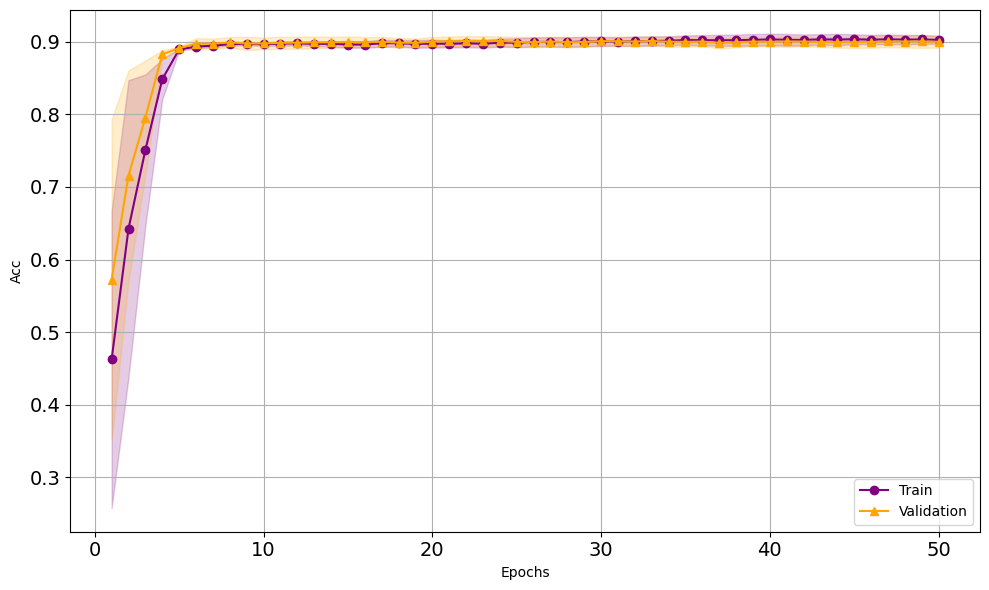

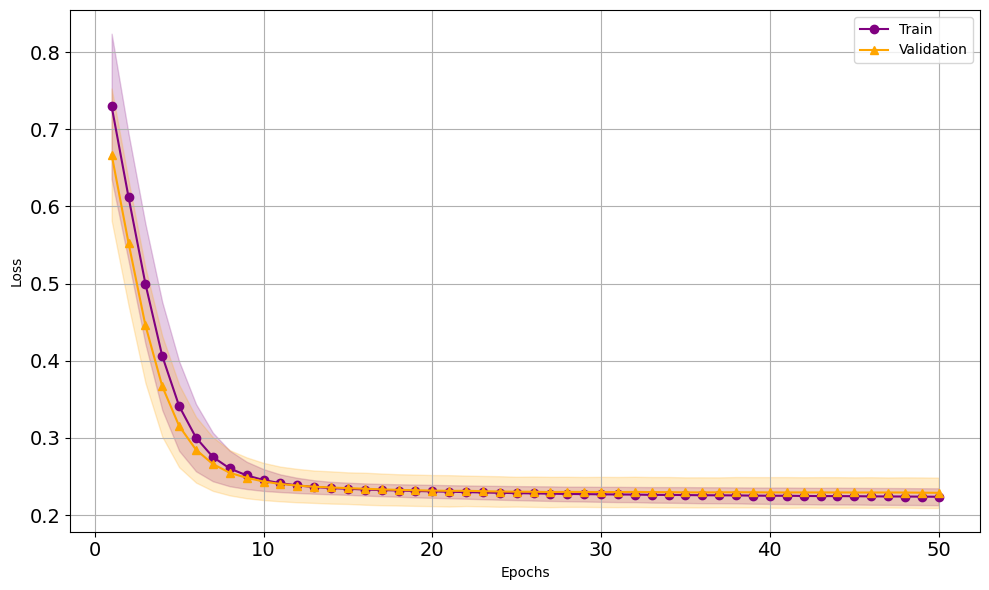

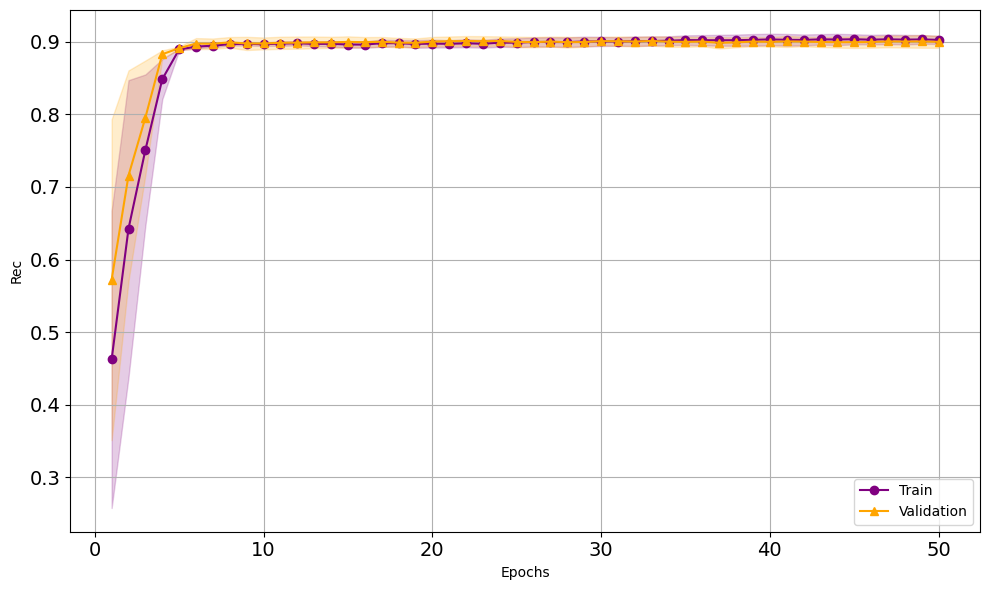

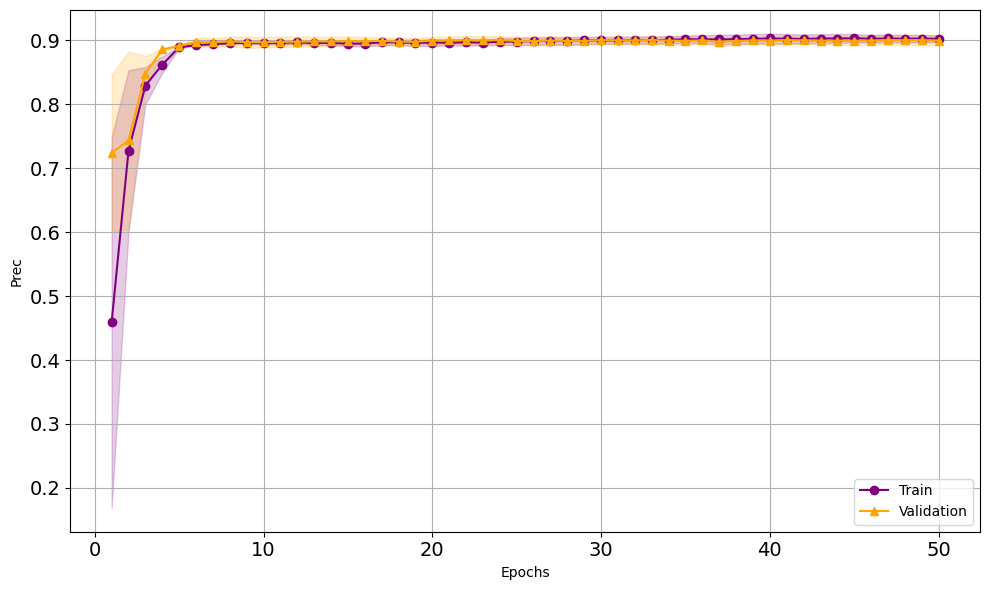

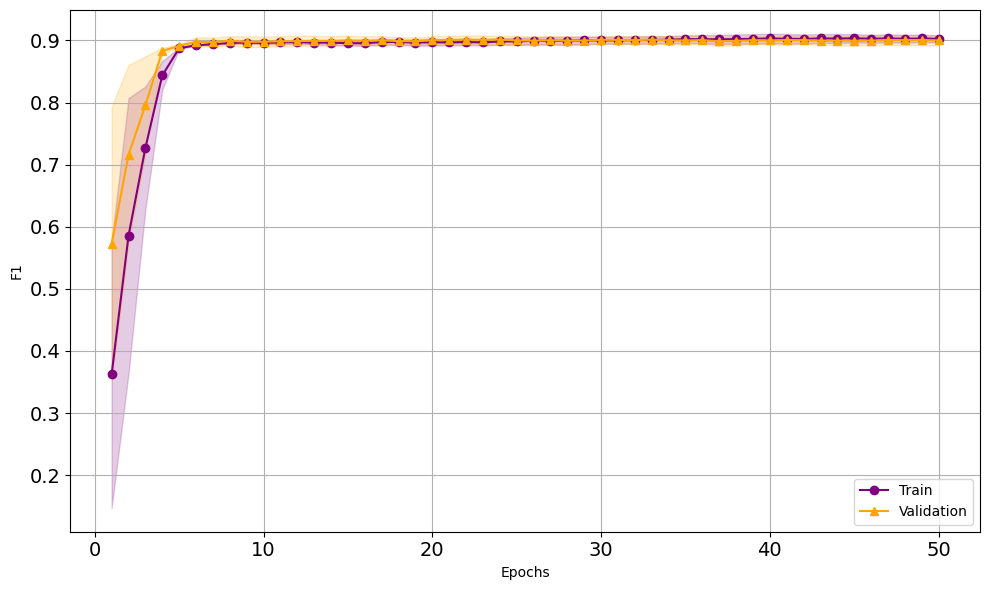

In [39]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range, classical=True, save_name=f"{model_name}_mean_{metric}_curve")
    metrics_summary[metric] = summary

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_means_stds_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [59]:
best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")

Best fold: 2 with val_f1 = 0.9114


In [60]:
test_classical_model = ClassicalModel()
# test_classical_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_model_best.pth"))
# test_classical_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{best_fold}_best.pth"))
# test_classical_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_classical_model.load_state_dict(torch.load(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_classical_model.to(device)

c_test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, classical_test_probs, classical_test_labels = evaluate_v2(test_classical_model, test_loader, optimizer, criterion, device)

c_test_metrics["acc"].append(test_acc)
c_test_metrics["loss"].append(test_loss)
c_test_metrics["rec"].append(test_rec)
c_test_metrics["prec"].append(test_prec)
c_test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_test_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_test_metrics.json", "w") as f:
    json.dump(c_test_metrics, f, indent=4)

Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 373.32it/s, loss=0.3822, acc=

Test loss: 0.3822 | Test acc: 0.8494 | Test rec: 0.8494 | Test prec: 0.8529 | Test f1: 0.8494


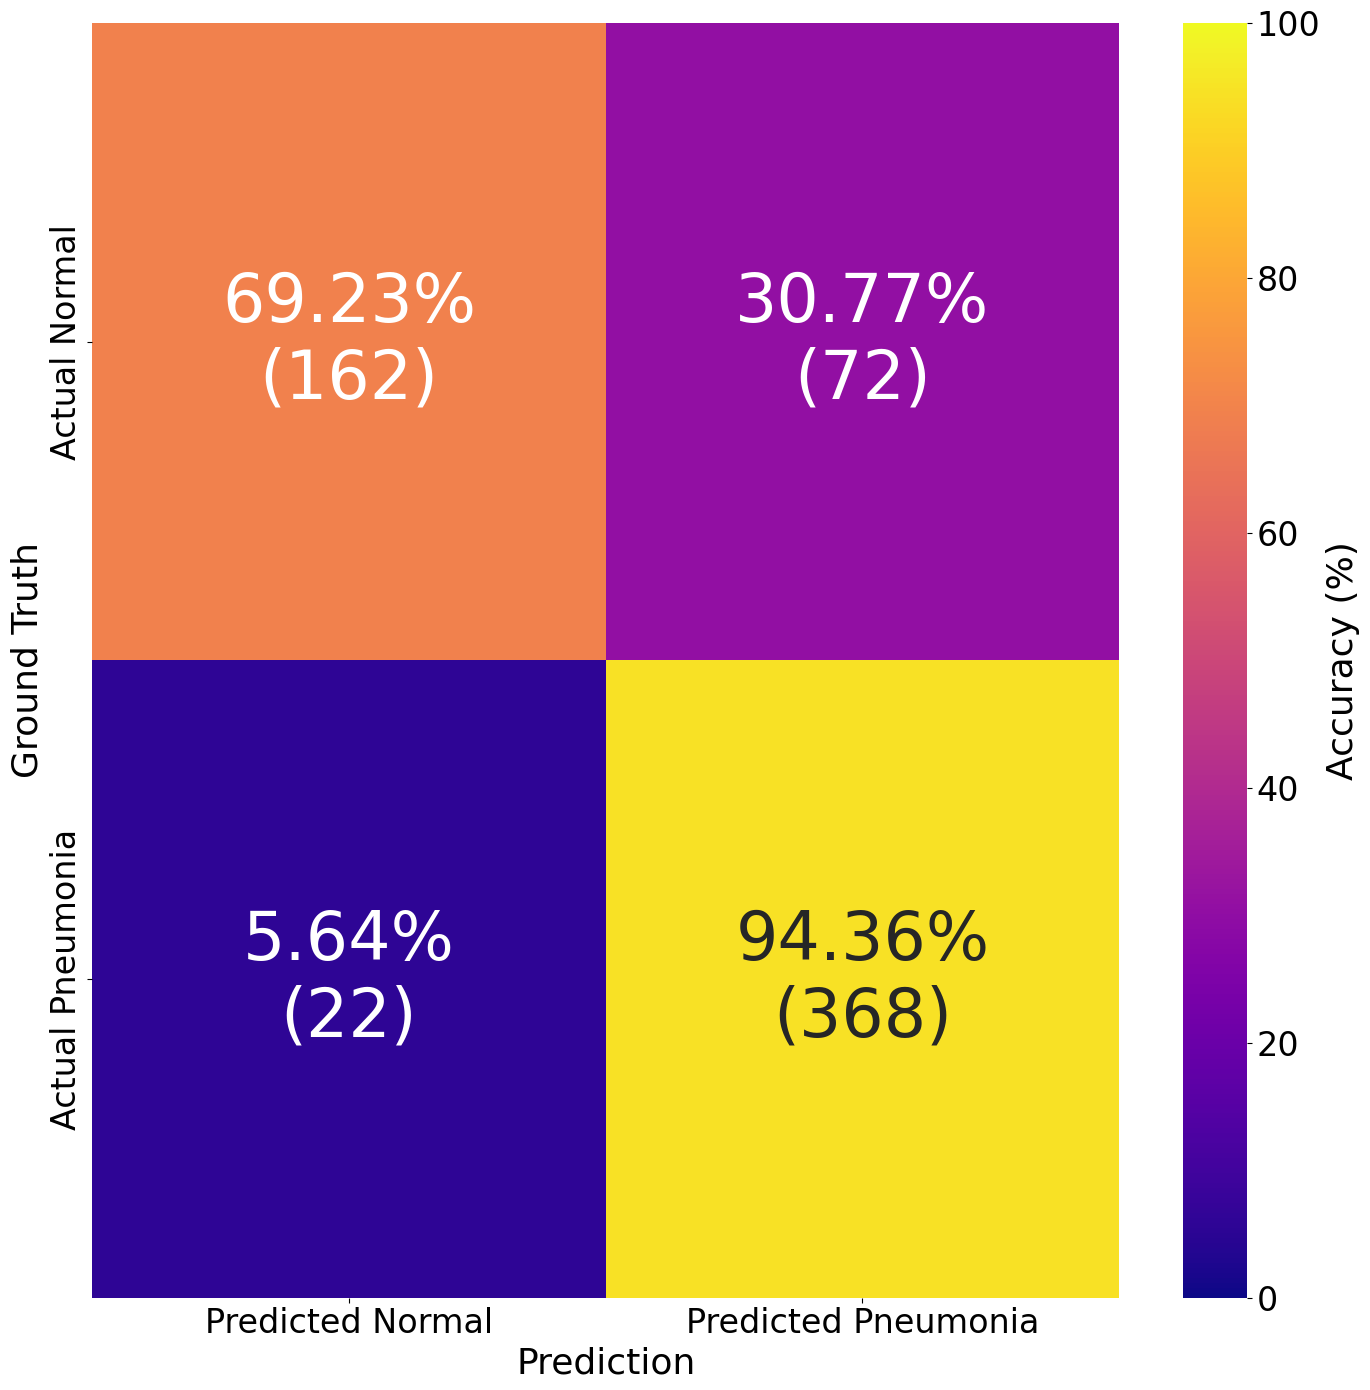

In [38]:
label_names = ["Normal", "Pneumonia"]

plot_confusion_matrix(classical_test_labels, test_preds, label_names, model_name, binary=True)

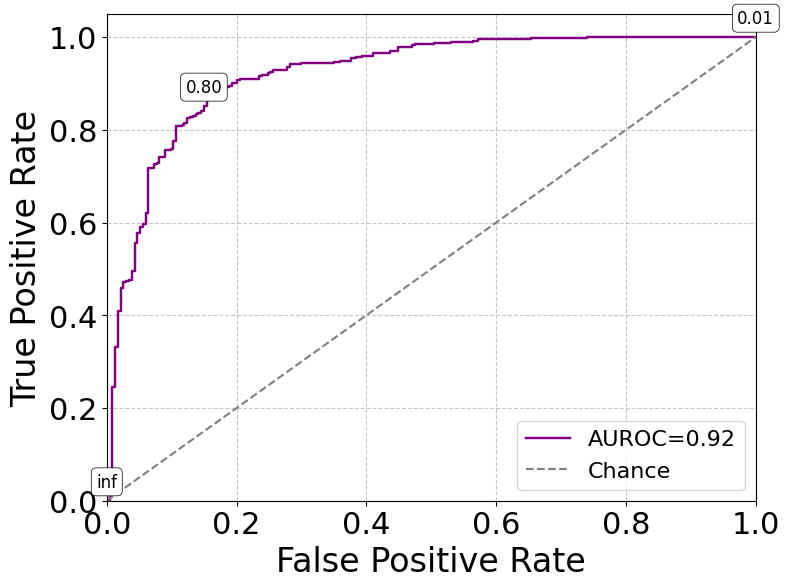

In [39]:
plot_auroc(classical_test_labels, classical_test_probs, model_name, binary=True)

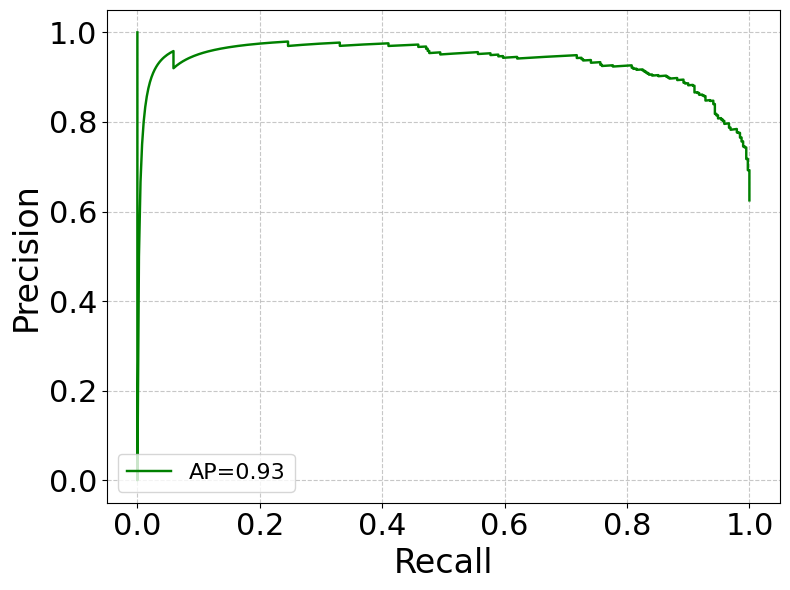

In [40]:
plot_prec(classical_test_labels, classical_test_probs, model_name, binary=True)

In [52]:
cam, outputs, predictions = gradcam_model(test_classical_model, x_test_tensor[0:16], quantum=False)
print(cam.shape)

torch.Size([16, 4])


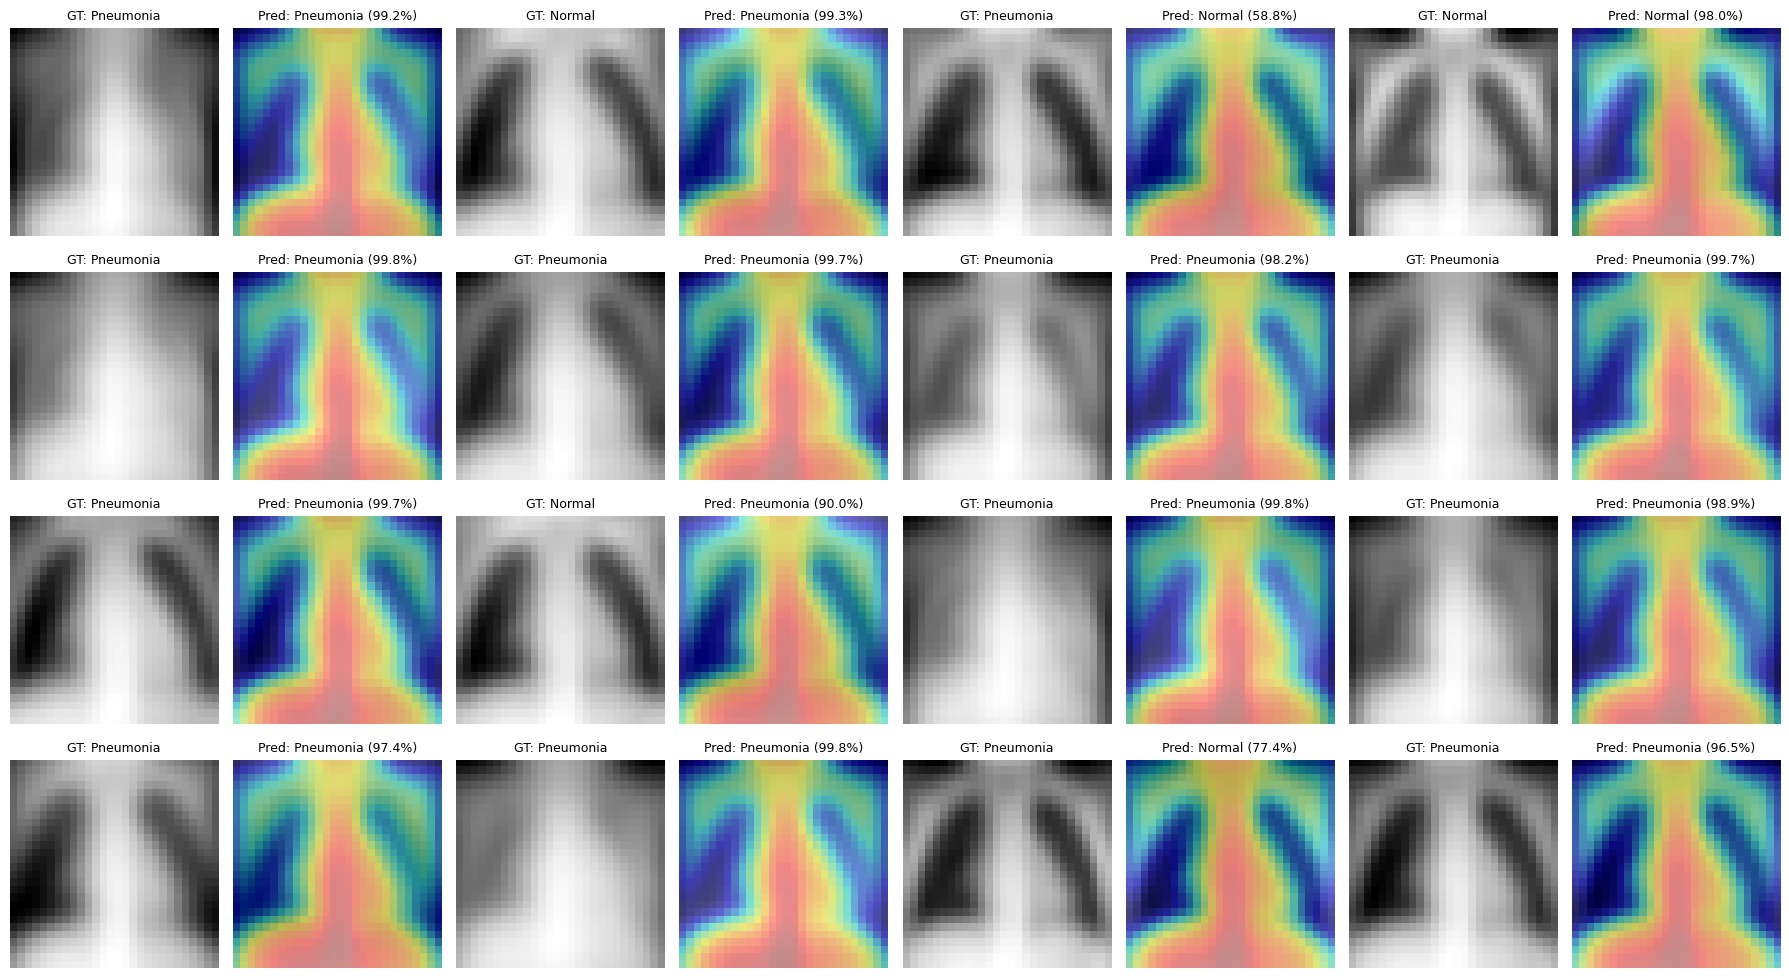

In [53]:
plot_reconstructed_heatmaps_with_predictions(
    samples = x_test_tensor[0:16].to(device),
    cam = cam,
    preds = predictions,
    probs = outputs,
    labels = y_test_tensor[0:16].to(device),
    encoder = encoder,
    class_names = label_names,
)

## FINAL MODEL COMPARISON

In [41]:
import numpy as np

noise_std = np.arange(0.1, 1.05, 0.05)

cv_noise_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

dv_noise_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

classical_noise_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

dataset_name = "pneumonia"

print("CV noise")
cv_noise_metrics = noise_robustness_validation(test_cv_model, test_loader, noise_std, cv_noise_metrics, "cv", optimizer, criterion, device)
print("DV noise")
dv_noise_metrics = noise_robustness_validation(test_dv_model, test_loader, noise_std, dv_noise_metrics, "dv", optimizer, criterion, device)
print("Classical noise")
classic_noise_metrics = noise_robustness_validation(test_classical_model, test_loader, noise_std, classical_noise_metrics, "classical", optimizer, criterion, device)

CV noise
[STD: 0.10] Clean mean: 0.0186, Noisy mean: 0.0208


Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.57it/s, loss=0.3987, acc=0


[STD: 0.15] Clean mean: 0.0186, Noisy mean: 0.0165


Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.65it/s, loss=0.3999, acc=0


[STD: 0.20] Clean mean: 0.0186, Noisy mean: 0.0218


Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.64it/s, loss=0.4370, acc=0


[STD: 0.25] Clean mean: 0.0186, Noisy mean: 0.0201


Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.62it/s, loss=0.4382, acc=0


[STD: 0.30] Clean mean: 0.0186, Noisy mean: 0.0240


Training | Epoch None: 100%|█| 20/20 [00:01<00:00, 11.03it/s, loss=0.4382, acc=0


[STD: 0.35] Clean mean: 0.0186, Noisy mean: 0.0160


Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.60it/s, loss=0.4398, acc=0


[STD: 0.40] Clean mean: 0.0186, Noisy mean: 0.0281


Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.62it/s, loss=0.4414, acc=0


[STD: 0.45] Clean mean: 0.0186, Noisy mean: 0.0171


Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.63it/s, loss=0.4790, acc=0


[STD: 0.50] Clean mean: 0.0186, Noisy mean: 0.0137


Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.55it/s, loss=0.4731, acc=0


[STD: 0.55] Clean mean: 0.0186, Noisy mean: 0.0236


Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.62it/s, loss=0.5144, acc=0


[STD: 0.60] Clean mean: 0.0186, Noisy mean: 0.0045


Training | Epoch None: 100%|█| 20/20 [00:01<00:00, 11.01it/s, loss=0.5632, acc=0


[STD: 0.65] Clean mean: 0.0186, Noisy mean: 0.0022


Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.66it/s, loss=0.6430, acc=0


[STD: 0.70] Clean mean: 0.0186, Noisy mean: 0.0250


Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.64it/s, loss=0.5843, acc=0


[STD: 0.75] Clean mean: 0.0186, Noisy mean: 0.0251


Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.63it/s, loss=0.5707, acc=0


[STD: 0.80] Clean mean: 0.0186, Noisy mean: 0.0523


Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.42it/s, loss=0.6899, acc=0


[STD: 0.85] Clean mean: 0.0186, Noisy mean: -0.0029


Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.46it/s, loss=0.7434, acc=0


[STD: 0.90] Clean mean: 0.0186, Noisy mean: 0.0521


Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.45it/s, loss=0.6453, acc=0


[STD: 0.95] Clean mean: 0.0186, Noisy mean: -0.0001


Training | Epoch None: 100%|█| 20/20 [00:01<00:00, 10.87it/s, loss=0.7044, acc=0


[STD: 1.00] Clean mean: 0.0186, Noisy mean: 0.0090


Training | Epoch None: 100%|█| 20/20 [00:02<00:00,  9.48it/s, loss=0.8887, acc=0


DV noise
[STD: 0.10] Clean mean: 0.0186, Noisy mean: 0.0139


Training | Epoch None: 100%|█| 20/20 [00:07<00:00,  2.81it/s, loss=0.3774, acc=0


[STD: 0.15] Clean mean: 0.0186, Noisy mean: 0.0184


Training | Epoch None: 100%|█| 20/20 [00:07<00:00,  2.81it/s, loss=0.3885, acc=0


[STD: 0.20] Clean mean: 0.0186, Noisy mean: 0.0162


Training | Epoch None: 100%|█| 20/20 [00:07<00:00,  2.71it/s, loss=0.3920, acc=0


[STD: 0.25] Clean mean: 0.0186, Noisy mean: 0.0280


Training | Epoch None: 100%|█| 20/20 [00:07<00:00,  2.82it/s, loss=0.4132, acc=0


[STD: 0.30] Clean mean: 0.0186, Noisy mean: 0.0179


Training | Epoch None: 100%|█| 20/20 [00:07<00:00,  2.79it/s, loss=0.4131, acc=0


[STD: 0.35] Clean mean: 0.0186, Noisy mean: 0.0249


Training | Epoch None: 100%|█| 20/20 [00:07<00:00,  2.80it/s, loss=0.4518, acc=0


[STD: 0.40] Clean mean: 0.0186, Noisy mean: 0.0026


Training | Epoch None: 100%|█| 20/20 [00:07<00:00,  2.82it/s, loss=0.4531, acc=0


[STD: 0.45] Clean mean: 0.0186, Noisy mean: 0.0214


Training | Epoch None: 100%|█| 20/20 [00:07<00:00,  2.80it/s, loss=0.4605, acc=0


[STD: 0.50] Clean mean: 0.0186, Noisy mean: 0.0273


Training | Epoch None: 100%|█| 20/20 [00:06<00:00,  2.88it/s, loss=0.4532, acc=0


[STD: 0.55] Clean mean: 0.0186, Noisy mean: 0.0230


Training | Epoch None: 100%|█| 20/20 [00:06<00:00,  2.90it/s, loss=0.4906, acc=0


[STD: 0.60] Clean mean: 0.0186, Noisy mean: 0.0078


Training | Epoch None: 100%|█| 20/20 [00:06<00:00,  2.88it/s, loss=0.5360, acc=0


[STD: 0.65] Clean mean: 0.0186, Noisy mean: 0.0260


Training | Epoch None: 100%|█| 20/20 [00:06<00:00,  2.87it/s, loss=0.5546, acc=0


[STD: 0.70] Clean mean: 0.0186, Noisy mean: 0.0266


Training | Epoch None: 100%|█| 20/20 [00:06<00:00,  2.87it/s, loss=0.5754, acc=0


[STD: 0.75] Clean mean: 0.0186, Noisy mean: -0.0008


Training | Epoch None: 100%|█| 20/20 [00:07<00:00,  2.78it/s, loss=0.5451, acc=0


[STD: 0.80] Clean mean: 0.0186, Noisy mean: 0.0217


Training | Epoch None: 100%|█| 20/20 [00:06<00:00,  2.91it/s, loss=0.6112, acc=0


[STD: 0.85] Clean mean: 0.0186, Noisy mean: 0.0495


Training | Epoch None: 100%|█| 20/20 [00:06<00:00,  2.92it/s, loss=0.6561, acc=0


[STD: 0.90] Clean mean: 0.0186, Noisy mean: 0.0107


Training | Epoch None: 100%|█| 20/20 [00:06<00:00,  2.91it/s, loss=0.6808, acc=0


[STD: 0.95] Clean mean: 0.0186, Noisy mean: 0.0130


Training | Epoch None: 100%|█| 20/20 [00:06<00:00,  2.88it/s, loss=0.7183, acc=0


[STD: 1.00] Clean mean: 0.0186, Noisy mean: 0.0412


Training | Epoch None: 100%|█| 20/20 [00:06<00:00,  2.89it/s, loss=0.8029, acc=0


Classical noise
[STD: 0.10] Clean mean: 0.0186, Noisy mean: 0.0201


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 482.73it/s, loss=0.3817, acc=


[STD: 0.15] Clean mean: 0.0186, Noisy mean: 0.0190


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 630.98it/s, loss=0.3983, acc=


[STD: 0.20] Clean mean: 0.0186, Noisy mean: 0.0148


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 633.09it/s, loss=0.3965, acc=


[STD: 0.25] Clean mean: 0.0186, Noisy mean: 0.0134


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 635.18it/s, loss=0.4129, acc=


[STD: 0.30] Clean mean: 0.0186, Noisy mean: 0.0249


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 710.45it/s, loss=0.4282, acc=


[STD: 0.35] Clean mean: 0.0186, Noisy mean: 0.0108


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 673.94it/s, loss=0.4356, acc=


[STD: 0.40] Clean mean: 0.0186, Noisy mean: 0.0055


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 481.22it/s, loss=0.4099, acc=


[STD: 0.45] Clean mean: 0.0186, Noisy mean: 0.0164


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 765.47it/s, loss=0.4849, acc=


[STD: 0.50] Clean mean: 0.0186, Noisy mean: 0.0137


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 686.64it/s, loss=0.4420, acc=


[STD: 0.55] Clean mean: 0.0186, Noisy mean: 0.0112


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 635.23it/s, loss=0.5119, acc=


[STD: 0.60] Clean mean: 0.0186, Noisy mean: 0.0208


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 659.04it/s, loss=0.5785, acc=


[STD: 0.65] Clean mean: 0.0186, Noisy mean: 0.0129


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 696.37it/s, loss=0.6005, acc=


[STD: 0.70] Clean mean: 0.0186, Noisy mean: 0.0359


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 688.53it/s, loss=0.5926, acc=


[STD: 0.75] Clean mean: 0.0186, Noisy mean: 0.0179


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 678.75it/s, loss=0.6067, acc=


[STD: 0.80] Clean mean: 0.0186, Noisy mean: 0.0223


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 677.40it/s, loss=0.6034, acc=


[STD: 0.85] Clean mean: 0.0186, Noisy mean: 0.0332


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 608.38it/s, loss=0.6123, acc=


[STD: 0.90] Clean mean: 0.0186, Noisy mean: 0.0314


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 636.46it/s, loss=0.8046, acc=


[STD: 0.95] Clean mean: 0.0186, Noisy mean: 0.0307


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 674.92it/s, loss=0.7053, acc=


[STD: 1.00] Clean mean: 0.0186, Noisy mean: 0.0628


Training | Epoch None: 100%|█| 20/20 [00:00<00:00, 646.32it/s, loss=0.7982, acc=


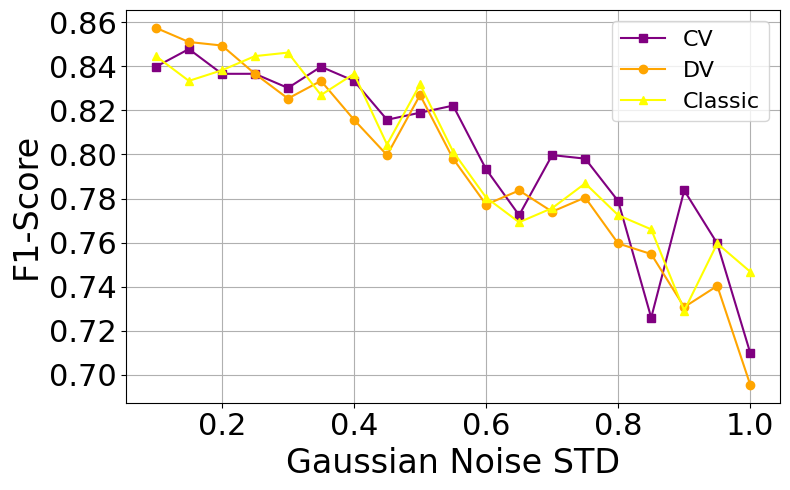

In [42]:
plot_noise_comparison(cv_noise_metrics["f1"], dv_noise_metrics["f1"], classic_noise_metrics["f1"], noise_std, "F1-Score", dataset_name)

## RELIABILITY ASSESSMENT

In [66]:
import numpy as np
import matplotlib.pyplot as plt
cv_test_probs_np = np.array(cv_test_probs)
dv_test_probs_np = np.array(dv_test_probs)
classical_test_probs_np = np.array(classical_test_probs)

In [67]:
def brier_score(y_true, y_prob):
    #binary
    if y_prob.ndim == 1 or y_prob.shape[1] == 1:
        return np.mean((y_prob - y_true)**2)

    #multiclass
    n_classes = y_prob.shape[1]
    y_true_onehot = np.eye(n_classes)[y_true]
    return np.mean(np.sum((y_prob - y_true_onehot)**2, axis=1))

def compute_ece(y_true, y_prob, n_bins=10):
    #ensure numpy arrays
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    if y_prob.ndim > 1 and y_prob.shape[1] > 1:
        confidences = np.max(y_prob, axis=1)
        preds = np.argmax(y_prob, axis=1)

    else:
        confidences = y_prob
        preds = (y_prob >= 0.5).astype(int)

    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(confidences, bins) - 1

    ece = 0.0
    total = len(y_true)

    for b in range(n_bins):
        idx = np.where(bin_ids == b)[0]
        if len(idx) == 0:
            continue

        acc = np.mean(y_true[idx] == preds[idx])
        conf = np.mean(confidences[idx])
        ece += (len(idx) / total) * abs(acc - conf)

    return ece

In [68]:
def reliability_diagram_multi(models_data, dataset_name, n_bins=10, save_name=None):

    """
    models_data = {
    "classical": (y_true, y_prob),
    "dv": (y_true, y_prob),
    "cv": (y_true, y_prob)
    }
    """
    
    plt.figure(figsize=(8,6))
    plt.plot([0,1], [0,1], '--', color='gray', label="Perfect Calibration")

    for name, (y_true, y_prob) in models_data.items():
        #ensure numpy arrays
        y_true = np.array(y_true)
        y_prob = np.array(y_prob)
        
        if y_prob.ndim > 1 and y_prob.shape[1] > 1:
            conf = np.max(y_prob, axis=1)
            pred = np.argmax(y_prob, axis=1)
        else:
            conf = y_prob
            pred = (y_prob >= 0.5).astype(int)

        bins = np.linspace(0, 1, n_bins + 1)
        bin_ids = np.digitize(conf, bins) - 1

        accs, confs = [], []
        for b in range(n_bins):
            idx = np.where(bin_ids == b)[0]
            if len(idx) == 0:
                continue
            accs.append((y_true[idx] == pred[idx]).mean())
            confs.append(conf[idx].mean())

        plt.plot(confs, accs, marker="o", label=name)

    plt.xlabel("Mean confidence", fontsize=26)
    plt.ylabel("Accuracy", fontsize=26)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.grid(True)

    if save_name:
        # plt.savefig(f"/home/dalopezm/quantum-studies/quantum-cv/results/{save_name}_{dataset_name}", dpi=300)
        plt.savefig(f"/home/dalopezm/gaussian-qnns/results/{save_name}_{dataset_name}", dpi=300)

    plt.show()

CV brier: 0.22541910624138126
DV brier: 0.22128010948296356
classical brier: 0.21979812008934752
CV ece: 0.04930956824085652
DV ece: 0.03524370854481673
classical ece 0.03417293813366154


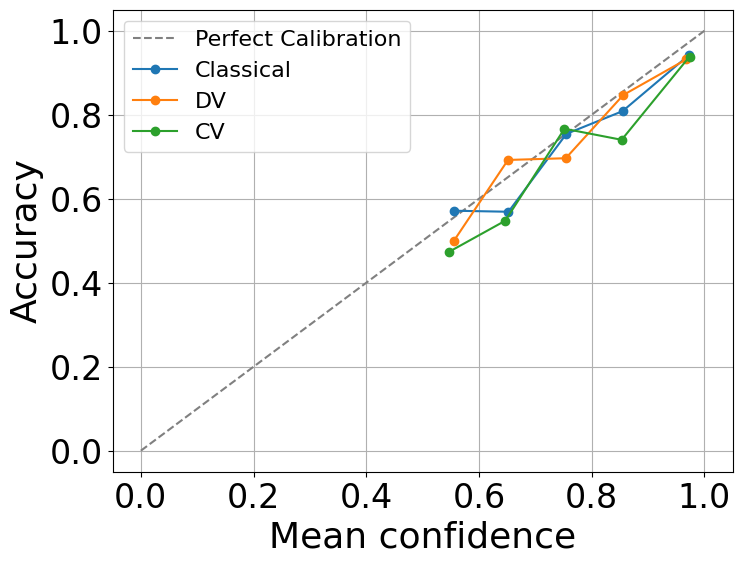

In [70]:
models_data = {
    "Classical": (classical_test_labels, classical_test_probs_np),
    "DV": (dv_test_labels, dv_test_probs_np),
    "CV": (cv_test_labels, cv_test_probs_np)
}

#brier score for pneumonia
cv_brier = brier_score(cv_test_labels, cv_test_probs_np)
dv_brier = brier_score(dv_test_labels, dv_test_probs_np)
classical_brier = brier_score(classical_test_labels, classical_test_probs_np)

#ECE value for pneumonia
cv_ece = compute_ece(cv_test_labels, cv_test_probs_np)
dv_ece = compute_ece(dv_test_labels, dv_test_probs_np)
classical_ece = compute_ece(classical_test_labels, classical_test_probs_np)

print(f"CV brier: {cv_brier}")
print(f"DV brier: {dv_brier}")
print(f"classical brier: {classical_brier}")

print(f"CV ece: {cv_ece}")
print(f"DV ece: {dv_ece}")
print(f"classical ece {classical_ece}")

reliability_diagram_multi(models_data, "pneumonia", save_name="reliability")